# Talking Data User Demographics ML Self Case Study

## 1. Business Problem

### 1.1. Problem Overview

Nothing is more comforting than being greeted by your favorite drink just as you walk through the door of the corner café. While a thoughtful barista knows you take a macchiato every Wednesday morning at 8:15, it’s much more difficult in a digital space for your preferred brands to personalize your experience.

TalkingData, China’s largest third-party mobile data platform, understands that everyday choices and behaviors paint a picture of who we are and what we value. Currently, TalkingData is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences.

In this competition, Kagglers are challenged to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

**Source:**https://www.kaggle.com/c/talkingdata-mobile-user-demographics/overview

### 1.2. Real-world/Business objectives and constraints

* No low-latency requirement.
* Probability of a data-point belonging to each class is needed.

## 2. Machine Learning Problem Formulation

### 2.1. Data Overview

The Data is collected from TalkingData SDK integrated within mobile apps TalkingData serves under the service term between TalkingData and mobile app developers. 

**Source:** https://www.kaggle.com/c/talkingdata-mobile-user-demographics/data

1. **gender_age_train.csv, gender_age_test.csv** - the training and test set
     group: this is the target variable we are going to predict
2. **events.csv, app_events.csv** - when a user uses TalkingData SDK, the event gets logged in this data. Each event has an event id, location (lat/long), and the event corresponds to a list of apps in app_events.
    timestamp: when the user is using an app with TalkingData SDK
3. **app_labels.csv** - apps and their labels, the label_id's can be used to join with label_categories
4. **label_categories.csv** - apps' labels and their categories in text
5. **phone_brand_device_model.csv** - device ids, brand, and models
    phone_brand: note that the brands are in Chinese (translation courtesy of user fromandto) 
    
     * 三星 samsung

     * 天语 Ktouch

     * 海信 hisense

     *  联想 lenovo

     * 欧比 obi

     * 爱派尔 ipair

     * 努比亚 nubia

     * 优米 youmi

     * 朵唯 dowe

     * 黑米 heymi

     * 锤子 hammer

     * 酷比魔方 koobee

     * 美图 meitu

     * 尼比鲁 nibilu

     * 一加 oneplus

     * 优购 yougo

     * 诺基亚 nokia

     * 糖葫芦 candy

     * 中国移动 ccmc

     * 语信 yuxin

     * 基伍 kiwu

     * 青橙 greeno

     * 华硕 asus

     * 夏新 panosonic

     * 维图 weitu

     * 艾优尼 aiyouni

     * 摩托罗拉 moto

     * 乡米 xiangmi

     * 米奇 micky

     * 大可乐 bigcola

     * 沃普丰 wpf

     * 神舟 hasse

     * 摩乐 mole

     * 飞秒 fs

     * 米歌 mige

     * 富可视 fks

     * 德赛 desci

     * 梦米 mengmi

     * 乐视 lshi

     * 小杨树 smallt

     * 纽曼 newman

     * 邦华 banghua

     * E派 epai

     * 易派 epai

     * 普耐尔 pner

     * 欧新 ouxin

     * 西米 ximi

     * 海尔 haier

     * 波导 bodao

     * 糯米 nuomi

     * 唯米 weimi

     * 酷珀 kupo

     * 谷歌 google

     * 昂达 ada

     * 聆韵 lingyun

### 2.2 Mapping Real-World Problem to Machine-Learning Problem

#### 2.2.1. Type of ML Problem 

1. It is a Multi-Class Classification Problem.
2. The 12 classes to predict are:
   * F23-
   * F24-26
   * F27-28
   * F29-32
   * F33-42
   * F43+
   * M22- 
   * M23-26  
   * M27-28 
   * M29-31 
   * M32-38 
   * M39+


#### 2.2.2. Performance Metric

**Source:** https://www.kaggle.com/c/talkingdata-mobile-user-demographics/overview/evaluation

1. Multi-class Log-loss
2. Confusion Matrix

#### 2.2.3. Machine Learing Objectives and Constraints

**Objective:** Predict the probability of each data-point belonging to each of the 12 classes.

**Constraints:**
* Class probabilities are needed.
* No Latency constraints.

## 3. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import re
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

**Gender-Age Train Data**

In [2]:
gender_age_train=pd.read_csv('gender_age_train.csv')

In [3]:
gender_age_train.head()

device_id gender  age   group
0 -8076087639492063270      M   35  M32-38
1 -2897161552818060146      M   35  M32-38
2 -8260683887967679142      M   35  M32-38
3 -4938849341048082022      M   30  M29-31
4   245133531816851882      M   30  M29-31

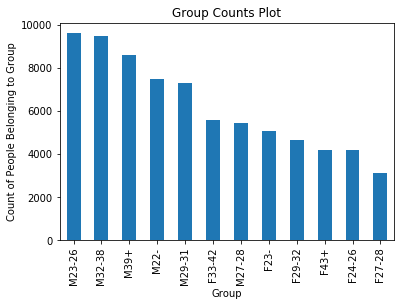

In [4]:
plt.title('Group Counts Plot')
plt.xlabel('Group')
plt.ylabel('Count of People Belonging to Group')
gender_age_train['group'].value_counts().plot.bar()
plt.show()

**Observation**
1. It is not a Balanced Dataset
2. The Number of points for Male gender age groups is more than Female gender age groups

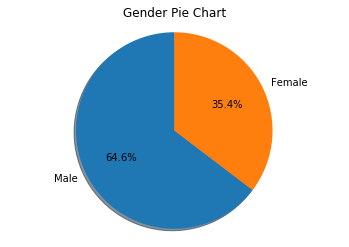

In [5]:
#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
gender_dict=gender_age_train['gender'].value_counts()
gender_labels=['Male','Female']
male_percentage=(gender_dict['M']*100)//gender_age_train.shape[0]
female_percentage=(gender_dict['F']*100)//gender_age_train.shape[0]
sizes=[male_percentage,female_percentage]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=gender_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Gender Pie Chart')
plt.show()

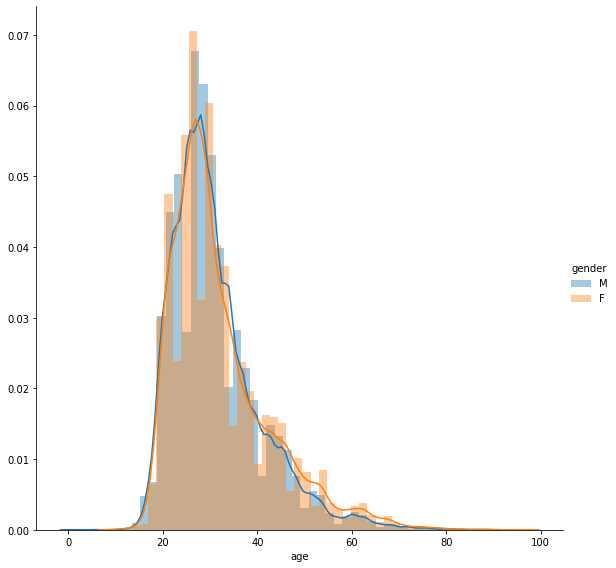

In [6]:
sns.FacetGrid(gender_age_train, hue="gender", size=8) \
   .map(sns.distplot, "age") \
   .add_legend();
plt.show()

**Observation:**
1. There is a overlap in the Number of Male and Female in the age group of 15 to 40
2. The Number of Female is slightly more than Male in the age group from 42 to 65

In [7]:
gender_male=gender_age_train.loc[gender_age_train['gender']=='M']
gender_female=gender_age_train.loc[gender_age_train['gender']=='F']
print("="*50)
male_percentile=np.percentile(gender_male['age'],[25,50,75,90,100])
male_median=np.median(gender_male['age'].values)
female_percentile=np.percentile(gender_female['age'],[25,50,75,90,100])
female_median=np.median(gender_female['age'].values)
print('Gender Stats: Male')
print('-'*50)
print(gender_male['age'].describe())
print('Median: ',male_median)
print('25th, 50th, 75th, 90th , 100th Percentile: ',male_percentile)
print("="*50)
print('Gender Stats: Female')
print('-'*50)
print(gender_female['age'].describe())
print('Median: ',female_median)
print('25th, 50th, 75th, 90th , 100th Percentile: ',female_percentile)

Gender Stats: Male
--------------------------------------------------
count    47904.000000
mean        31.052939
std          9.454653
min          1.000000
25%         25.000000
50%         29.000000
75%         35.000000
max         90.000000
Name: age, dtype: float64
Median:  29.0
25th, 50th, 75th, 90th , 100th Percentile:  [25. 29. 35. 44. 90.]
Gender Stats: Female
--------------------------------------------------
count    26741.000000
mean        32.050596
std         10.539967
min         10.000000
25%         25.000000
50%         29.000000
75%         37.000000
max         96.000000
Name: age, dtype: float64
Median:  29.0
25th, 50th, 75th, 90th , 100th Percentile:  [25. 29. 37. 47. 96.]


**Observation:**
1. The Number of Male is almost double the number of Female
2. The Mean, Median age is almost same for both Male and Female
3. 25 and 75 Percentile Age values for Both Male and Female are similar
4. In General Female users have more age than Male users in the Data

**Gender Age Test Data**

In [4]:
gender_age_test=pd.read_csv('gender_age_test.csv')

In [5]:
gender_age_test.columns.values

array(['device_id'], dtype=object)

In [10]:
print("Number of Values in Test Data: ",gender_age_test.shape[0])

Number of Values in Test Data:  112071


In [11]:
test_unique_devices=np.unique(gender_age_test['device_id'].values)
print("Number of Unique Device IDs :",len(test_unique_devices))

Number of Unique Device IDs : 112071


**Phone Brand and Device Model Data**

In [16]:
phone_data=pd.read_csv('phone_brand_device_model.csv')

In [7]:
phone_data.head()

device_id phone_brand   device_model
0 -8890648629457979026          小米             红米
1  1277779817574759137          小米           MI 2
2  5137427614288105724          三星      Galaxy S4
3  3669464369358936369       SUGAR           时尚手机
4 -5019277647504317457          三星  Galaxy Note 2

In [14]:
phone_data.shape

(187245, 3)

Phone Brand and Device Model are written in chinese and need to be translated to English

In [15]:
english_phone_brands_mapping = {
    "三星": "samsung",
    "天语": "Ktouch",
    "海信": "hisense",
    "联想": "lenovo",
    "欧比": "obi",
    "爱派尔": "ipair",
    "努比亚": "nubia",
    "优米": "youmi",
    "朵唯": "dowe",
    "黑米": "heymi",
    "锤子": "hammer",
    "酷比魔方": "koobee",
    "美图": "meitu",
    "尼比鲁": "nibilu",
    "一加": "oneplus",
    "优购": "yougo",
    "诺基亚": "nokia",
    "糖葫芦": "candy",
    "中国移动": "ccmc",
    "语信": "yuxin",
    "基伍": "kiwu",
    "青橙": "greeno",
    "华硕": "asus",
    "夏新": "panosonic",
    "维图": "weitu",
    "艾优尼": "aiyouni",
    "摩托罗拉": "moto",
    "乡米": "xiangmi",
    "米奇": "micky",
    "大可乐": "bigcola",
    "沃普丰": "wpf",
    "神舟": "hasse",
    "摩乐": "mole",
    "飞秒": "fs",
    "米歌": "mige",
    "富可视": "fks",
    "德赛": "desci",
    "梦米": "mengmi",
    "乐视": "lshi",
    "小杨树": "smallt",
    "纽曼": "newman",
    "邦华": "banghua",
    "E派": "epai",
    "易派": "epai",
    "普耐尔": "pner",
    "欧新": "ouxin",
    "西米": "ximi",
    "海尔": "haier",
    "波导": "bodao",
    "糯米": "nuomi",
    "唯米": "weimi",
    "酷珀": "kupo",
    "谷歌": "google",
    "昂达": "ada",
    "聆韵": "lingyun",
    "小米": "Xiaomi",
    "华为": "Huawei",
    "魅族": "Meizu",
    "中兴": "ZTE",
    "酷派": "Coolpad",
    "金立": "Gionee",
    "SUGAR": "SUGAR",
    "OPPO": "OPPO",
    "vivo": "vivo",
    "HTC": "HTC",
    "LG": "LG",
    "ZUK": "ZUK",
    "TCL": "TCL",
    "LOGO": "LOGO",
    "SUGAR": "SUGAR",
    "Lovme": "Lovme",
    "PPTV": "PPTV",
    "ZOYE": "ZOYE",
    "MIL": "MIL",
    "索尼" : "Sony",
    "欧博信" : "Opssom",
    "奇酷" : "Qiku",
    "酷比" : "CUBE",
    "康佳" : "Konka",
    "亿通" : "Yitong",
    "金星数码" : "JXD",
    "至尊宝" : "Monkey King",
    "百立丰" : "Hundred Li Feng",
    "贝尔丰" : "Bifer",
    "百加" : "Bacardi",
    "诺亚信" : "Noain",
    "广信" : "Kingsun",
    "世纪天元" : "Ctyon",
    "青葱" : "Cong",
    "果米" : "Taobao",
    "斐讯" : "Phicomm",
    "长虹" : "Changhong",
    "欧奇" : "Oukimobile",
    "先锋" : "XFPLAY",
    "台电" : "Teclast",
    "大Q" : "Daq",
    "蓝魔" : "Ramos",
    "奥克斯" : "AUX"
}

In [16]:
# # Translating the Chinese Terms in both columns to English
phone_data['phone_brand'] = phone_data['phone_brand'].apply(lambda x: english_phone_brands_mapping[x] if x in english_phone_brands_mapping else x)

In [17]:
phone_data.head()

device_id phone_brand   device_model
0 -8890648629457979026      Xiaomi             红米
1  1277779817574759137      Xiaomi           MI 2
2  5137427614288105724     samsung      Galaxy S4
3  3669464369358936369       SUGAR           时尚手机
4 -5019277647504317457     samsung  Galaxy Note 2

In [18]:
phone_data.shape

(187245, 3)

Are there any duplicates in Phone Data?

In [21]:
phone_devices_unique=np.unique(phone_data['device_id'].values)
print("Number of Unique Phone Devices: ",len(phone_devices_unique))
print("Total Number of Devices in Phone Data: ",phone_data.shape[0])
print("Number of Duplicate Devices: ",phone_data.shape[0]-len(phone_devices_unique))

Number of Unique Phone Devices:  186716
Total Number of Devices in Phone Data:  187245
Number of Duplicate Devices:  529


So there are few duplicate devices in phone Data which need to be removed

In [22]:
# https://stackoverflow.com/questions/20944483/python-3-sort-a-dict-by-its-values
#Sorting dict by value in decending order and storing keys
brand_dict=dict(phone_data['phone_brand'].value_counts())
brand_keys = [k for k in sorted(brand_dict, key=brand_dict.get, reverse=True)]
#Taking Top 15 keys with highest values 
brand_top_keys=brand_keys[:15]
brand_top_values=[brand_dict.get(k) for k in brand_top_keys]

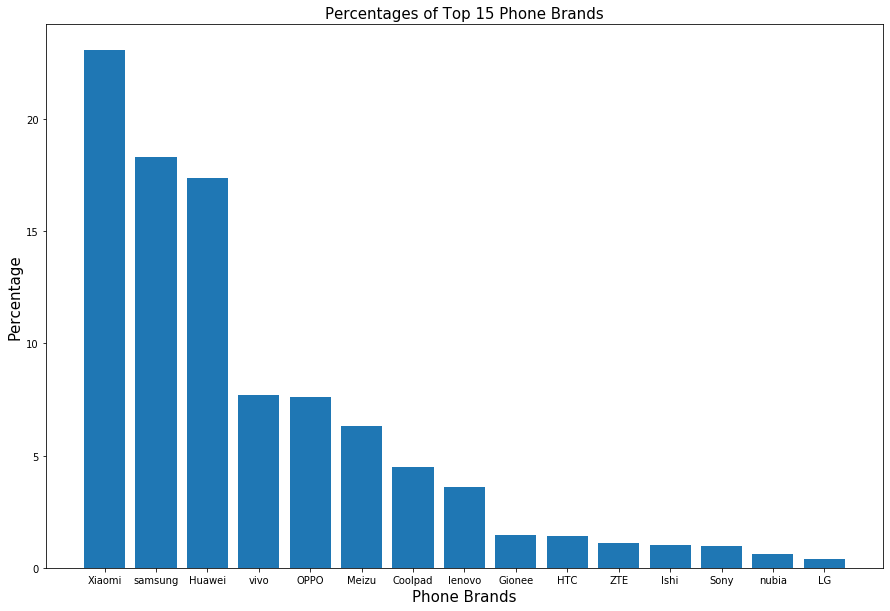

------------------------------------------------------------------------------------------
Brand:  Xiaomi  Percentage:  23.08  %
Brand:  samsung  Percentage:  18.31  %
Brand:  Huawei  Percentage:  17.39  %
Brand:  vivo  Percentage:  7.69  %
Brand:  OPPO  Percentage:  7.63  %
Brand:  Meizu  Percentage:  6.33  %
Brand:  Coolpad  Percentage:  4.49  %
Brand:  lenovo  Percentage:  3.61  %
Brand:  Gionee  Percentage:  1.48  %
Brand:  HTC  Percentage:  1.43  %
Brand:  ZTE  Percentage:  1.12  %
Brand:  lshi  Percentage:  1.03  %
Brand:  Sony  Percentage:  0.97  %
Brand:  nubia  Percentage:  0.61  %
Brand:  LG  Percentage:  0.41  %


In [23]:
plt.figure(figsize=(15,10))
indices=np.arange(len(brand_top_keys))
counts=np.array(brand_top_values)
percent=(counts/phone_data.shape[0])*100
plt.bar(indices,percent)
plt.xlabel('Phone Brands',fontsize=15)
plt.ylabel('Percentage',fontsize=15)
plt.title('Percentages of Top 15 Phone Brands',fontsize=15)
plt.xticks(indices,brand_top_keys)
plt.show()
print("-"*90)
for i in range(len(brand_top_keys)):
    print("Brand: ",brand_top_keys[i]," Percentage: ",np.round(percent[i],2)," %")

**Observation**
1. Xiaomi, Samsung, Huawei are the 3 most used Phone Brands by Talking Data customers which have a combined user Base of almost 58 % of the Total users
2. The Other 127 Phone Brands have a combined user Base of 42% of the Total users
3. Clearly Xiaomi, Samsung and Huawei Dominate the Chinese Mobile Phone Market 

**Label Categories Data**

In [2]:
label_categories=pd.read_csv('label_categories.csv')

In [3]:
label_categories.head()

label_id           category
0         1                NaN
1         2     game-game type
2         3   game-Game themes
3         4     game-Art Style
4         5  game-Leisure time

In [4]:
label_categories.shape

(930, 2)

**Events Data**

In [8]:
events=pd.read_csv('events.csv')

In [31]:
events.head()

event_id            device_id            timestamp  longitude  latitude
0         1    29182687948017175  2016-05-01 00:55:25     121.38     31.24
1         2 -6401643145415154744  2016-05-01 00:54:12     103.65     30.97
2         3 -4833982096941402721  2016-05-01 00:08:05     106.60     29.70
3         4 -6815121365017318426  2016-05-01 00:06:40     104.27     23.28
4         5 -5373797595892518570  2016-05-01 00:07:18     115.88     28.66

In [32]:
events.shape

(3252950, 5)

In [33]:
events_unique_devices=np.unique(events['device_id'].values)
print("Number of Unique Devices: ", len(events_unique_devices))

Number of Unique Devices:  60865


In [34]:
# Event Start and End time across the whole Data
event_times=events['timestamp'].values
print("Event Start: ",np.min(event_times))
print("Event End: ",np.max(event_times))

Event Start:  2016-04-30 23:52:24
Event End:  2016-05-08 00:00:08


**Observation:**
The Events Data provided is for a period of 8 Days Starting from 30th April 2016 mid-night to starting of 8th May 2016 12 AM

In [35]:
events['longitude'].describe()

count    3.252950e+06
mean     7.796192e+01
std      5.405801e+01
min     -1.800000e+02
25%      0.000000e+00
50%      1.129500e+02
75%      1.172100e+02
max      1.747600e+02
Name: longitude, dtype: float64

In [36]:
events['latitude'].describe()

count    3.252950e+06
mean     2.162949e+01
std      1.569697e+01
min     -3.843000e+01
25%      0.000000e+00
50%      2.802000e+01
75%      3.407000e+01
max      5.994000e+01
Name: latitude, dtype: float64

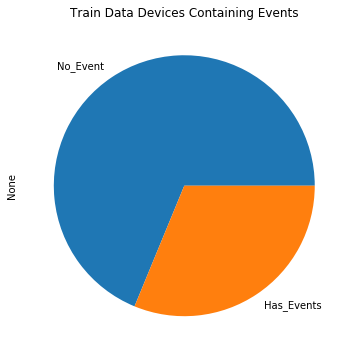

Has Events Percentage:  31.23  %
No Events Percentage:  68.77  %


In [37]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
plt.figure(figsize=(10,6))
devices_have_events=np.in1d(gender_age_train['device_id'].values,events['device_id'].values)
device_event_present=pd.Series(devices_have_events).map({True:'Has_Events',False:'No_Event'})
device_events_cnt=device_event_present.value_counts()
device_event_present.value_counts().plot.pie()
plt.title("Train Data Devices Containing Events")
plt.show()
print("Has Events Percentage: ",np.round((device_events_cnt['Has_Events']/(device_events_cnt['Has_Events']+device_events_cnt['No_Event']))*100,2), " %")
print("No Events Percentage: ",np.round((device_events_cnt['No_Event']/(device_events_cnt['Has_Events']+device_events_cnt['No_Event']))*100,2), " %")

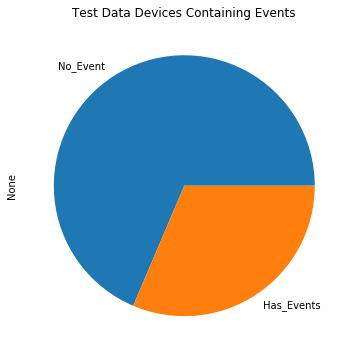

Has Events Percentage:  31.4  %
No Events Percentage:  68.6  %


In [38]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
plt.figure(figsize=(10,6))
devices_have_events=np.in1d(gender_age_test['device_id'].values,events['device_id'].values)
device_event_present=pd.Series(devices_have_events).map({True:'Has_Events',False:'No_Event'})
device_events_cnt=device_event_present.value_counts()
device_event_present.value_counts().plot.pie()
plt.title("Test Data Devices Containing Events")
plt.show()
print("Has Events Percentage: ",np.round((device_events_cnt['Has_Events']/(device_events_cnt['Has_Events']+device_events_cnt['No_Event']))*100,2), " %")
print("No Events Percentage: ",np.round((device_events_cnt['No_Event']/(device_events_cnt['Has_Events']+device_events_cnt['No_Event']))*100,2), " %")

**Observation:**
1. Both Train and Test Data have same percentage of devices with Events ~31%
2. Both Train and Test Data have same percentage of devices without Events as well ~69%

**App Labels Data**

In [5]:
app_labels=pd.read_csv('app_labels.csv')

In [6]:
app_labels.head()

app_id  label_id
0  7324884708820027918       251
1 -4494216993218550286       251
2  6058196446775239644       406
3  6058196446775239644       407
4  8694625920731541625       406

In [7]:
print('Number of Apps: ',app_labels.shape[0])

Number of Apps:  459943


In [8]:
unique_app_labels=np.unique(app_labels['label_id'].values)
print("Number of Unique App Labels: ", len(unique_app_labels))

Number of Unique App Labels:  507


Which are the most used app categories?

In [9]:
apps_label_category=pd.merge(app_labels,label_categories,on='label_id',how='left')

In [10]:
apps_label_category.head()

app_id  label_id         category
0  7324884708820027918       251          Finance
1 -4494216993218550286       251          Finance
2  6058196446775239644       406          unknown
3  6058196446775239644       407  DS_P2P net loan
4  8694625920731541625       406          unknown

In [11]:
# https://stackoverflow.com/questions/20944483/python-3-sort-a-dict-by-its-values
#Sorting dict by value in decending order and storing keys
cat_dict=dict(apps_label_category['category'].value_counts())
cat_keys = [k for k in sorted(cat_dict, key=cat_dict.get, reverse=True)]
#Taking Top 15 keys with highest values 
cat_top_keys=cat_keys[:10]
cat_top_values=[cat_dict.get(k) for k in cat_top_keys]

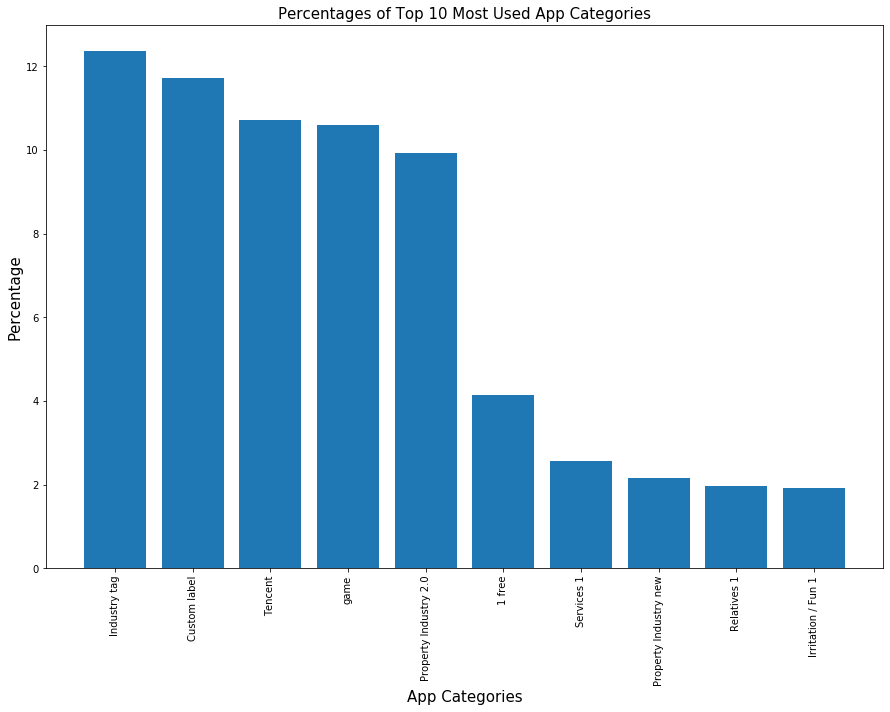

------------------------------------------------------------------------------------------
Category:  Industry tag 12.37  %
Category:  Custom label 11.73  %
Category:  Tencent 10.72  %
Category:  game 10.59  %
Category:  Property Industry 2.0 9.94  %
Category:  1 free 4.15  %
Category:  Services 1 2.57  %
Category:  Property Industry new 2.16  %
Category:  Relatives 1 1.96  %
Category:  Irritation / Fun 1 1.92  %


In [12]:
plt.figure(figsize=(15,10))
indices=np.arange(len(cat_top_keys))
counts=np.array(cat_top_values)
percent=(counts/apps_label_category.shape[0])*100
plt.bar(indices,percent)
plt.xlabel('App Categories',fontsize=15)
plt.ylabel('Percentage',fontsize=15)
plt.title('Percentages of Top 10 Most Used App Categories',fontsize=15)
plt.xticks(indices,cat_top_keys,rotation=90)
plt.show()
print("-"*90)
for i in range(len(cat_top_keys)):
    print("Category: ",cat_top_keys[i],np.round(percent[i],2)," %")

**App Events Data**

In [9]:
app_events=pd.read_csv('app_events.csv')

In [48]:
app_events.head()

event_id               app_id  is_installed  is_active
0         2  5927333115845830913             1          1
1         2 -5720078949152207372             1          0
2         2 -1633887856876571208             1          0
3         2  -653184325010919369             1          1
4         2  8693964245073640147             1          1

In [49]:
app_events.shape

(32473067, 4)

In [50]:
unique_apps_1=np.unique(app_events['app_id'].values)
unique_events_1=np.unique(app_events['event_id'].values)
print("Number of Unique Apps: ",len(unique_apps_1))
print("Number of Unique Events: ",len(unique_events_1))

Number of Unique Apps:  19237
Number of Unique Events:  1488096


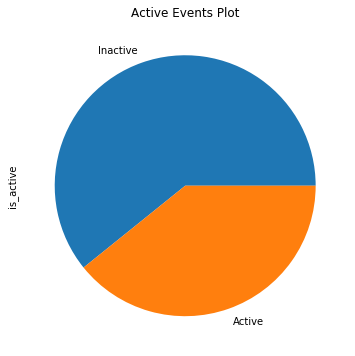

Active Events:  39.21  %
Inactive Events:  60.79  %


In [51]:
plt.figure(figsize=(10,6))
plt.title('Active Events Plot')
app_events['is_active'].map({1:'Active',0:'Inactive'}).value_counts().plot.pie()
plt.show()
print("Active Events: ",np.round(app_events['is_active'].value_counts()[1]*100/app_events.shape[0],2)," %")
print("Inactive Events: ",np.round(app_events['is_active'].value_counts()[0]*100/app_events.shape[0],2)," %")

In [52]:
app_events['is_installed'].value_counts()

1    32473067
Name: is_installed, dtype: int64

is_installed Feature is not of much use as it contains only single value which is 1 for all data points

**Data Present in Train and Test Data**

In [17]:
#Drop duplicate phone_data
phone_data = phone_data.drop_duplicates('device_id',keep='first').set_index('device_id')

In [11]:
gender_age_train=gender_age_train.set_index('device_id')
gender_age_test=gender_age_test.set_index('device_id')
events=events.set_index('device_id')

Since Both the Dataframes have device_id as indices , brand column will have phone_brand values corresponding to a device_id in phone_data

In [18]:
gender_age_train['brand']=phone_data['phone_brand']
gender_age_test['brand']=phone_data['phone_brand']
# Combining Device Model and Brand Name to create unique combinations of device models
phone_data['model']=phone_data['phone_brand'].str.cat(phone_data['device_model'])
gender_age_train['model']=phone_data['model']
gender_age_test['model']=phone_data['model']

In [21]:
train_brand_set=set(gender_age_train['brand'].values)
test_brand_set=set(gender_age_test['brand'].values)
train_model_set=set(gender_age_train['model'].values)
test_model_set=set(gender_age_test['model'].values)
brand_train_test_common=test_brand_set.intersection(train_brand_set)
model_train_test_common=test_model_set.intersection(train_model_set)
brands_test_not_common=len(test_brand_set)-len(brand_train_test_common)
models_test_not_common=len(test_model_set)-len(model_train_test_common)

In [24]:
print("Number of Uniue Brands in Train Data: ",len(train_brand_set))
print("Number of Uniue Brands in Test Data: ",len(test_brand_set))
print("Number of Uniue Brands Common in Both Train and Test Data: ",len(brand_train_test_common))
print("Percentage of Common Brands: ",np.round((len(brand_train_test_common)/len(np.unique(phone_data['phone_brand'].values))*100),2)," %")
print("Number of Brands in Test but not in Train: ",brands_test_not_common)
print("Percentage of Brands in Test but not in Train: ",np.round((brands_test_not_common/len(np.unique(phone_data['phone_brand'].values))*100),2)," %")

Number of Uniue Brands in Train Data:  120
Number of Uniue Brands in Test Data:  126
Number of Uniue Brands Common in Both Train and Test Data:  115
Percentage of Common Brands:  87.79  %
Number of Brands in Test but not in Train:  11
Percentage of Brands in Test but not in Train:  8.4  %


In [25]:
print("Number of Uniue Models in Train Data: ",len(train_model_set))
print("Number of Uniue Models in Test Data: ",len(test_model_set))
print("Number of Uniue Models Common in Both Train and Test Data: ",len(model_train_test_common))
print("Percentage of Common Models: ",np.round((len(model_train_test_common)/len(np.unique(phone_data['model'].values))*100),2)," %")
print("Number of Models in Test but not in Train: ",models_test_not_common)
print("Percentage of Models in Test but not in Train: ",np.round((models_test_not_common/len(np.unique(phone_data['model'].values))*100),2)," %")

Number of Uniue Models in Train Data:  1486
Number of Uniue Models in Test Data:  1589
Number of Uniue Models Common in Both Train and Test Data:  1408
Percentage of Common Models:  84.46  %
Number of Models in Test but not in Train:  181
Percentage of Models in Test but not in Train:  10.86  %


### Insights from EDA

1. Only 31% of Both Train and Test Data have Events and App Related Features
2. We need to use Phone Brand and Phone Model Data for Devices without Events
3. We can use event related features along with Phone brand and model features for Devices which contain event information

## 4. Data Processing

1. We need to encode our class variables (group column in train data) into 12 classes starting from 0-11
2. Drop the age and gender columns in train
3. We will Separate the Data with Events and Data without Events

In [2]:
train_data=pd.read_csv('gender_age_train.csv')
test_data=pd.read_csv('gender_age_test.csv')

In [3]:
events = pd.read_csv('events.csv',  parse_dates=['timestamp'], index_col='event_id')

In [4]:
class_encoder=LabelEncoder()
encoded_y=class_encoder.fit_transform(train_data['group'])
print("Number of Classes: ",len(class_encoder.classes_))
print("Classes: ",class_encoder.classes_)
# printing how each class label is encoded as 
print("Class Encoding: ", class_encoder.transform(class_encoder.classes_))

Number of Classes:  12
Classes:  ['F23-' 'F24-26' 'F27-28' 'F29-32' 'F33-42' 'F43+' 'M22-' 'M23-26'
 'M27-28' 'M29-31' 'M32-38' 'M39+']
Class Encoding:  [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [5]:
train_data['Class']=encoded_y

In [6]:
train_data.drop(['age','gender','group'],axis=1,inplace=True)

In [7]:
#checking and extracting the Device Ids which have Event Details for Train Data
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.in1d.html
train_devices_have_events=np.in1d(train_data['device_id'].values,events['device_id'].values)

In [8]:
train_data['has_events']=train_devices_have_events

In [9]:
train_data['has_events'].value_counts()

False    51336
True     23309
Name: has_events, dtype: int64

In [10]:
#checking and extracting the Device Ids which have Event Details for Test Data
test_devices_have_events=np.in1d(test_data['device_id'].values,events['device_id'].values)

In [11]:
test_data['has_events']=test_devices_have_events

In [12]:
test_data['has_events'].value_counts()

False    76877
True     35194
Name: has_events, dtype: int64

In [15]:
train_data.head()

device_id  Class  has_events
0 -8076087639492063270     10       False
1 -2897161552818060146     10       False
2 -8260683887967679142     10        True
3 -4938849341048082022      9       False
4   245133531816851882      9       False

In [16]:
train_data.shape

(74645, 3)

In [17]:
test_data.head()

device_id  has_events
0  1002079943728939269        True
1 -1547860181818787117        True
2  7374582448058474277        True
3 -6220210354783429585        True
4 -5893464122623104785       False

In [18]:
test_data.shape

(112071, 2)

In [19]:
train_data.to_csv('Train_Data_Event_Flag.csv')
test_data.to_csv('Test_Data_Event_Flag.csv')

## 5. Data Preparation

1. Since we have only 31% of Train, Test Data having Event Related details, we will prepare two separate Data for Devices which contain Event and Devices which do not contain Events
2. For Devices which do not contain Event details which is almost 70% of the Total Data, only features available for us in this case is Phone Brand and Phone Model
3. For Devices which contain Event Details which is nearly 31% of the Total Data, we can include the Apps which were used in the device, the app Labels for the device, Hours at which Events Occured, App is_active, Latitude, Longitude Features

In [2]:
train_data=pd.read_csv('Train_Data_Event_Flag.csv')
test_data=pd.read_csv('Test_Data_Event_Flag.csv')

In [3]:
train_data.drop(['Unnamed: 0'],axis=1,inplace=True)
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
events_train_data=train_data.loc[train_data['has_events']==True]
events_test_data=test_data.loc[test_data['has_events']==True]

In [5]:
noevents_train_data=train_data.loc[train_data['has_events']==False]
noevents_test_data=test_data.loc[test_data['has_events']==False]

In [6]:
events_train_data.drop(['has_events'],axis=1,inplace=True)
events_test_data.drop(['has_events'],axis=1,inplace=True)

In [8]:
events = pd.read_csv('events.csv',  parse_dates=['timestamp'], index_col='event_id')

In [9]:
phone_data=pd.read_csv('phone_brand_device_model.csv')

# We Need to Drop Duplicate Devices and set Device_id as index like we did for Data while importing
phone_data = phone_data.drop_duplicates('device_id',keep='first').set_index('device_id')

# Since is_installed feature is not useful we use only event_id, app_id and is_active (as Boolean)
app_events = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'], dtype={'is_active':bool})
app_labels = pd.read_csv('app_labels.csv')
label_categories = pd.read_csv('label_categories.csv')

print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)
print("Train Data with Events Shape: ",events_train_data.shape)
print("Test Data with Events Shape: ",events_test_data.shape)
print("Phone Data Shape: ",phone_data.shape)
print("Events Data Shape: ",events.shape)
print("App Events Data Shape: ",app_events.shape)
print("App Labels Shape: ",app_labels.shape)
print("Label Categories Shape: ",label_categories.shape)

Train Data Shape:  (74645, 3)
Test Data Shape:  (112071, 2)
Train Data with Events Shape:  (23309, 2)
Test Data with Events Shape:  (35194, 1)
Phone Data Shape:  (186716, 2)
Events Data Shape:  (3252950, 4)
App Events Data Shape:  (32473067, 3)
App Labels Shape:  (459943, 2)
Label Categories Shape:  (930, 2)


In [10]:
#Setting device_id as index for Train, Test Data
train_data=train_data.set_index('device_id')
test_data=test_data.set_index('device_id')
events_train_data=events_train_data.set_index('device_id')
events_test_data=events_test_data.set_index('device_id')

In [11]:
noevents_train_data=noevents_train_data.set_index('device_id')
noevents_test_data=noevents_test_data.set_index('device_id')

We will create coloumns trainrow, testrow in Train and Test Data to indicate which row a particular device belongs to and this will be useful in our One-hot encoded Sparse Matrix Creation, in which we will specify number of rows in the sparse matrix

In [12]:
train_data['trainrow']=np.arange(train_data.shape[0])
events_train_data['trainrow']=np.arange(events_train_data.shape[0])
test_data['testrow']=np.arange(test_data.shape[0])
events_test_data['testrow']=np.arange(events_test_data.shape[0])

In [14]:
noevents_train_data['trainrow']=np.arange(noevents_train_data.shape[0])
noevents_test_data['testrow']=np.arange(noevents_test_data.shape[0])

Here we have 2 ways in which Phone Model is used:
1. Concatinating Phone Brand + Model to create Unique combinations which will be used for Data Containing Events
2. Use the Phone Model as it is without concatinating with Phone Brand for Devices with No Events Data

In [15]:
#Converting Categorical Brands in phone data to Integers from 0 to number of unique brands -1
brand_encoder = LabelEncoder().fit(phone_data['phone_brand'])
phone_data['brand'] = brand_encoder.transform(phone_data['phone_brand'])
nbrands=len(brand_encoder.classes_)# number of unique apps it will be used in creating One-Hot Encoding of Brands

#Concatinating Phone Brand and Model 
concat_model = phone_data['phone_brand'].str.cat(phone_data['device_model'])
#Converting Categorical Maodel in phone data  to Integers from 0 to number of unique models -1
model_encoder=LabelEncoder().fit(concat_model)
phone_data['model_brand']=model_encoder.transform(concat_model)
nmodels=len(model_encoder.classes_)# number of unique apps it will be used in creating One-Hot Encoding of Models

In [27]:
model_encode=LabelEncoder().fit(phone_data['device_model'])
phone_data['model']=model_encode.transform(phone_data['device_model'])
num_models=len(model_encoder.classes_)

In [28]:
#Both the dataframes have device_id as indices so phone_brand and model corresponding to a device_id get copied to appropriate
#columns
train_data['phone_brand']=phone_data['brand']
test_data['phone_brand']=phone_data['brand']
train_data['phone_model']=phone_data['model']
test_data['phone_model']=phone_data['model']
events_train_data['phone_brand']=phone_data['brand']
events_test_data['phone_brand']=phone_data['brand']
events_train_data['phone_model']=phone_data['model_brand']
events_test_data['phone_model']=phone_data['model_brand']

In [29]:
noevents_train_data['phone_brand']=phone_data['brand']
noevents_test_data['phone_brand']=phone_data['brand']
noevents_train_data['phone_model']=phone_data['model']
noevents_test_data['phone_model']=phone_data['model']

### 5.1. Bag Of Apps

Approach Refererd from: https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels

For Each device we want to know which all apps were installed in the device. So we will first encode All the App Ids as integers from 0 to number of unique apps - 1. To get the Apps which are installed in a device denoted by device_id, we merge device_id column from events table to app_events group the resulting dataframe by device_id and app and aggregate. we then Merge in the trainrow, testrow  columns to know at which row to put each device in the features matrix

In [34]:
app_encoder = LabelEncoder().fit(app_events['app_id'])
app_events['app'] = app_encoder.transform(app_events['app_id'])
napps = len(app_encoder.classes_)# number of unique apps it will be used in creating One-Hot Encoding of Apps 
deviceapps = (app_events.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(events_train_data[['trainrow']], how='left', left_index=True, right_index=True)#merges by index which is device_id
                       .merge(events_test_data[['testrow']], how='left', left_index=True, right_index=True)#merges by index which is device_id
                       .reset_index())
deviceapps.head()

device_id   app  size  trainrow  testrow
0 -9222956879900151005   548    18    5145.0      NaN
1 -9222956879900151005  1096    18    5145.0      NaN
2 -9222956879900151005  1248    26    5145.0      NaN
3 -9222956879900151005  1545    12    5145.0      NaN
4 -9222956879900151005  1664    18    5145.0      NaN

### 5.2. Bag of Labels

App Labels are also created in a similar approach by merging with deviceapps dataframe and grouping by labels and then merging it with trainrow, testrow to know at which row to put each device in the feature matrix

In [35]:
app_labels = app_labels.loc[app_labels['app_id'].isin(app_events['app_id'].unique())]
app_labels['app'] = app_encoder.transform(app_labels['app_id'])
labelencoder = LabelEncoder().fit(app_labels['label_id'])
app_labels['label'] = labelencoder.transform(app_labels['label_id'])
nlabels = len(labelencoder.classes_)

In [36]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(app_labels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(events_train_data[['trainrow']], how='left', left_index=True, right_index=True)#merges by index which is device_id
                .merge(events_test_data[['testrow']], how='left', left_index=True, right_index=True)#merges by index which is device_id
                .reset_index())
devicelabels.head()

device_id  label  size  trainrow  testrow
0 -9222956879900151005    117     1    5145.0      NaN
1 -9222956879900151005    120     1    5145.0      NaN
2 -9222956879900151005    126     1    5145.0      NaN
3 -9222956879900151005    138     2    5145.0      NaN
4 -9222956879900151005    147     2    5145.0      NaN

### 5.3. Event Day and Time Features

Following Similar approach to compute app_labels for computing other Events Data related features

In [37]:
#Extracting Hours from Events Time Stamp
events['hour'] = events['timestamp'].map(lambda x:pd.to_datetime(x).hour)
events['hourbin'] = [1 if ((x>=1)&(x<=6)) else 2 if ((x>=7)&(x<=12)) else 3 if ((x>=13)&(x<=18)) else 4 for x in events['hour']]

Grouping hours by device_id, and concatinating all the hours which occur for a particular device_id and forming a string of all the hours for that device.Appending a '0' string before integers as TFidf or Count Vectorizer strangely don't count single digit numbers as strings

In [38]:
hourevents = events.groupby("device_id")["hour"].apply(lambda x: " ".join('0'+str(s) for s in x))
hourevents.head()

device_id
-9222956879900151005    011 012 015 012 015 021 015 015 021 07 012 015...
-9222661944218806987                       021 019 022 018 018 018 00 018
-9222399302879214035              011 013 023 021 013 023 010 013 023 013
-9221825537663503111    07 07 07 08 013 07 06 07 07 08 013 08 013 010 ...
-9221767098072603291                         05 015 014 012 018 05 013 07
Name: hour, dtype: object

In [39]:
hourbinevents = events.groupby("device_id")["hourbin"].apply(lambda x: " ".join('0'+str(s) for s in x))
hourbinevents.head()

device_id
-9222956879900151005    02 02 03 02 03 04 03 03 04 02 02 03 03 02 02 0...
-9222661944218806987                              04 04 04 03 03 03 04 03
-9222399302879214035                        02 03 04 04 03 04 02 03 04 03
-9221825537663503111    02 02 02 02 03 02 01 02 02 02 03 02 03 02 02 0...
-9221767098072603291                              01 03 03 02 03 01 03 02
Name: hourbin, dtype: object

In [40]:
#Mapping The Values the values to train and test dataframes
events_train_data['event_hours']=events_train_data.index.map(hourevents)
events_test_data['event_hours']=events_test_data.index.map(hourevents)
events_train_data['event_hours_bins']=events_train_data.index.map(hourbinevents)
events_test_data['event_hours_bins']=events_test_data.index.map(hourbinevents)

In [41]:
#Extracting Days of the week
days_of_week=events['timestamp'].dt.day_name()
events['day']=days_of_week.map({'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})

In [42]:
daysevents = events.groupby("device_id")["day"].apply(lambda x: " ".join('0'+str(s) for s in x))
daysevents.head()

device_id
-9222956879900151005    06 06 06 06 05 05 05 05 05 06 06 05 05 06 06 0...
-9222661944218806987                              03 04 01 00 06 05 00 02
-9222399302879214035                        03 01 02 05 03 03 03 03 02 01
-9221825537663503111    06 06 05 00 04 05 05 05 04 00 04 00 01 01 00 0...
-9221767098072603291                              03 00 00 03 04 02 01 03
Name: day, dtype: object

In [43]:
events_train_data['event_day']=events_train_data.index.map(daysevents)
events_test_data['event_day']=events_test_data.index.map(daysevents)

### 5.4. Events Latitude and Longitudes

In [59]:
#Grouping by device_id and taking the median of latitude
lat_events = events.groupby("device_id")["latitude"].apply(lambda x: np.median([float(s) for s in x]))
lat_events.head()

device_id
-9222956879900151005    23.19
-9222661944218806987     0.00
-9222399302879214035     0.00
-9221825537663503111    33.63
-9221767098072603291     0.00
Name: latitude, dtype: float64

In [60]:
#Grouping by device_id and taking the median of longitude
long_events = events.groupby("device_id")["longitude"].apply(lambda x: np.median([float(s) for s in x]))
long_events.head()

device_id
-9222956879900151005    113.24
-9222661944218806987      0.00
-9222399302879214035      0.00
-9221825537663503111    113.48
-9221767098072603291      0.00
Name: longitude, dtype: float64

In [61]:
events_train_data['event_med_lat']=events_train_data.index.map(lat_events)
events_test_data['event_med_lat']=events_test_data.index.map(lat_events)

In [62]:
events_train_data['event_med_long']=events_train_data.index.map(long_events)
events_test_data['event_med_long']=events_test_data.index.map(long_events)

### 5.5. Apps is_active

First we group the is_active by event_id and create a string of is_active values, we then map these values to event_id in events table. Then we group these is_active labels by device_id and concatinate the values to from a string of is_active features

In [63]:
appsactive = app_events.groupby("event_id")["is_active"].apply(lambda x: " ".join(str(s) for s in x))
appsactive.head()

event_id
2     True False False True True True False False Fa...
6     True True True True True False True False True...
7     False True False False True True False False F...
9     False False False False False False False True...
16    False False False False False False False True...
Name: is_active, dtype: object

In [64]:
#Mapping apps is_active to device_id
events["apps_active"] = events.index.map(appsactive)
events_apps_active_map = events.groupby("device_id")["apps_active"].apply(lambda x: " ".join(str(s) for s in x if str(s)!='nan'))
events_apps_active_map.head()

device_id
-9222956879900151005    False False False False False False False True...
-9222661944218806987    True False True True True True True False Fals...
-9222399302879214035    False False False False False False False Fals...
-9221825537663503111    False False True False False True True False F...
-9221767098072603291    True False False False False True False True F...
Name: apps_active, dtype: object

In [65]:
#Mapping The Values the values to train and test dataframes
events_train_data['apps_active']=events_train_data.index.map(events_apps_active_map)
events_test_data['apps_active']=events_test_data.index.map(events_apps_active_map)

In [66]:
train_data_store=events_train_data.reset_index()

In [67]:
test_data_store=events_test_data.reset_index()

In [19]:
train_data_noevents=noevents_train_data.reset_index()

In [20]:
test_data_noevents=noevents_test_data.reset_index()

In [70]:
#Storing the Processed Events Train Data
train_data_store.to_csv('Processed_events_train_data.csv')

In [71]:
#Storing the Processed Events Test
test_data_store.to_csv('Processed_events_test_data.csv')

In [30]:
#Storing the Processed No Events Train Data
train_data_noevents.to_csv('Processed_no_events_train_data.csv')

In [31]:
#Storing the Processed No Events Test
test_data_noevents.to_csv('Processed_no_events_test_data.csv')

In [23]:
#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
def save_sparse(filename, xmtr):
    """
    Takes the Sparse Matrix, file name as input and saves the Matrix as npz file
    """
    np.savez(filename,data = xmtr.data ,indices= xmtr.indices,
             indptr =xmtr.indptr, shape=xmtr.shape )

In [24]:
#https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
def load_sparse(filename):
    """
    Takes the filename as input and loads the matrix stored as .npz file to a csr matrix and returns the matrix
    """
    tmp = np.load(filename)
    return csr_matrix((tmp['data'], tmp['indices'], tmp['indptr']), shape= tmp['shape'])

## 6. Feature Engineering

We Use 2 Different Sets of Features for Data with Events and Data without Events
1. **Data Without Events:** One-hot Encodings of Phone Brand, Phone Model, has Event
2. **Data with Events:** One-hots of Apps, Labels, Phone Brand, Phone Model, Event Day, Event Hour, Standardized  Latitude and Longitude values

### 6.1. All Devices Data

One-Hot Encoding using CSR Matrix Approach Refered from: https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels

We will Construct One-Hot Encoding for Phone Brand, Phone Model, Apps, App Labels using the Below CSR Matrix Constructor:

csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])

where ``data``, ``row_ind`` and ``col_ind`` satisfy the
relationship ``a[row_ind[k], col_ind[k]] = data[k]``

#### Toy Example

In [52]:
data = pd.DataFrame({'device_id': [1, 2, 3, 4, 5],'brand': ['Iphone', 'Iphone', 'Nokia', 'Nokia',  'Samsung']})
data.head()

device_id    brand
0          1   Iphone
1          2   Iphone
2          3    Nokia
3          4    Nokia
4          5  Samsung

In [54]:
# Generate col_ind and row_ind
encoder = LabelEncoder().fit(data['brand']) #Encoding Brand which is a categorical feature to Integers 
col_ind = encoder.transform(data['brand'])
M = 5 # Number of Rows/Devices
N = 3  # Number of Unique Brands
row_ind = np.arange(M)
values = np.ones(M)
data['trainrow'] = row_ind

# Generate row_ind
print("col index which is Brands Encoded as Integers:", col_ind)
print("row_index which is the Number of Devices: ", row_ind)
print("data", values)

col index which is Brands Encoded as Integers: [0 0 1 1 2]
row_index which is the Number of Devices:  [0 1 2 3 4]
data [1. 1. 1. 1. 1.]


In [55]:
toy_data = csr_matrix((values, [row_ind, col_ind]), shape=(M, N))
toy_data.todense()

matrix([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

**Phone Brand One-Hot**

In [32]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_brand = csr_matrix((np.ones(train_data.shape[0]), # Number of Rows/Devices
                       (train_data.trainrow, train_data.phone_brand)))
Xte_brand = csr_matrix((np.ones(test_data.shape[0]), # Number of Rows/Devices
                       (test_data.testrow, test_data.phone_brand)))
print("Train Brand One-hot Shape: ",Xtr_brand.shape)
print("Test Brand One-hot Shape: ",Xte_brand.shape)

Train Brand One-hot Shape:  (74645, 131)
Test Brand One-hot Shape:  (112071, 131)


**Phone Model One-Hot**

In [33]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_model = csr_matrix((np.ones(train_data.shape[0]), # Number of Rows/Devices
                       (train_data.trainrow, train_data.phone_model)))
Xte_model = csr_matrix((np.ones(test_data.shape[0]), # Number of Rows/Devices
                       (test_data.testrow, test_data.phone_model)))
print("Train Brand One-hot Shape: ",Xtr_model.shape)
print("Test Brand One-hot Shape: ",Xte_model.shape)

Train Brand One-hot Shape:  (74645, 1599)
Test Brand One-hot Shape:  (112071, 1599)


In [34]:
X_train_one_hot=hstack((Xtr_brand,Xtr_model),format='csr')
X_test_one_hot=hstack((Xte_brand,Xte_model),format='csr')

print("Final One-hot Encoded Data matrix")
print(X_train_one_hot.shape)
print(X_test_one_hot.shape)

Final One-hot Encoded Data matrix
(74645, 1730)
(112071, 1730)


In [79]:
#Saving One-hot encoded Matrices
save_sparse('Train_One_hot_brand_model_matrix',X_train_one_hot)
save_sparse('Test_One_hot_brand_model_matrix',X_test_one_hot)

### 6.2.  Devices With No Events

**Phone Brand One-Hot**

In [35]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_noevents_brand = csr_matrix((np.ones(noevents_train_data.shape[0]), # Number of Rows/Devices
                       (noevents_train_data.trainrow, noevents_train_data.phone_brand)))
Xte_noevents_brand = csr_matrix((np.ones(noevents_test_data.shape[0]), # Number of Rows/Devices
                       (noevents_test_data.testrow, noevents_test_data.phone_brand)))
print("Train Brand One-hot Shape: ",Xtr_noevents_brand.shape)
print("Test Brand One-hot Shape: ",Xte_noevents_brand.shape)

Train Brand One-hot Shape:  (51336, 131)
Test Brand One-hot Shape:  (76877, 131)


**Phone Model One-Hot**

In [36]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_noevents_model = csr_matrix((np.ones(noevents_train_data.shape[0]), # Number of Rows/Devices
                       (noevents_train_data.trainrow, noevents_train_data.phone_model)))
Xte_noevents_model = csr_matrix((np.ones(noevents_test_data.shape[0]), # Number of Rows/Devices
                       (noevents_test_data.testrow, noevents_test_data.phone_model)))
print("Train Brand One-hot Shape: ",Xtr_noevents_model.shape)
print("Test Brand One-hot Shape: ",Xte_noevents_model.shape)

Train Brand One-hot Shape:  (51336, 1599)
Test Brand One-hot Shape:  (76877, 1599)


In [37]:
X_train_noevents_one_hot=hstack((Xtr_noevents_brand,Xtr_noevents_model),format='csr')
X_test_noevents_one_hot=hstack((Xte_noevents_brand,Xte_noevents_model),format='csr')

print("Final One-hot Encoded Data matrix")
print(X_train_noevents_one_hot.shape)
print(X_test_noevents_one_hot.shape)

Final One-hot Encoded Data matrix
(51336, 1730)
(76877, 1730)


In [84]:
#Saving One-hot encoded Matrices
save_sparse('Train_Noevents_One_hot_brand_model_matrix',X_train_noevents_one_hot)
save_sparse('Test_Noevents_One_hot_brand_model_matrix',X_test_noevents_one_hot)

### 6.3.  Devices With Events

**Phone Brand One-Hot**

In [85]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_events_brand = csr_matrix((np.ones(events_train_data.shape[0]), # Number of Rows/Devices
                       (events_train_data.trainrow, events_train_data.phone_brand)), 
                              shape=(events_train_data.shape[0],nbrands))
Xte_events_brand = csr_matrix((np.ones(events_test_data.shape[0]), # Number of Rows/Devices
                       (events_test_data.testrow, events_test_data.phone_brand)),
                             shape=(events_test_data.shape[0],nbrands))
print("Train Brand One-hot Shape: ",Xtr_events_brand.shape)
print("Test Brand One-hot Shape: ",Xte_events_brand.shape)

Train Brand One-hot Shape:  (23309, 131)
Test Brand One-hot Shape:  (35194, 131)


**Phone Model One-Hot**

In [86]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
Xtr_events_model = csr_matrix((np.ones(events_train_data.shape[0]), # Number of Rows/Devices
                       (events_train_data.trainrow, events_train_data.phone_model)),
                         shape=(events_train_data.shape[0],nmodels))
Xte_events_model = csr_matrix((np.ones(events_test_data.shape[0]), # Number of Rows/Devices
                       (events_test_data.testrow, events_test_data.phone_model)),
                           shape=(events_test_data.shape[0],nmodels))
print("Train Model One-hot Shape: ",Xtr_events_model.shape)
print("Test Model One-hot Shape: ",Xte_events_model.shape)

Train Model One-hot Shape:  (23309, 1667)
Test Model One-hot Shape:  (35194, 1667)


**Event Apps One-Hot Encoding**

In [87]:
#Since the Deviceapps has both train and test columns merged to create Train Apps One-Hot we will Drop all Nan of Train Row
#Once we remove Nan in Train Rows we will get the Apps in Train Data and we create CSR Matrix for those rows
d = deviceapps.dropna(subset=['trainrow'])
Xtr_events_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(events_train_data.shape[0],napps))
#Since the Deviceapps has both train and test columns merged to create Test Apps One-Hot we will Drop all Nan of Test Row
#Once we remove Nan in Test Rows we will get the Apps in Test Data and we create CSR Matrix for those rows
d = deviceapps.dropna(subset=['testrow'])
Xte_events_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(events_test_data.shape[0],napps))
print("Train Event Apps One-hot Shape: ",Xtr_events_app.shape)
print("Test Event Apps One-hot Shape: ",Xte_events_app.shape)

Train Event Apps One-hot Shape:  (23309, 19237)
Test Event Apps One-hot Shape:  (35194, 19237)


**Event Labels One-Hot Encoding**

In [88]:
#Since the Devicelabels has both train and test columns merged to create Train Labels One-Hot we will Drop all Nan of Train Row
#Once we remove Nan in Train Rows we will get the Labels in Train Data and we create CSR Matrix for those rows
d = devicelabels.dropna(subset=['trainrow'])
Xtr_events_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(events_train_data.shape[0],nlabels))
#Since the Devicelabels has both train and test columns merged to create Test Labels One-Hot we will Drop all Nan of Test Row
#Once we remove Nan in Test Rows we will get the Labels in Test Data and we create CSR Matrix for those rows
d = devicelabels.dropna(subset=['testrow'])
Xte_events_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(events_test_data.shape[0],nlabels))
print("Train Event Labels One-hot Shape: ",Xtr_events_label.shape)
print("Test Event Labels One-hot Shape: ",Xte_events_label.shape)

Train Event Labels One-hot Shape:  (23309, 492)
Test Event Labels One-hot Shape:  (35194, 492)


**Event Hours TFIDF Vector Encodings**

In [140]:
vectorizer_4=TfidfVectorizer()
vectorizer_4.fit(events_train_data['event_hours'].values)

X_tr_event_hours_one_hot = vectorizer_4.transform(events_train_data['event_hours'].values)
X_te_event_hours_one_hot = vectorizer_4.transform(events_test_data['event_hours'].values)
print("After vectorizations")
print("Train Event Hours One-hot Shape: ",X_tr_event_hours_one_hot.shape)
print("Test Event Hours One-hot Shape: ",X_te_event_hours_one_hot.shape)

After vectorizations
Train Event Hours One-hot Shape:  (23309, 24)
Test Event Hours One-hot Shape:  (35194, 24)


**Event Hour Bins One-Hot Encodings**

In [90]:
vectorizer_5=CountVectorizer(binary=True)
vectorizer_5.fit(events_train_data['event_hours_bins'].values)

X_tr_event_hours_bins_one_hot = vectorizer_5.transform(events_train_data['event_hours_bins'].values)
X_te_event_hours_bins_one_hot = vectorizer_5.transform(events_test_data['event_hours_bins'].values)
print("After vectorizations")
print("Train Event Hours Bins One-hot Shape: ",X_tr_event_hours_bins_one_hot.shape)
print("Test Event Hours Bins One-hot Shape: ",X_te_event_hours_bins_one_hot.shape)

After vectorizations
Train Event Hours Bins One-hot Shape:  (23309, 4)
Test Event Hours Bins One-hot Shape:  (35194, 4)


**Event Day TFIDF Encodings**

In [141]:
vectorizer_6=TfidfVectorizer()
vectorizer_6.fit(events_train_data['event_day'].values)

X_tr_event_day_one_hot = vectorizer_6.transform(events_train_data['event_day'].values)
X_te_event_day_one_hot = vectorizer_6.transform(events_test_data['event_day'].values)
print("After vectorizations")
print("Train Event Day One-hot Shape: ",X_tr_event_day_one_hot.shape)
print("Test Event Day One-hot Shape: ",X_te_event_day_one_hot.shape)

After vectorizations
Train Event Day One-hot Shape:  (23309, 7)
Test Event Day One-hot Shape:  (35194, 7)


**Standardizing Latitude**

In [92]:
scaler_1=StandardScaler()
scaler_1.fit(events_train_data['event_med_lat'].values.reshape(-1,1))

X_tr_event_med_lat_scaled = scaler_1.transform(events_train_data['event_med_lat'].values.reshape(-1,1))
X_te_event_med_lat_scaled = scaler_1.transform(events_test_data['event_med_lat'].values.reshape(-1,1))
print("After Standardizing")
print("Train Event Latitude Standardized Shape: ",X_tr_event_med_lat_scaled.shape)
print("Test Event Latitude Standardized  Shape: ",X_te_event_med_lat_scaled.shape)

After Standardizing
Train Event Latitude Standardized Shape:  (23309, 1)
Test Event Latitude Standardized  Shape:  (35194, 1)


**Standardizing Longitude**

In [93]:
scaler_2=StandardScaler()
scaler_2.fit(events_train_data['event_med_long'].values.reshape(-1,1))

X_tr_event_med_long_scaled = scaler_2.transform(events_train_data['event_med_long'].values.reshape(-1,1))
X_te_event_med_long_scaled = scaler_2.transform(events_test_data['event_med_long'].values.reshape(-1,1))
print("After Standardizing")
print("Train Event Longitude Standardized Shape: ",X_tr_event_med_long_scaled.shape)
print("Test Event Longitude Standardized  Shape: ",X_te_event_med_long_scaled.shape)

After Standardizing
Train Event Longitude Standardized Shape:  (23309, 1)
Test Event Longitude Standardized  Shape:  (35194, 1)


**Apps is_active TFIDF Vector Encodings**

In [142]:
vectorizer_8=TfidfVectorizer()
vectorizer_8.fit(events_train_data['apps_active'].values)

X_tr_apps_active_one_hot = vectorizer_8.transform(events_train_data['apps_active'].values)
X_te_apps_active_one_hot = vectorizer_8.transform(events_test_data['apps_active'].values)
print("After vectorizations")
print("Train Apps Active One-hot Shape: ",X_tr_apps_active_one_hot.shape)
print("Test Apps Active One-hot Shape: ",X_te_apps_active_one_hot.shape)

After vectorizations
Train Apps Active One-hot Shape:  (23309, 2)
Test Apps Active One-hot Shape:  (35194, 2)


**Final One-Hot Encodings Stacked**

 **Events_One_Hot_1:**Brand, Model, Labels, Apps, Event Hour, Event Day, Median Latitude, Median Longitude, Event Hour Bins, Apps Active

In [143]:
#Converting to Sparse Matrices
X_tr_event_hours_one_hot=X_tr_event_hours_one_hot.tocsr()
X_te_event_hours_one_hot=X_te_event_hours_one_hot.tocsr()

X_tr_event_hours_bins_one_hot=X_tr_event_hours_bins_one_hot.tocsr()
X_te_event_hours_bins_one_hot=X_te_event_hours_bins_one_hot.tocsr()

X_tr_event_day_one_hot=X_tr_event_day_one_hot.tocsr()
X_te_event_day_one_hot=X_te_event_day_one_hot.tocsr()

X_tr_apps_active_one_hot=X_tr_apps_active_one_hot.tocsr()
X_te_apps_active_one_hot=X_te_apps_active_one_hot.tocsr()

X_train_events_one_hot_1=hstack((Xtr_events_brand,Xtr_events_model,Xtr_events_label,X_tr_event_hours_one_hot,X_tr_event_hours_bins_one_hot,X_tr_event_day_one_hot,X_tr_event_med_lat_scaled,X_tr_event_med_long_scaled,Xtr_events_app,X_tr_apps_active_one_hot),format='csr')
X_test_events_one_hot_1=hstack((Xte_events_brand,Xte_events_model,Xte_events_label,X_te_event_hours_one_hot,X_te_event_hours_bins_one_hot,X_te_event_day_one_hot,X_te_event_med_lat_scaled,X_te_event_med_long_scaled,Xte_events_app,X_te_apps_active_one_hot),format='csr')

In [145]:
#Saving One-hot encoded Matrices
save_sparse('Train_Events_One_hot_matrix_1',X_train_events_one_hot_1)
save_sparse('Test_Events_One_hot_matrix_1',X_test_events_one_hot_1)

**Confusion Matrix Plot**

In [38]:
# Refered from AAIC Previous Case Studies and Assignments
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
   
    labels = ['F23-', 'F24-26', 'F27-28' ,'F29-32' ,'F33-42','F43+' ,'M22-' ,'M23-26','M27-28', 'M29-31' ,'M32-38' ,'M39+']
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## 7. Machine Learning Models

**Approach**

1. Divide the Data into 2 Parts Devices with Events and Devices without Events
2. **Devices Without Events:** Train on Whole Train Data using Phone Brand and Model as One-Hot Encoded Features, Use the Model Trained on this Data to Predict for Test Data of Devices without Events
3. **Devices with Events:** Train the model using Events Feature Matrix and use the Model to predict on the Test Data for Devices with Events
4. Concatinate the Predictions of Devices with and without Events for Submission

In [45]:
from sklearn.externals import joblib as jobl

In [46]:
from joblib import dump

### 7.1. Devices without Events

**Train, CV Split**

In [47]:
y_data=train_data['Class'].values

In [48]:
train_1, cv_1, y_train_1, y_cv_1 = train_test_split(X_train_one_hot, y_data,stratify=y_data,test_size=0.15,random_state=18)
test_1=X_test_noevents_one_hot

### 7.1.1. Logistic Regression

**Hyper Parameter Tuning Logistic Regression**

In [49]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 2)]

cv_log_error_array=[]
for i in alpha:
    clf = LogisticRegression(C=i, class_weight='balanced', multi_class='multinomial',solver='lbfgs' ,random_state=42)
    clf.fit(train_1, y_train_1)
    #Using Model Calibration
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_1, y_train_1)
    predict_y = sig_clf.predict_proba(cv_1)
    cv_log_error_array.append(log_loss(y_cv_1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of C = ', i, "The log loss is:",log_loss(y_cv_1, predict_y, labels=clf.classes_, eps=1e-15))


best_c = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_c], class_weight='balanced', multi_class='multinomial', solver='lbfgs',random_state=42)
clf.fit(train_1, y_train_1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_1, y_train_1)

predict_y = sig_clf.predict_proba(train_1)
print('For values of best C = ', alpha[best_c], "The train log loss is:",log_loss(y_train_1, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_1)
print('For values of best C = ', alpha[best_c], "The cross validation log loss is:",log_loss(y_cv_1, predict_y, labels=clf.classes_, eps=1e-15))

For values of C =  1e-05 The log loss is: 2.4057066740356063
For values of C =  0.0001 The log loss is: 2.405368696280145
For values of C =  0.001 The log loss is: 2.4029985182023768
For values of C =  0.01 The log loss is: 2.3964116570759217
For values of C =  0.1 The log loss is: 2.3897221537620723
For values of C =  1 The log loss is: 2.3910710436055997
For values of C =  10 The log loss is: 2.398494214906393
For values of best C =  0.1 The train log loss is: 2.367662757555076
For values of best C =  0.1 The cross validation log loss is: 2.3897221537620723


**Training Logistic Regression with Best Hyper Parameter C=0.1**

Train Log Loss : 2.367662757555076
-------------------- Confusion matrix --------------------


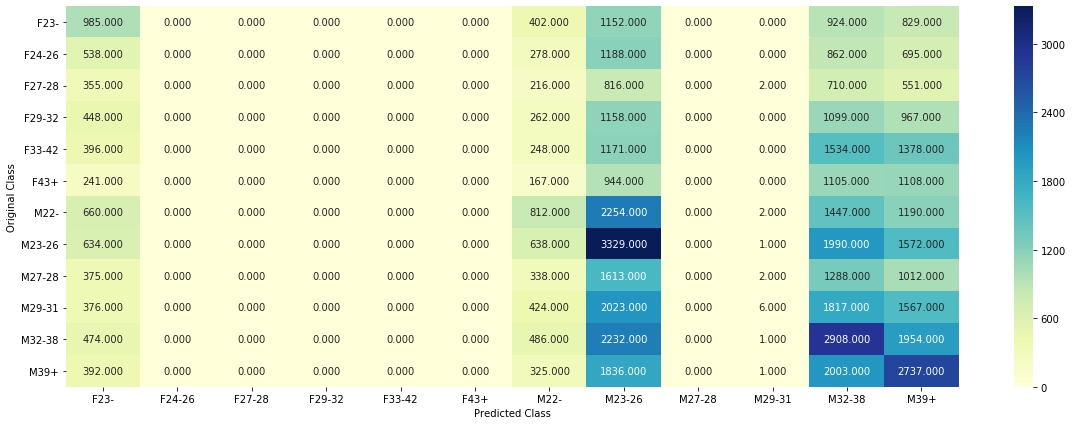

-------------------- Precision matrix (Columm Sum=1) --------------------


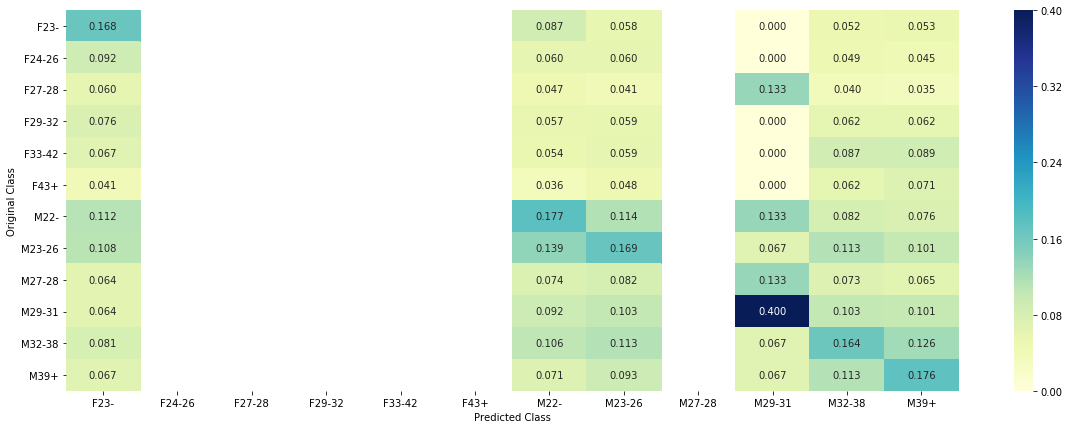

-------------------- Recall matrix (Row sum=1) --------------------


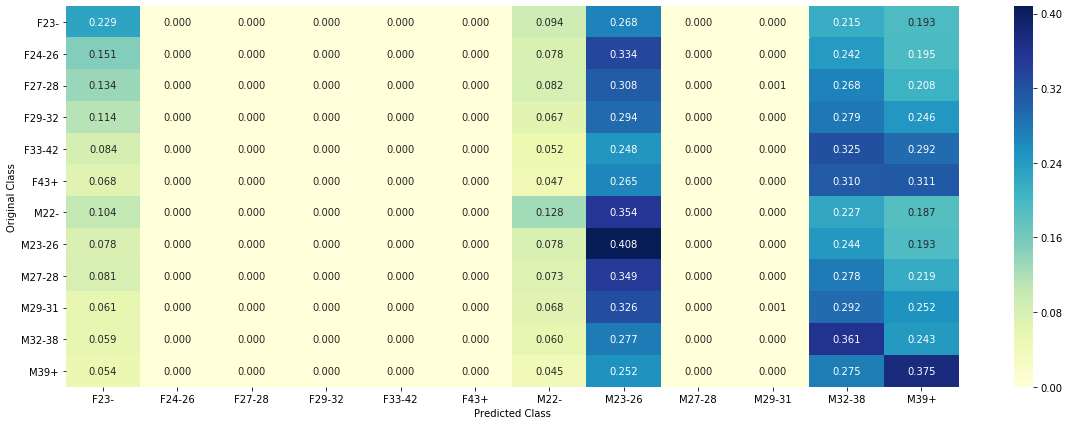

CV Log Loss : 2.3897221537620723
-------------------- Confusion matrix --------------------


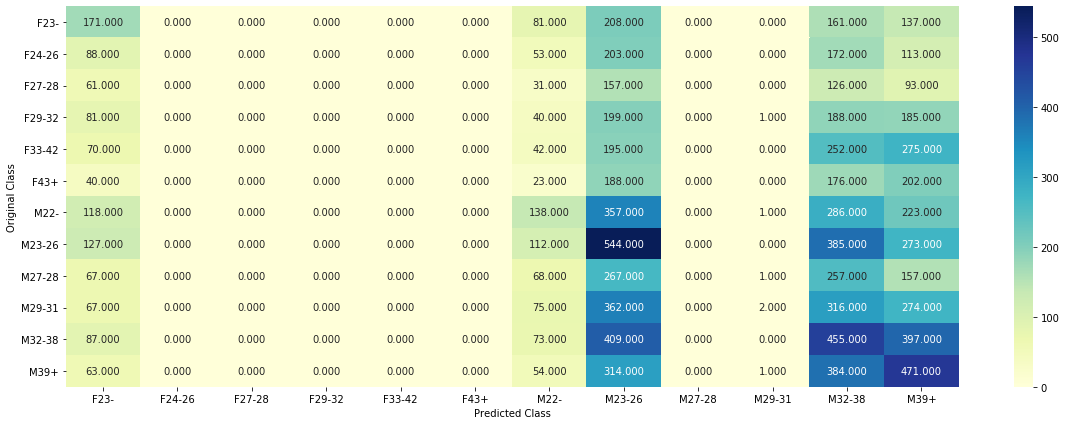

-------------------- Precision matrix (Columm Sum=1) --------------------


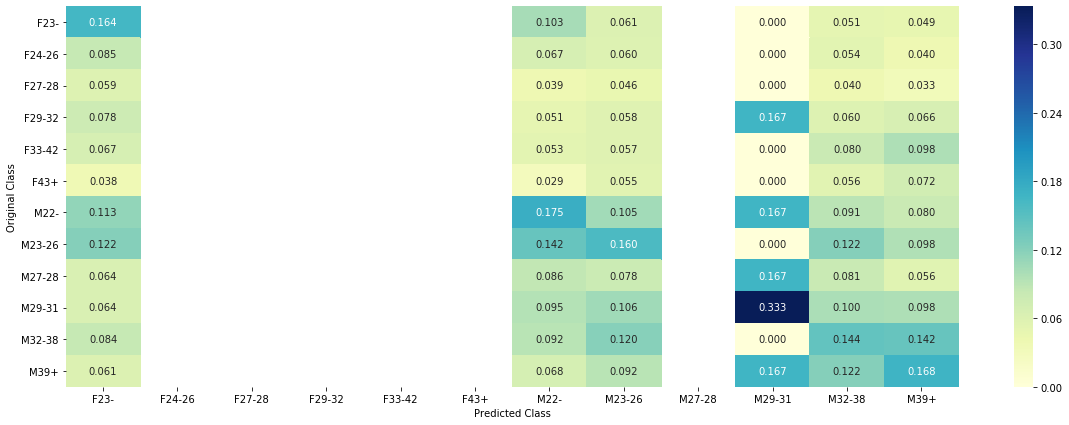

-------------------- Recall matrix (Row sum=1) --------------------


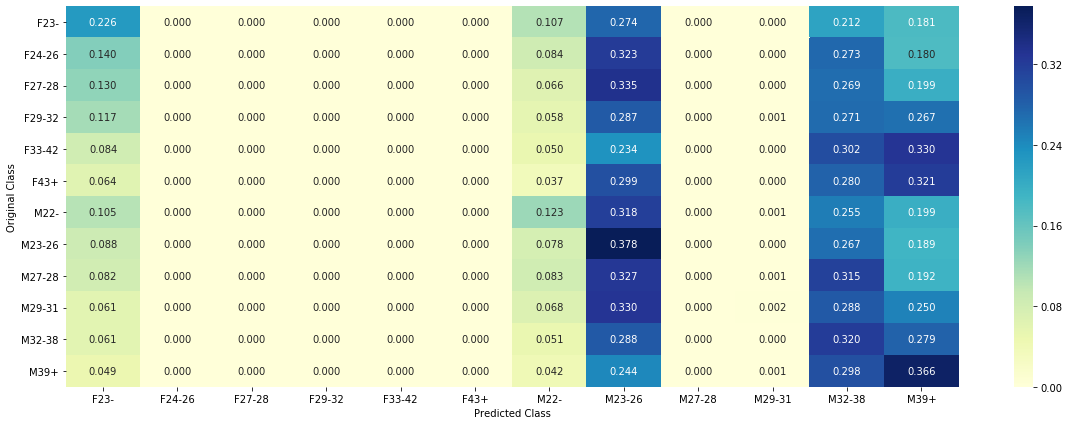

In [52]:
#Refered from AAIC Personalized Cancer Diagnosis
best_c=0.1
lr = LogisticRegression(C=best_c, class_weight='balanced', multi_class='multinomial',solver='lbfgs' ,random_state=42)
lr.fit(train_1, y_train_1)
#Using Model Calibration
lr_sig_clf = CalibratedClassifierCV(lr, method="sigmoid")
lr_sig_clf.fit(train_1, y_train_1)

lr_no_events_train_prediction=lr_sig_clf.predict_proba(train_1)
lr_no_events_cv_prediction=lr_sig_clf.predict_proba(cv_1)
lr_no_events_test_prediction=lr_sig_clf.predict_proba(test_1)

train_predicted_classes=np.argmax(lr_no_events_train_prediction, axis=1)
cv_predicted_classes=np.argmax(lr_no_events_cv_prediction, axis=1)


print("Train Log Loss :",log_loss(y_train_1, lr_no_events_train_prediction))
plot_confusion_matrix(y_train_1,train_predicted_classes)

print("="*60)

print("CV Log Loss :",log_loss(y_cv_1, lr_no_events_cv_prediction))
plot_confusion_matrix(y_cv_1,cv_predicted_classes )

**Observation**
1. Only Using Phone Brand and Model One-hot Encodings as Features the Logistic Regression Model has a CV Log-loss of 2.38
2. The Model has better precision for class M29-31 compared to other classes
3. Using only Phone Brand and Model Features for Predicting class labels is a challenge

**Saving the Best Logistic Regression Model**

In [53]:
jobl.dump(lr_sig_clf,'Saved_Models/no_events_calibrated_logistic_regression.sav')

['Saved_Models/no_events_calibrated_logistic_regression.sav']

**Saving the Test Prediction**

In [96]:
np.save('Models_Test_Predictions/lr_no_events_test_prediction',lr_no_events_test_prediction)

### 7.1.2. XG Boost

**Hyper Parameter Tuning with n_estimators**

Refered Discussions Page in the Competition: https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424
1. Parameters approach from the Discussion: {'objective':'multi:softprob','subsample':0.7,'max_depth':5,'colsample_bytree':0.7,'eval_metric': 'mlogloss',
'num_class':12,'eta':0.05}
2. Experimenting and Hyper parameter Tuning for n_estimators using the above discussion as base

In [62]:
n_est=[10,50,100,350,400,500,1000]
cv_log_error_array=[]
for i in n_est:
    x_cfl=XGBClassifier(n_estimators=i,n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
    x_cfl.fit(train_1, y_train_1)
    xgb_sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    xgb_sig_clf.fit(train_1, y_train_1)
    predict_y = xgb_sig_clf.predict_proba(cv_1)
    cv_log_error_array.append(log_loss(y_cv_1, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for n_estimator = ',n_est[i],'is',cv_log_error_array[i])

best_n_est = np.argmin(cv_log_error_array)

x_cfl=XGBClassifier(n_estimators=n_est[best_n_est],n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
x_cfl.fit(train_1, y_train_1)
xgb_sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
xgb_sig_clf.fit(train_1, y_train_1)
predict_y = xgb_sig_clf.predict_proba(train_1)

print ('For values of best n_estimator = ', n_est[best_n_est], "The train log loss is:",log_loss(y_train_1, predict_y))
predict_y = xgb_sig_clf.predict_proba(cv_1)
print('For values of best n_estimator = ', n_est[best_n_est], "The cross validation log loss is:",log_loss(y_cv_1, predict_y))

log_loss for n_estimator =  10 is 2.3983944040778136
log_loss for n_estimator =  50 is 2.3958977562585413
log_loss for n_estimator =  100 is 2.3944468106581205
log_loss for n_estimator =  350 is 2.393025753944445
log_loss for n_estimator =  400 is 2.393128500066401
log_loss for n_estimator =  500 is 2.393289009194957
log_loss for n_estimator =  1000 is 2.3946542578296754
For values of best n_estimator =  350 The train log loss is: 2.3718837052951676
For values of best n_estimator =  350 The cross validation log loss is: 2.393025753944445


**Training XG Boost with Best Hyper Parameter n_estimators=350**

Train Log Loss : 2.3718837052951676
-------------------- Confusion matrix --------------------


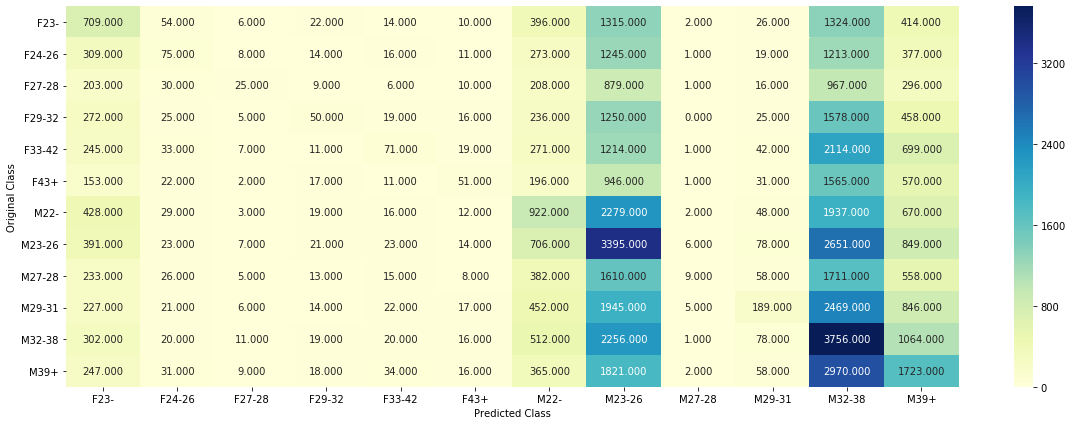

-------------------- Precision matrix (Columm Sum=1) --------------------


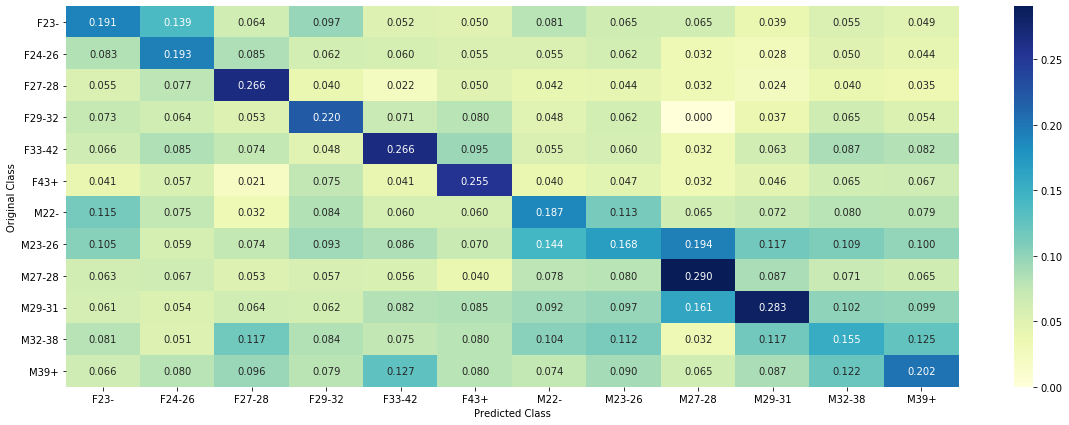

-------------------- Recall matrix (Row sum=1) --------------------


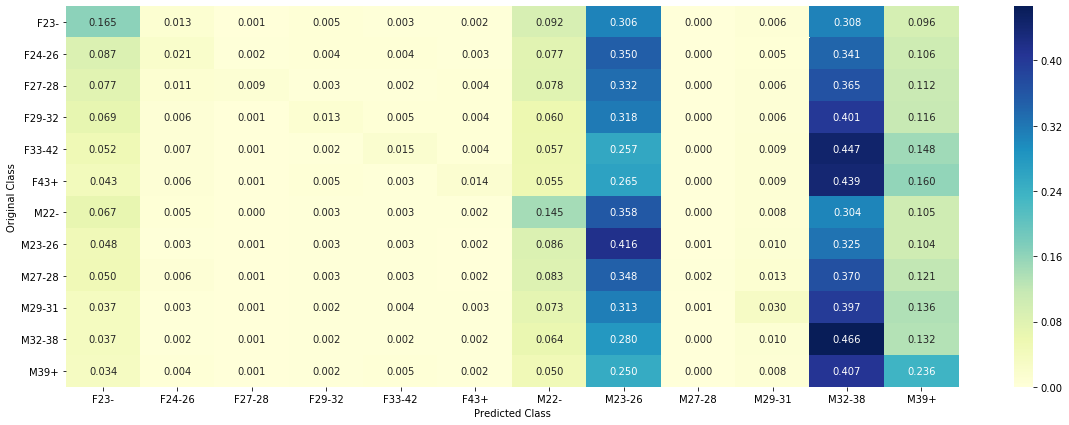

CV Log Loss : 2.393025753944445
-------------------- Confusion matrix --------------------


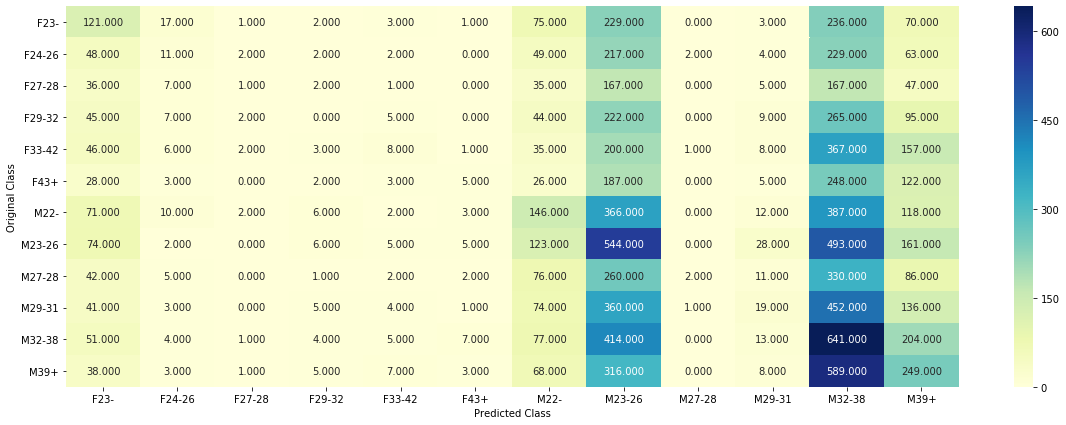

-------------------- Precision matrix (Columm Sum=1) --------------------


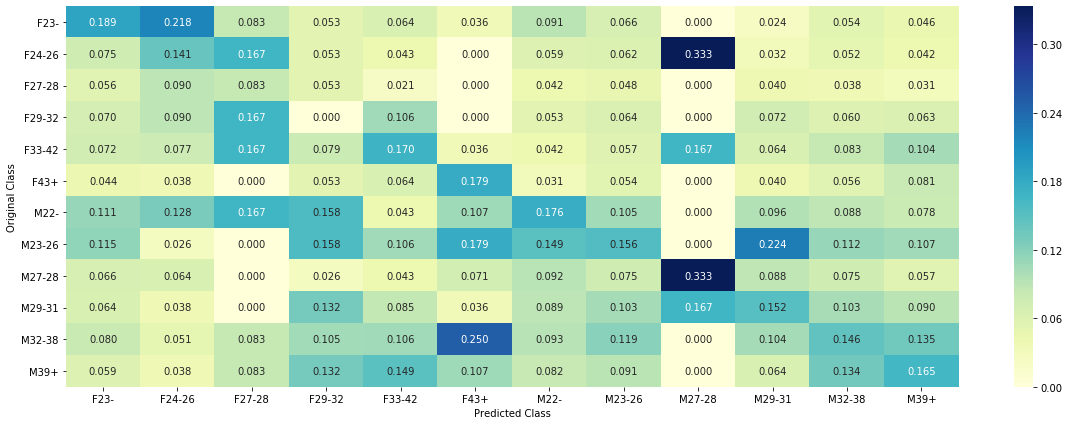

-------------------- Recall matrix (Row sum=1) --------------------


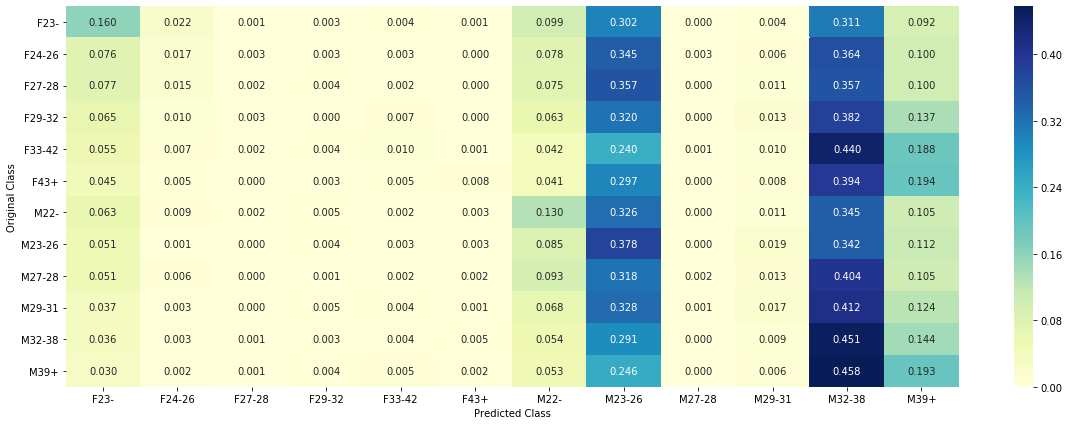

In [65]:
best_n_est=350
xgb = XGBClassifier(n_estimators=best_n_est, n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
xgb.fit(train_1, y_train_1)
#Using Model Calibration
xgb_sig_clf = CalibratedClassifierCV(xgb, method="sigmoid")
xgb_sig_clf.fit(train_1, y_train_1)

xgb_no_events_train_prediction=xgb_sig_clf.predict_proba(train_1)
xgb_no_events_cv_prediction=xgb_sig_clf.predict_proba(cv_1)
xgb_no_events_test_prediction=xgb_sig_clf.predict_proba(test_1)

xgb_train_predicted_classes=np.argmax(xgb_no_events_train_prediction, axis=1)
xgb_cv_predicted_classes=np.argmax(xgb_no_events_cv_prediction, axis=1)


print("Train Log Loss :",log_loss(y_train_1, xgb_no_events_train_prediction))
plot_confusion_matrix(y_train_1,xgb_train_predicted_classes)

print("="*60)

print("CV Log Loss :",log_loss(y_cv_1, xgb_no_events_cv_prediction))
plot_confusion_matrix(y_cv_1,xgb_cv_predicted_classes)

**Observation**
1. Only Using Phone Brand and Model One-hot Encodings as Features the XG Boost Model has a CV Log-loss of 2.393
2. The Model has better precision for class M27-28 compared to other classes
3. We can again see that using only Phone Brand and Model Features for Predicting class labels is a challenge

**Saving the Best Logistic Regression Model**

In [66]:
jobl.dump(xgb_sig_clf,'Saved_Models/no_events_calibrated_xgboost.sav')

['Saved_Models/no_events_calibrated_xgboost.sav']

**Saving Test Prediction**

In [97]:
np.save('Models_Test_Predictions/xgb_no_events_test_prediction',xgb_no_events_test_prediction)

### 7.1.3. Neural Networks

1. **Neural Network 1:** Trained on 5 different Train-CV split Data using different seed(random state) and the Predictions are Averaged
2. **Neural Network 2:** Trained on Phone Brand, Model One-Hot Encodings similar to Logistic Regression and XG Boost

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad

Using TensorFlow backend.


In [68]:
%load_ext tensorboard.notebook

In [69]:
import datetime

In [70]:
from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [71]:
%tensorboard --logdir logs_301

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12136.

### 7.1.3.1. Neural Network 1

Network Architecture Refered from: https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424

In [104]:
def model_1_1(input_shape):
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(12))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [105]:
model_1_1_arch=model_1_1(X_train_one_hot.shape[1])
model_1_1_arch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               443136    
_________________________________________________________________
p_re_lu_15 (PReLU)           (None, 256)               256       
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                16448     
_________________________________________________________________
p_re_lu_16 (PReLU)           (None, 64)                64        
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
__________

In [81]:
def get_network_1_1_models(seeds):
    """
    Takes a list of Random Seeds, splits the data into Train and CV based on Seed, Trains Neural Network 1 on
    these different Data, plots scalar graphs for each model in TensorBoard ,stores the models in a list and returns the models
    """
    model_list_1=[]
    avg_cv_loss=0
    for i in range(len(seeds)):
        train, cv, y_train, y_cv = train_test_split(X_train_one_hot, y_data,stratify=y_data,test_size=0.15,random_state=seeds[i])
        y_train_nn=np_utils.to_categorical(y_train)
        y_cv_nn=np_utils.to_categorical(y_cv)
        model=model_1_1(train.shape[1])
        logdir = os.path.join("logs_301","Model_1_1."+str(i+1))
        t_callback=TensorBoard(log_dir=logdir)
        model.fit(train, y_train_nn, batch_size=350, epochs=30, verbose=1, validation_data=(cv, y_cv_nn),callbacks=[early_stop_1,t_callback])
        model_cv_prediction=model.predict_proba(cv)
        cv_loss=log_loss(y_cv, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list_1.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=len(seeds)
    print("Average CV Loss of "+str(len(seeds))+" Runs :",avg_cv_loss)
    return model_list_1

In [77]:
#Randomly passing a list of multiples of 9 as seeds
random_seeds=[9,27,45,64,63]

In [82]:
model_list_1=get_network_1_1_models(random_seeds)

Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 3s 42us/step - loss: 2.9551 - acc: 0.0986 - val_loss: 2.4249 - val_acc: 0.1452
Epoch 2/30
63448/63448 [==============================] - 2s 34us/step - loss: 2.5174 - acc: 0.1274 - val_loss: 2.4026 - val_acc: 0.1485
Epoch 3/30
63448/63448 [==============================] - 2s 36us/step - loss: 2.4292 - acc: 0.1438 - val_loss: 2.3973 - val_acc: 0.1528
Epoch 4/30
63448/63448 [==============================] - 2s 38us/step - loss: 2.4057 - acc: 0.1512 - val_loss: 2.3947 - val_acc: 0.1537
Epoch 5/30
63448/63448 [==============================] - 2s 33us/step - loss: 2.3933 - acc: 0.1578 - val_loss: 2.3937 - val_acc: 0.1537
Epoch 6/30
63448/63448 [==============================] - 2s 33us/step - loss: 2.3847 - acc: 0.1594 - val_loss: 2.3930 - val_acc: 0.1550
Epoch 7/30
63448/63448 [==============================] - 2s 32us/step - loss: 2.3799 - acc: 0.1610 - val_loss: 2.3920 - val_acc

Epoch 11/30
63448/63448 [==============================] - 2s 36us/step - loss: 2.3604 - acc: 0.1682 - val_loss: 2.3963 - val_acc: 0.1521
Epoch 12/30
63448/63448 [==============================] - 2s 36us/step - loss: 2.3584 - acc: 0.1701 - val_loss: 2.3968 - val_acc: 0.1534
CV Log Loss of Best Weights Model in Current Run:  2.3884129705701205
Average CV Loss of 5 Runs : 2.3916388673900313


#### TensorBoard Plots

Not Able to Get Histograms for this Neural Network as the inputs are One-Hot Encoded Sparse and getting Value Error while Running the Model. So Plotting only Scalar Graphs

In [83]:
from IPython.display import Image

**Models**

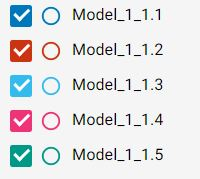

In [84]:
Image('TensorBoard_Graphs/Model_1_1/Models.jpg')

**Train Accuracy**

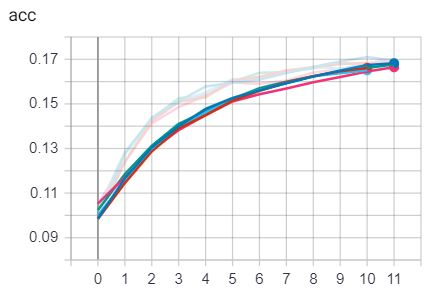

In [85]:
Image('TensorBoard_Graphs/Model_1_1/Train_Accuracy.jpg')

**Train Loss**

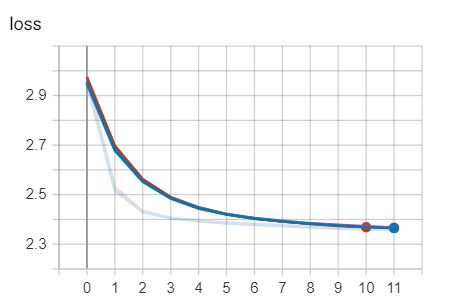

In [86]:
Image('TensorBoard_Graphs/Model_1_1/Train_Loss.jpg')

**Validation Accuracy**

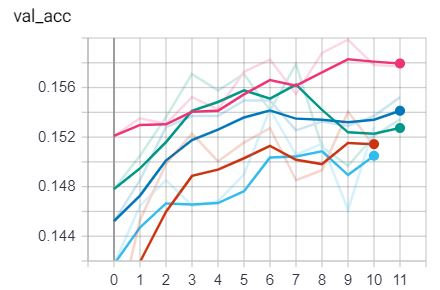

In [87]:
Image('TensorBoard_Graphs/Model_1_1/Val_Accuracy.jpg')

**Validation Loss**

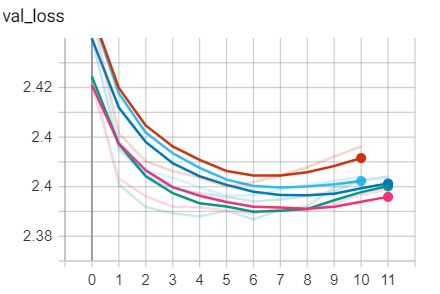

In [88]:
Image('TensorBoard_Graphs/Model_1_1/Val_Loss.jpg')

**Average Train Prediction**

In [218]:
train_pred_avg_1_1=np.zeros((train_1.shape[0],12))

In [219]:
for i in range(len(model_list_1)):
    train_pred=model_list_1[i].predict_proba(train_1)
    train_pred_avg_1_1+=train_pred
train_pred_avg_1_1/=len(model_list_1)

Train Average Log-Loss:  2.3569682643628562
-------------------- Confusion matrix --------------------


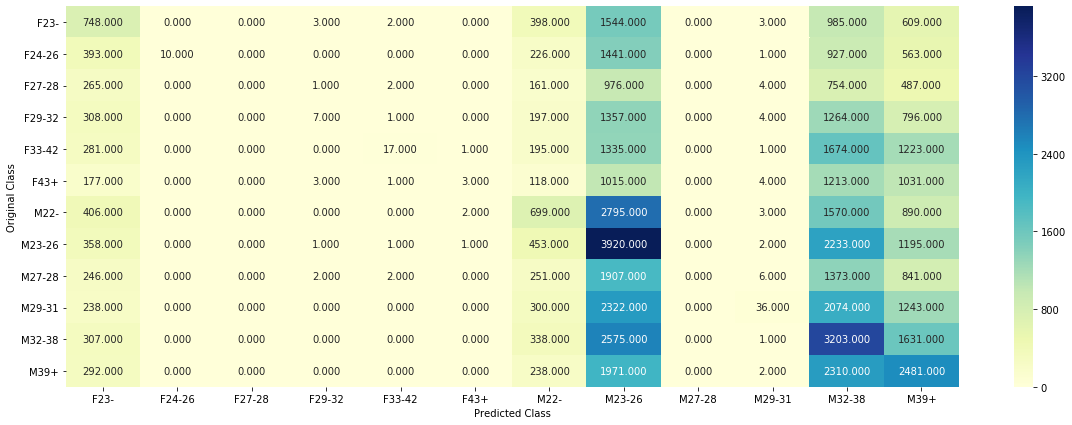

-------------------- Precision matrix (Columm Sum=1) --------------------


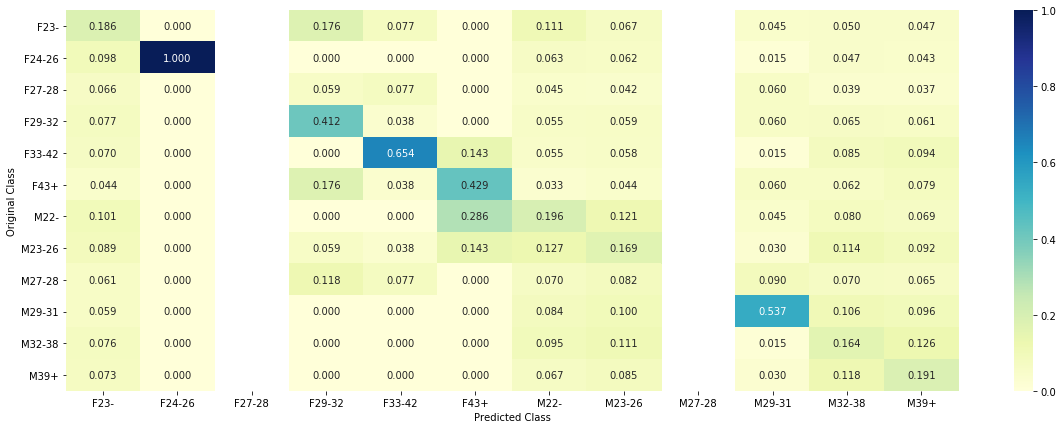

-------------------- Recall matrix (Row sum=1) --------------------


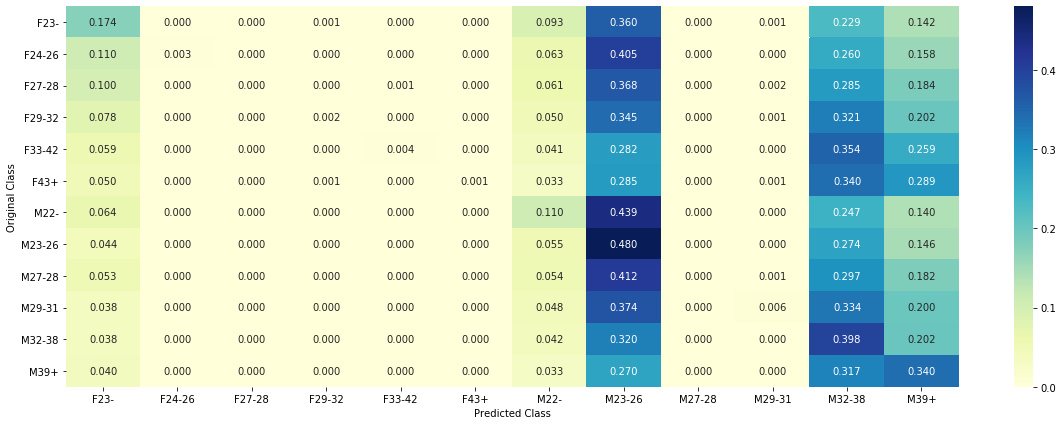

In [220]:
print("Train Average Log-Loss: ",log_loss(y_train_1, train_pred_avg_1_1))
no_events_nn_1_avg_train_predicted_classes=np.argmax(train_pred_avg_1_1, axis=1)
plot_confusion_matrix(y_train_1,no_events_nn_1_avg_train_predicted_classes)

**Average CV Prediction**

In [92]:
cv_pred_avg_1_1=np.zeros((cv_1.shape[0],12))

In [93]:
for i in range(len(model_list_1)):
    cv_pred=model_list_1[i].predict_proba(cv_1)
    cv_pred_avg_1_1+=cv_pred
cv_pred_avg_1_1/=len(model_list_1)

CV Average Log-Loss:  2.3550172618827174
-------------------- Confusion matrix --------------------


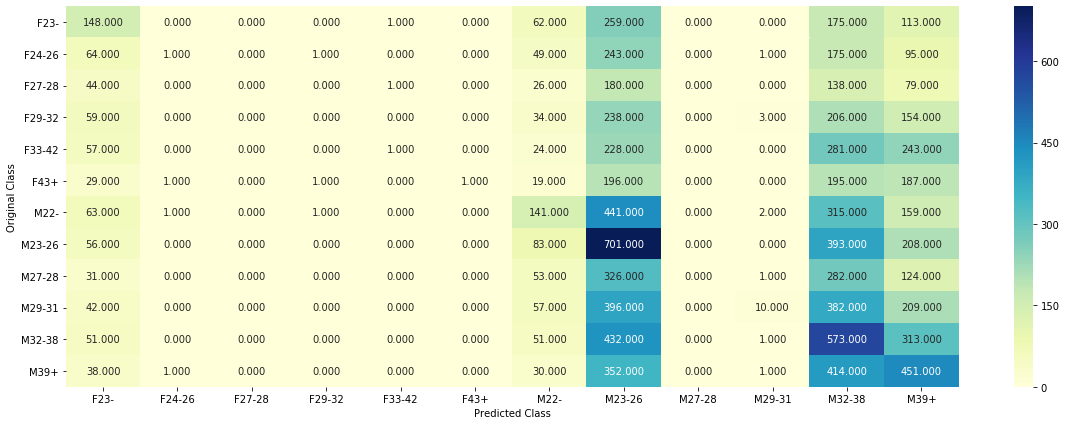

-------------------- Precision matrix (Columm Sum=1) --------------------


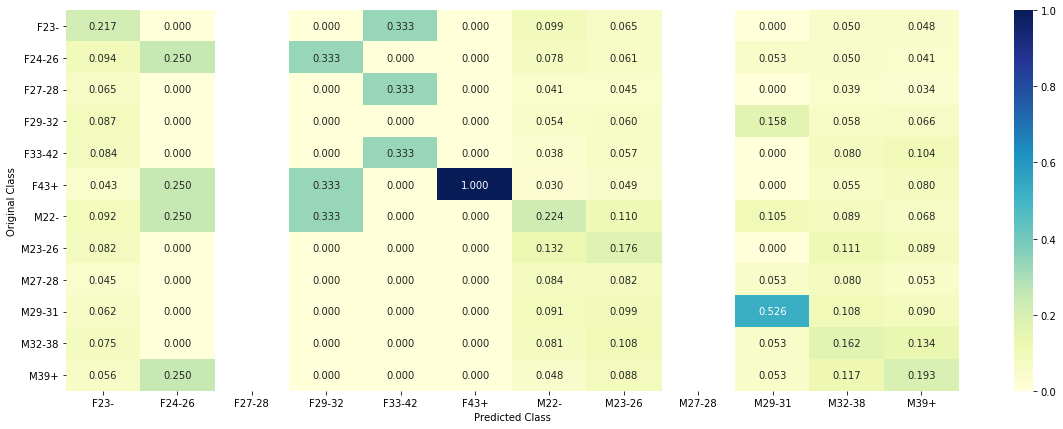

-------------------- Recall matrix (Row sum=1) --------------------


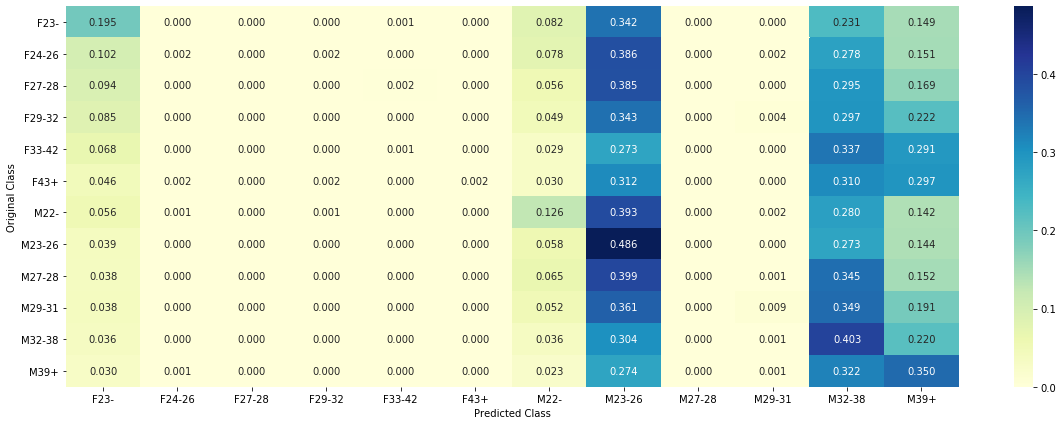

In [95]:
print("CV Average Log-Loss: ",log_loss(y_cv_1, cv_pred_avg_1_1))
no_events_nn_1_avg_cv_predicted_classes=np.argmax(cv_pred_avg_1_1, axis=1)
plot_confusion_matrix(y_cv_1,no_events_nn_1_avg_cv_predicted_classes)

**Observtion:**
Avearged Neural Network Model 1 has good Precision for Class F43+

**Average Test Predictions**

In [98]:
test_pred_avg_1_1=np.zeros((test_1.shape[0],12))

In [99]:
for i in range(len(model_list_1)):
    test_pred=model_list_1[i].predict_proba(test_1)
    test_pred_avg_1_1+=test_pred
test_pred_avg_1_1/=len(model_list_1)

**Saving Model Weights**

In [101]:
for i in range(len(model_list_1)):
    model_list_1[i].save('Saved_Models/No_Events/Neural_Network_1/Model_1_1_'+str(i+1)+'.h5')    

**Saving Test Prediction**

In [102]:
np.save('Models_Test_Predictions/nn_1_no_events_avg_test_prediction',test_pred_avg_1_1)

### 7.1.3.2. Neural Network 2

Model Architecture Refered From Competition Discussion: https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424

In [106]:
def create_model_1_2(input_dim,output_dim, learRate=0.0025):
    
    model = Sequential()
    model.add(Dense(500, input_shape=(input_dim,), init='uniform'))
    model.add(PReLU(init='zero'))
    model.add(Dropout(0.82))
    model.add(Dense(output_dim, init='uniform'))
    model.add(Activation('softmax'))
    opt = Adagrad(lr=learRate, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [108]:
model_1_2=create_model_1_2(train_1.shape[1],12)
model_1_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 500)               865500    
_________________________________________________________________
p_re_lu_18 (PReLU)           (None, 500)               500       
_________________________________________________________________
dropout_18 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 12)                6012      
_________________________________________________________________
activation_10 (Activation)   (None, 12)                0         
Total params: 872,012
Trainable params: 872,012
Non-trainable params: 0
_________________________________________________________________


In [109]:
y_train_nn_2=np_utils.to_categorical(y_train_1)
y_cv_nn_2=np_utils.to_categorical(y_cv_1)

In [110]:
logdir = os.path.join("logs_301","Model_1_2")
t_callback_1=TensorBoard(log_dir=logdir)

In [112]:
model_1_2.fit(train_1, y_train_nn_2, batch_size=350, epochs=30, verbose=1, validation_data=(cv_1, y_cv_nn_2),callbacks=[early_stop_1,t_callback_1])

Train on 63448 samples, validate on 11197 samples
Epoch 1/30
63448/63448 [==============================] - 2s 34us/step - loss: 2.4330 - acc: 0.1357 - val_loss: 2.4162 - val_acc: 0.1445
Epoch 2/30
63448/63448 [==============================] - 2s 29us/step - loss: 2.4146 - acc: 0.1409 - val_loss: 2.4103 - val_acc: 0.1445
Epoch 3/30
63448/63448 [==============================] - 2s 28us/step - loss: 2.4093 - acc: 0.1447 - val_loss: 2.4067 - val_acc: 0.1472
Epoch 4/30
63448/63448 [==============================] - 2s 28us/step - loss: 2.4058 - acc: 0.1454 - val_loss: 2.4043 - val_acc: 0.1483
Epoch 5/30
63448/63448 [==============================] - 2s 28us/step - loss: 2.4038 - acc: 0.1485 - val_loss: 2.4024 - val_acc: 0.1487
Epoch 6/30
63448/63448 [==============================] - 2s 28us/step - loss: 2.4011 - acc: 0.1487 - val_loss: 2.4009 - val_acc: 0.1499
Epoch 7/30
63448/63448 [==============================] - 2s 28us/step - loss: 2.3996 - acc: 0.1505 - val_loss: 2.3998 - val_acc

**TensorBoard Plots**

**Train Accuracy**

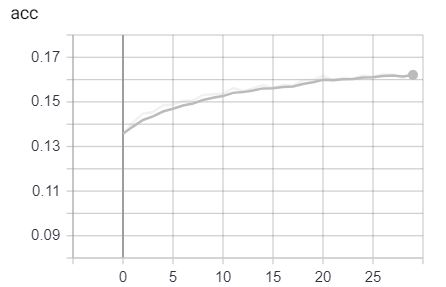

In [113]:
Image('TensorBoard_Graphs/Model_1_2/Train_Accuracy.jpg')

**Train Loss**

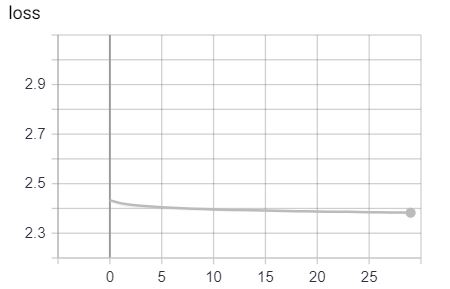

In [115]:
Image('TensorBoard_Graphs/Model_1_2/Train_Loss.jpg')

**Validation Accuracy**

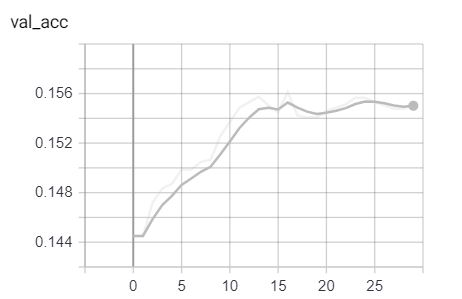

In [116]:
Image('TensorBoard_Graphs/Model_1_2/Val_Accuracy.jpg')

**Validation Loss**

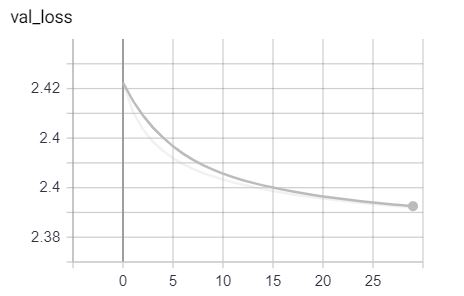

In [117]:
Image('TensorBoard_Graphs/Model_1_2/Val_Loss.jpg')

**Train Prediction**

Train Log-Loss:  2.3757640672649174
-------------------- Confusion matrix --------------------


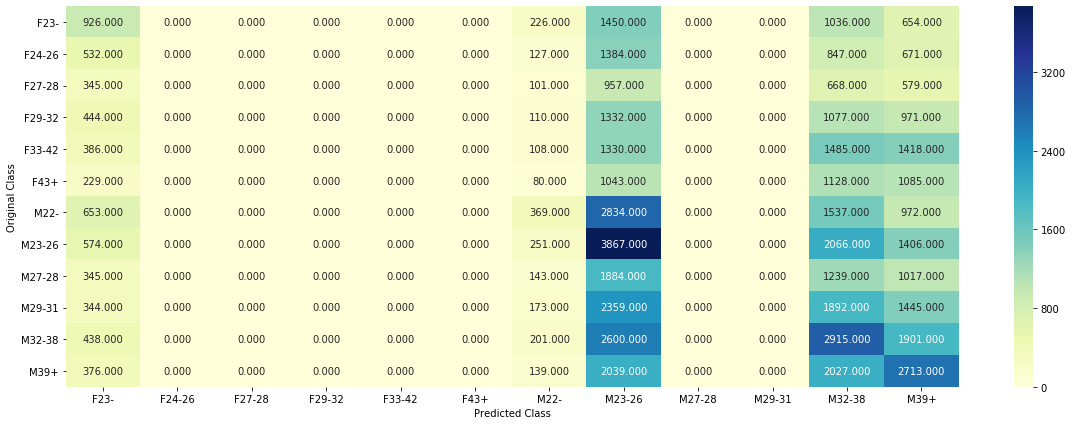

-------------------- Precision matrix (Columm Sum=1) --------------------


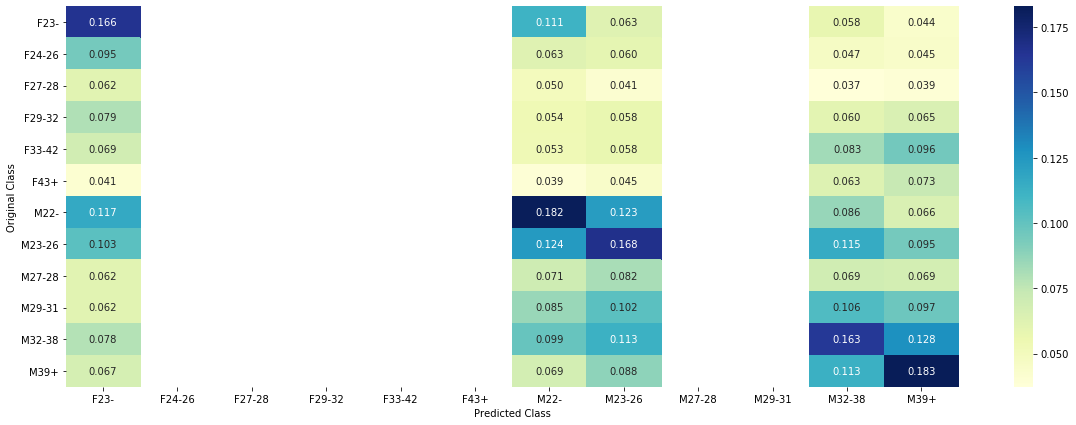

-------------------- Recall matrix (Row sum=1) --------------------


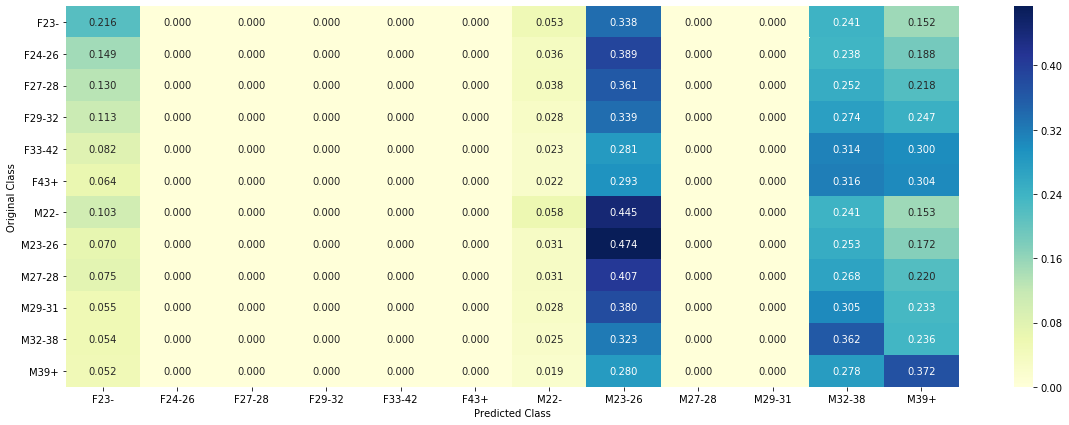

In [221]:
train_pred_1_2=model_1_2.predict_proba(train_1)
print("Train Log-Loss: ",log_loss(y_train_1, train_pred_1_2))
no_events_nn_2_train_predicted_classes=np.argmax(train_pred_1_2, axis=1)
plot_confusion_matrix(y_train_1,no_events_nn_2_train_predicted_classes)

**CV Prediction**

CV Log-Loss:  2.3909881615453483
-------------------- Confusion matrix --------------------


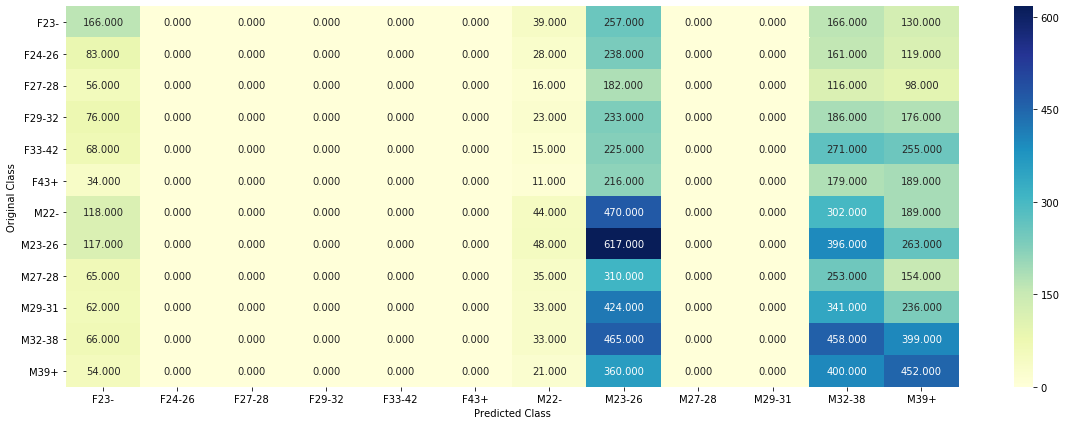

-------------------- Precision matrix (Columm Sum=1) --------------------


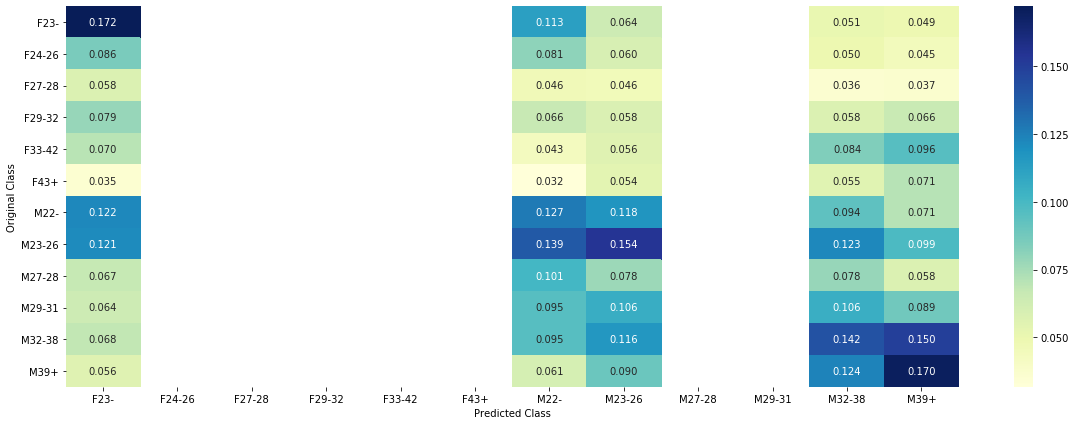

-------------------- Recall matrix (Row sum=1) --------------------


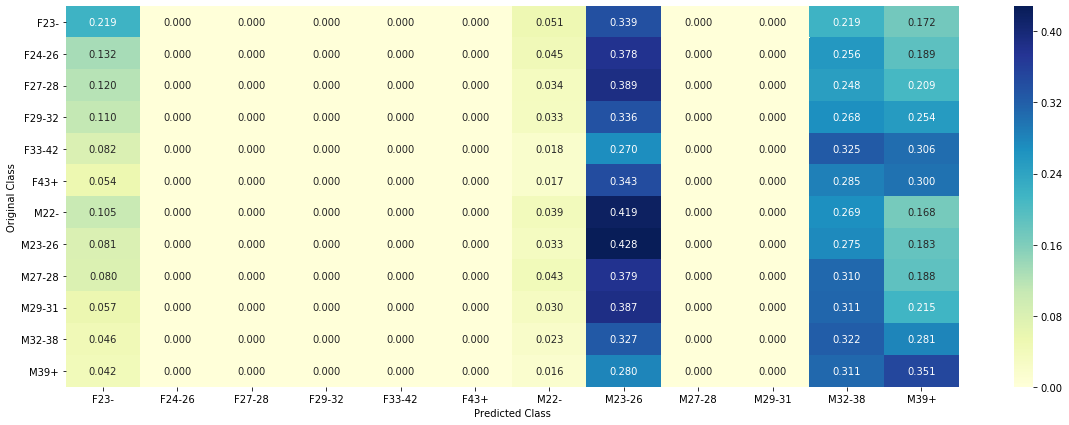

In [118]:
cv_pred_1_2=model_1_2.predict_proba(cv_1)
print("CV Log-Loss: ",log_loss(y_cv_1, cv_pred_1_2))
no_events_nn_2_cv_predicted_classes=np.argmax(cv_pred_1_2, axis=1)
plot_confusion_matrix(y_cv_1,no_events_nn_2_cv_predicted_classes)

**Test Prediction**

In [119]:
test_pred_1_2=model_1_2.predict_proba(test_1)

**Saving Model**

In [120]:
model_1_2.save('Saved_Models/No_Events/Model_1_2.h5')

**Saving Test Prediction**

In [121]:
np.save('Models_Test_Predictions/nn_2_no_events_test_prediction',test_pred_1_2)

### 7.2. Devices with Events

**Train, CV Split**

In [122]:
y_data_events=events_train_data['Class'].values

In [125]:
train_2, cv_2, y_train_2, y_cv_2 = train_test_split(X_train_events_one_hot_1, y_data_events,stratify=y_data_events,test_size=0.2,random_state=9)
test_2=X_test_events_one_hot_1

In [126]:
y_train_nn_3=np_utils.to_categorical(y_train_2)
y_cv_nn_3=np_utils.to_categorical(y_cv_2)

### 7.2.1. Neural Networks

**Approach**
1. Train 2 Neural Architectures on Events Feature Matrix
2. Train Each Model for 20 Runs and take avarage of predictions

### 7.2.1.1. Neural Network 1

Network Architecture Refered from: https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424

The Dropout in the input Layer adds value and variability for predictions and is helpful for taking avaerage of predictions

In [129]:
def model_2_1(input_dim,output_dim):
    model = Sequential()
    model.add(Dropout(0.15, input_shape=(input_dim,)))
    model.add(Dense(240, init='uniform'))
    model.add(PReLU(init='zero'))
    model.add(Dropout(0.8))
    model.add(Dense(240, init='uniform'))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.35))
    model.add(Dense(260, init='uniform'))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.40))
    model.add(Dense(output_dim, init='uniform'))
    model.add(Activation('softmax'))

    opt = Adagrad(lr=0.008, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [131]:
model_2_1_arch=model_2_1(X_train_events_one_hot_1.shape[1],12)
model_2_1_arch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_19 (Dropout)         (None, 21566)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 240)               5176080   
_________________________________________________________________
p_re_lu_19 (PReLU)           (None, 240)               240       
_________________________________________________________________
dropout_20 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 240)               57840     
_________________________________________________________________
p_re_lu_20 (PReLU)           (None, 240)               240       
_________________________________________________________________
dropout_21 (Dropout)         (None, 240)               0         
__________

The Function Takes number of models as input, and trains the required number of models, plots scalar graph for each model in Tensor Board, prints the avg cv loss of all the models, stores the model in a list and returns it

In [132]:
def get_network_2_1_models(n_models):
    """
    Takes number of models,  Trains Neural Network 1 for n_model times,
    stores the models in a list and returns the models
    """
    model_list_2=[]
    avg_cv_loss=0
    for i in range(n_models):
        model=model_2_1(train_2.shape[1],12)
        logdir = os.path.join("logs_301","Model_2_1."+str(i+1))
        t_callback=TensorBoard(log_dir=logdir)
        model.fit(train_2, y_train_nn_3, batch_size=149, epochs=20, verbose=1, validation_data=(cv_2, y_cv_nn_3),callbacks=[early_stop_1,t_callback])
        model_cv_prediction=model.predict_proba(cv_2)
        cv_loss=log_loss(y_cv_2, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list_2.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=n_models
    print("Average CV Loss of "+str(n_models)+" Runs :",avg_cv_loss)
    return model_list_2

In [133]:
model_list_2=get_network_2_1_models(20)

Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 5s 282us/step - loss: 2.2853 - acc: 0.1828 - val_loss: 2.1414 - val_acc: 0.2342
Epoch 2/20
18647/18647 [==============================] - 5s 257us/step - loss: 2.1340 - acc: 0.2442 - val_loss: 2.0536 - val_acc: 0.2801
Epoch 3/20
18647/18647 [==============================] - 5s 260us/step - loss: 2.0675 - acc: 0.2667 - val_loss: 2.0006 - val_acc: 0.3016
Epoch 4/20
18647/18647 [==============================] - 5s 262us/step - loss: 2.0264 - acc: 0.2811 - val_loss: 1.9764 - val_acc: 0.3080
Epoch 5/20
18647/18647 [==============================] - 5s 257us/step - loss: 1.9907 - acc: 0.2939 - val_loss: 1.9640 - val_acc: 0.3117
Epoch 6/20
18647/18647 [==============================] - 5s 257us/step - loss: 1.9581 - acc: 0.3037 - val_loss: 1.9457 - val_acc: 0.3147
Epoch 7/20
18647/18647 [==============================] - 5s 259us/step - loss: 1.9380 - acc: 0.3111 - val_loss: 1.9424 - v

18647/18647 [==============================] - 5s 260us/step - loss: 1.7571 - acc: 0.3691 - val_loss: 1.9212 - val_acc: 0.3237
Epoch 20/20
18647/18647 [==============================] - 5s 259us/step - loss: 1.7487 - acc: 0.3737 - val_loss: 1.9185 - val_acc: 0.3258
CV Log Loss of Best Weights Model in Current Run:  1.9199870003689783
Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 5s 286us/step - loss: 2.2787 - acc: 0.1903 - val_loss: 2.1471 - val_acc: 0.2366
Epoch 2/20
18647/18647 [==============================] - 5s 259us/step - loss: 2.1237 - acc: 0.2486 - val_loss: 2.0452 - val_acc: 0.2861
Epoch 3/20
18647/18647 [==============================] - 5s 258us/step - loss: 2.0598 - acc: 0.2717 - val_loss: 2.0282 - val_acc: 0.2870
Epoch 4/20
18647/18647 [==============================] - 5s 261us/step - loss: 2.0153 - acc: 0.2766 - val_loss: 1.9824 - val_acc: 0.3108
Epoch 5/20
18647/18647 [==============================] - 5s 25

18647/18647 [==============================] - 5s 259us/step - loss: 1.8419 - acc: 0.3430 - val_loss: 1.9196 - val_acc: 0.3230
Epoch 14/20
18647/18647 [==============================] - 5s 259us/step - loss: 1.8182 - acc: 0.3508 - val_loss: 1.9223 - val_acc: 0.3252
Epoch 15/20
18647/18647 [==============================] - 5s 266us/step - loss: 1.8137 - acc: 0.3534 - val_loss: 1.9138 - val_acc: 0.3245
Epoch 16/20
18647/18647 [==============================] - 5s 259us/step - loss: 1.7978 - acc: 0.3560 - val_loss: 1.9127 - val_acc: 0.3230
Epoch 17/20
18647/18647 [==============================] - 5s 260us/step - loss: 1.7778 - acc: 0.3596 - val_loss: 1.9169 - val_acc: 0.3260
Epoch 18/20
18647/18647 [==============================] - 5s 260us/step - loss: 1.7763 - acc: 0.3635 - val_loss: 1.9165 - val_acc: 0.3275
Epoch 19/20
18647/18647 [==============================] - 5s 260us/step - loss: 1.7614 - acc: 0.3680 - val_loss: 1.9202 - val_acc: 0.3226
Epoch 20/20
18647/18647 [==============

18647/18647 [==============================] - 5s 264us/step - loss: 1.9200 - acc: 0.3171 - val_loss: 1.9373 - val_acc: 0.3185
Epoch 9/20
18647/18647 [==============================] - 5s 261us/step - loss: 1.8982 - acc: 0.3219 - val_loss: 1.9308 - val_acc: 0.3248
Epoch 10/20
18647/18647 [==============================] - 5s 262us/step - loss: 1.8862 - acc: 0.3257 - val_loss: 1.9305 - val_acc: 0.3196
Epoch 11/20
18647/18647 [==============================] - 5s 262us/step - loss: 1.8673 - acc: 0.3352 - val_loss: 1.9204 - val_acc: 0.3224
Epoch 12/20
18647/18647 [==============================] - 5s 265us/step - loss: 1.8553 - acc: 0.3379 - val_loss: 1.9213 - val_acc: 0.3252
Epoch 13/20
18647/18647 [==============================] - 5s 262us/step - loss: 1.8392 - acc: 0.3409 - val_loss: 1.9216 - val_acc: 0.3293
Epoch 14/20
18647/18647 [==============================] - 5s 270us/step - loss: 1.8173 - acc: 0.3460 - val_loss: 1.9241 - val_acc: 0.3258
Epoch 15/20
18647/18647 [===============

**TensorBoard Plots**

As there are 20 Models, Showing Plots for 7 Models at a Time to have a better visualization of Plots

**Models 1-7**

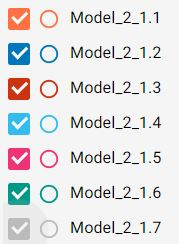

In [134]:
Image('TensorBoard_Graphs/Model_2_1/Models_1-7.jpg')

**Models 1-7 Train Accuracy**

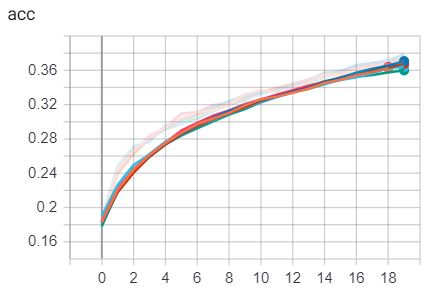

In [135]:
Image('TensorBoard_Graphs/Model_2_1/Models_1-7_Train_Accuracy.jpg')

**Models 1-7 Train Loss**

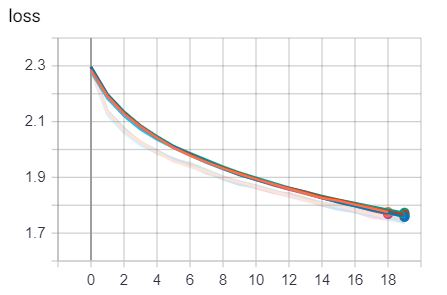

In [136]:
Image('TensorBoard_Graphs/Model_2_1/Models_1-7_Train_Loss.jpg')

**Models 1-7 Validation Accuracy**

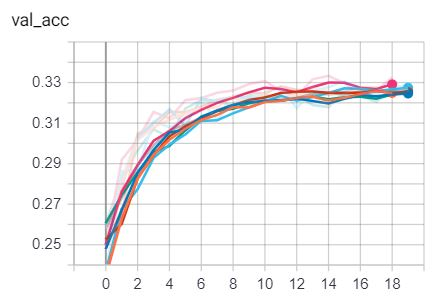

In [137]:
Image('TensorBoard_Graphs/Model_2_1/Models_1-7_Val_Accuracy.jpg')

**Models 1-7 Validation Loss**

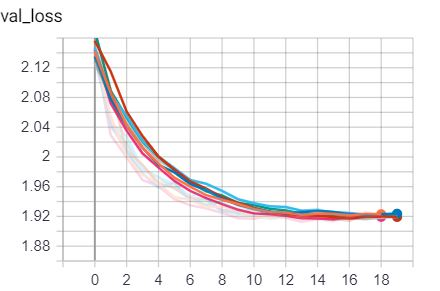

In [138]:
Image('TensorBoard_Graphs/Model_2_1/Models_1-7_Val_Loss.jpg')

**Models 8-14**

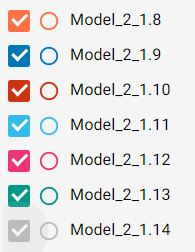

In [139]:
Image('TensorBoard_Graphs/Model_2_1/Models_8-14.jpg')

**Models 8-14 Train Accuracy**

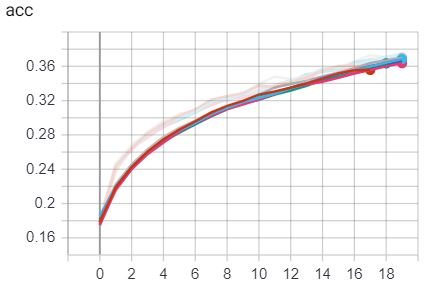

In [141]:
Image('TensorBoard_Graphs/Model_2_1/Models_8-14_Train_Accuracy.jpg')

**Models 8-14 Train Loss**

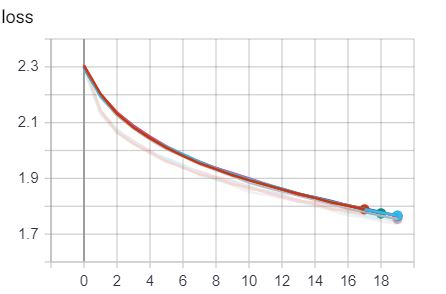

In [142]:
Image('TensorBoard_Graphs/Model_2_1/Models_8-14_Train_Loss.jpg')

**Models 8-14 Validation Accuracy**

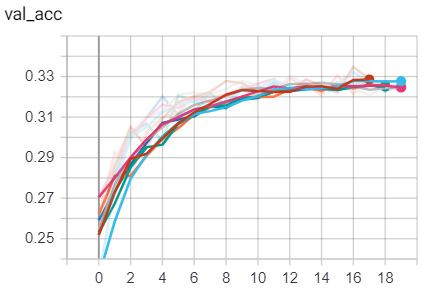

In [143]:
Image('TensorBoard_Graphs/Model_2_1/Models_8-14_Val_Accuracy.jpg')

**Models 8-14 Validation Loss**

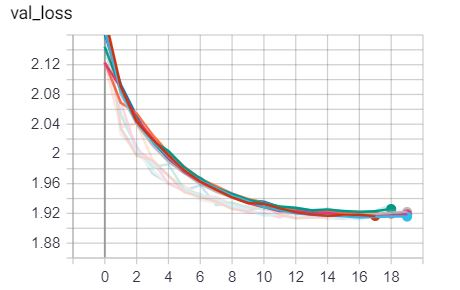

In [144]:
Image('TensorBoard_Graphs/Model_2_1/Models_8-14_Val_Loss.jpg')

**Models 15-20**

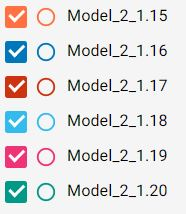

In [145]:
Image('TensorBoard_Graphs/Model_2_1/Models_15-20.jpg')

**Models 15-20 Train Accuracy**

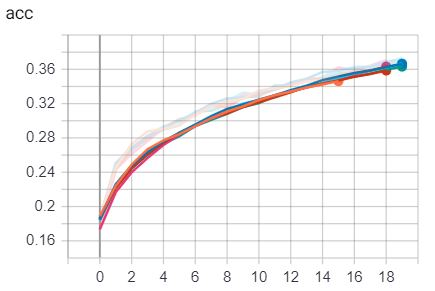

In [146]:
Image('TensorBoard_Graphs/Model_2_1/Models_15-20_Train_Accuracy.jpg')

**Models 15-20 Train Loss**

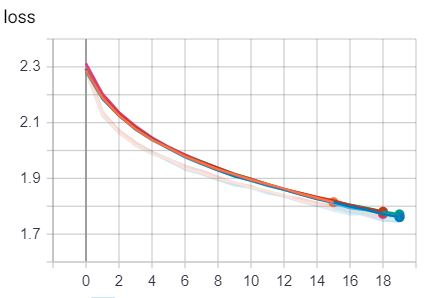

In [147]:
Image('TensorBoard_Graphs/Model_2_1/Models_15-20_Train_Loss.jpg')

**Models 15-20 Validation Accuracy**

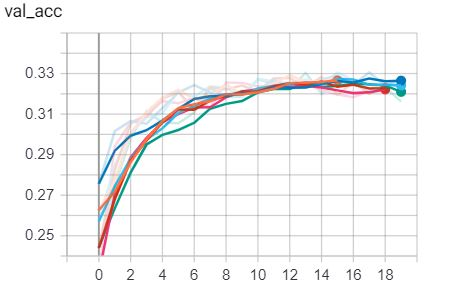

In [149]:
Image('TensorBoard_Graphs/Model_2_1/Models_15-20_Val_Accuracy.jpg')

**Models 15-20 Validation Loss**

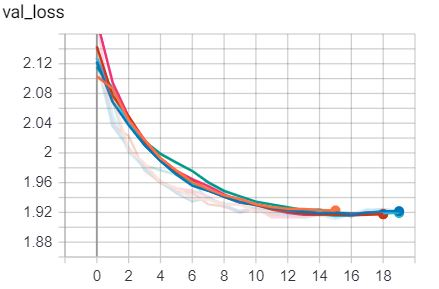

In [150]:
Image('TensorBoard_Graphs/Model_2_1/Models_15-20_Val_Loss.jpg')

**Average Train Prediction**

In [222]:
train_pred_avg_2_1=np.zeros((train_2.shape[0],12))

In [223]:
for i in range(len(model_list_2)):
    train_pred=model_list_2[i].predict_proba(train_2)
    train_pred_avg_2_1+=train_pred
train_pred_avg_2_1/=len(model_list_2)

Train Average Log-Loss:  1.5669842116318022
-------------------- Confusion matrix --------------------


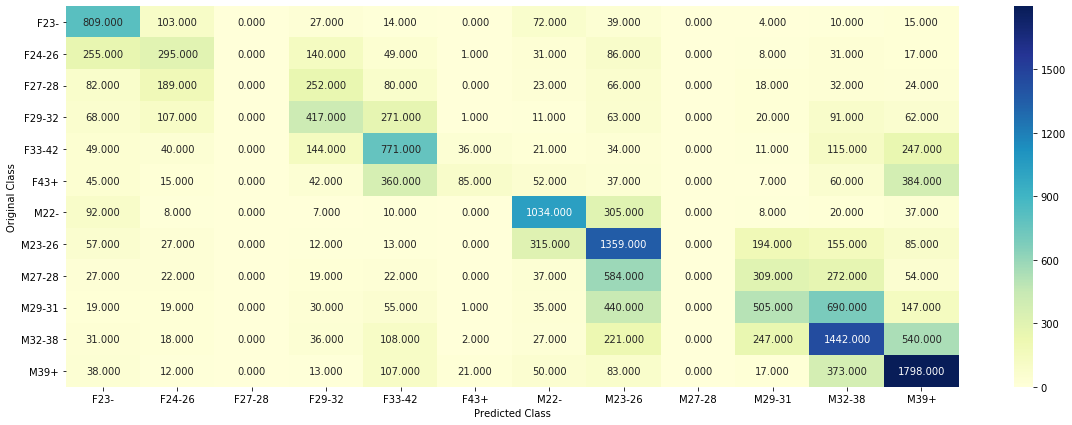

-------------------- Precision matrix (Columm Sum=1) --------------------


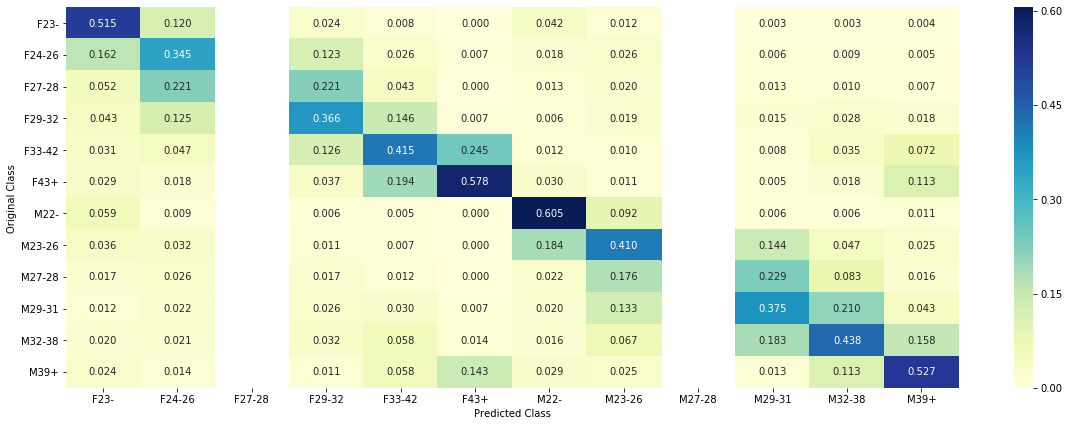

-------------------- Recall matrix (Row sum=1) --------------------


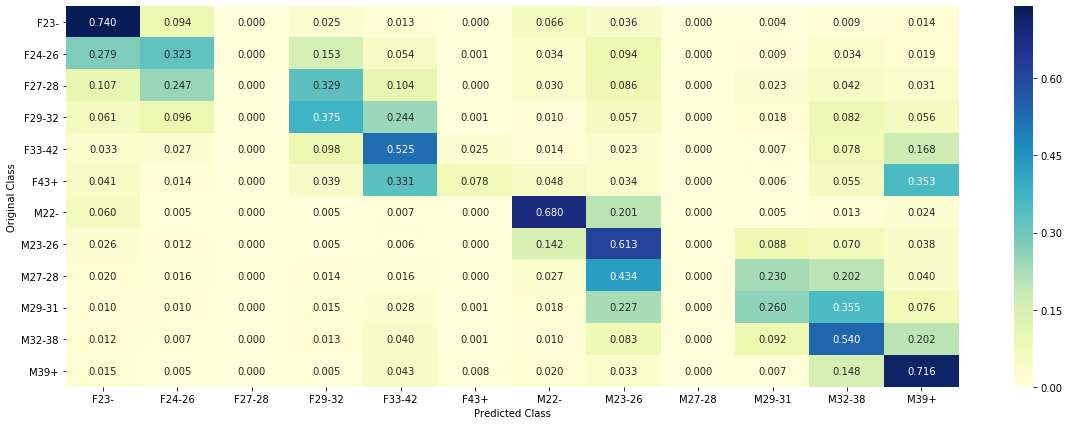

In [224]:
print("Train Average Log-Loss: ",log_loss(y_train_2, train_pred_avg_2_1))
events_nn_1_avg_train_predicted_classes=np.argmax(train_pred_avg_2_1, axis=1)
plot_confusion_matrix(y_train_2,events_nn_1_avg_train_predicted_classes)

**Average CV Prediction**

In [151]:
cv_pred_avg_2_1=np.zeros((cv_2.shape[0],12))

In [152]:
for i in range(len(model_list_2)):
    cv_pred=model_list_2[i].predict_proba(cv_2)
    cv_pred_avg_2_1+=cv_pred
cv_pred_avg_2_1/=len(model_list_2)

CV Average Log-Loss:  1.904683264114659
-------------------- Confusion matrix --------------------


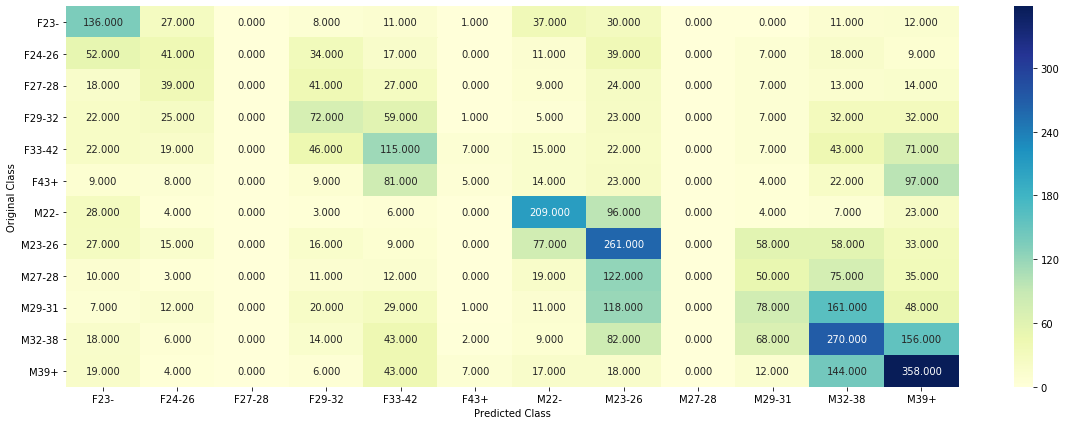

-------------------- Precision matrix (Columm Sum=1) --------------------


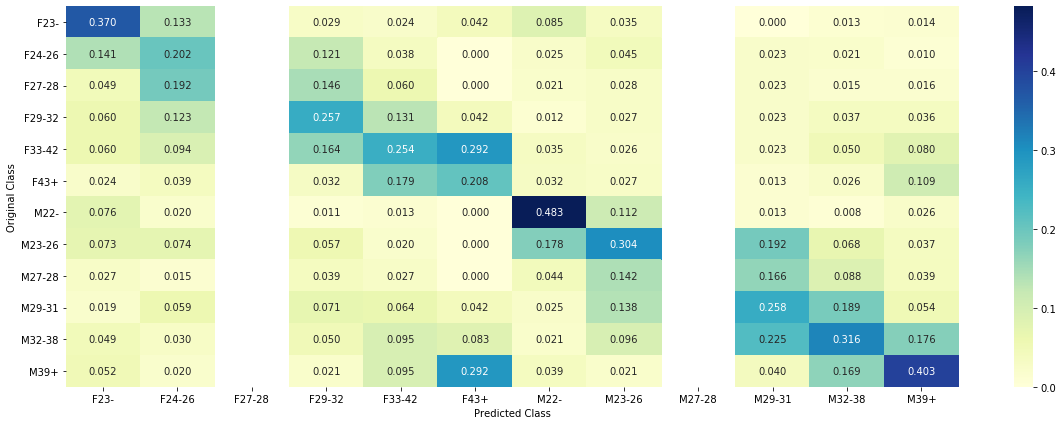

-------------------- Recall matrix (Row sum=1) --------------------


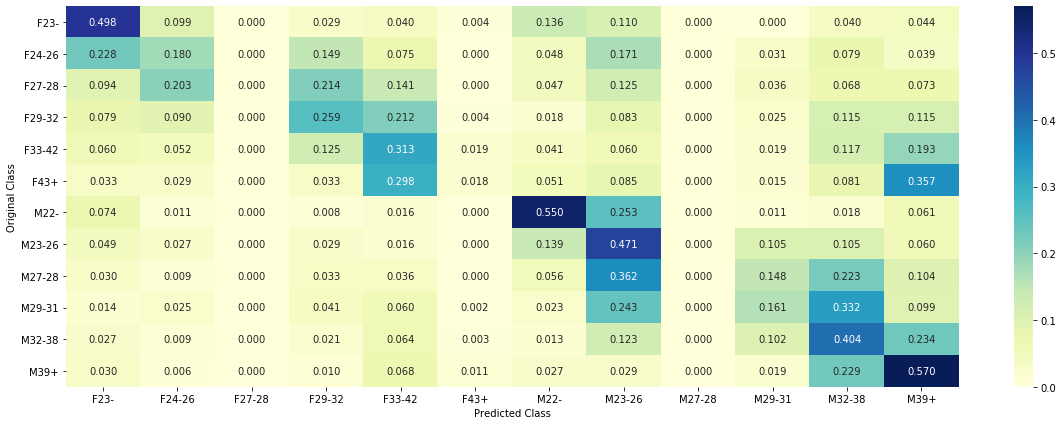

In [153]:
print("CV Average Log-Loss: ",log_loss(y_cv_2, cv_pred_avg_2_1))
events_nn_1_avg_cv_predicted_classes=np.argmax(cv_pred_avg_2_1, axis=1)
plot_confusion_matrix(y_cv_2,events_nn_1_avg_cv_predicted_classes)

**Average Test Predictions**

In [154]:
test_pred_avg_2_1=np.zeros((test_2.shape[0],12))

In [155]:
for i in range(len(model_list_2)):
    test_pred=model_list_2[i].predict_proba(test_2)
    test_pred_avg_2_1+=test_pred
test_pred_avg_2_1/=len(model_list_2)

**Saving Model Weights**

In [156]:
for i in range(len(model_list_2)):
    model_list_2[i].save('Saved_Models/Events/Neural_Network_1/Model_2_1_'+str(i+1)+'.h5')    

**Saving Test Prediction**

In [157]:
np.save('Models_Test_Predictions/nn_1_events_avg_test_prediction',test_pred_avg_2_1)

### 7.2.1.2. Neural Network 2

Network Architecture Refered from Competition 3rd Place Winner: https://github.com/chechir/talking_data

Even in this Network the Dropout in the input Layer adds value and variability for predictions and is helpful for taking avaerage of predictions

In [158]:
def model_2_2(input_dim,output_dim):
    model = Sequential()
    model.add(Dropout(0.4, input_shape=(input_dim,)))
    model.add(Dense(75))
    model.add(PReLU())
    model.add(Dropout(0.30))
    model.add(Dense(50, init='normal', activation='tanh'))
    model.add(PReLU())
    model.add(Dropout(0.20))
    model.add(Dense(output_dim, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

In [159]:
model_2_2_arch=model_2_2(X_train_events_one_hot_1.shape[1],12)
model_2_2_arch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_103 (Dropout)        (None, 21566)             0         
_________________________________________________________________
dense_113 (Dense)            (None, 75)                1617525   
_________________________________________________________________
p_re_lu_82 (PReLU)           (None, 75)                75        
_________________________________________________________________
dropout_104 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 50)                3800      
_________________________________________________________________
p_re_lu_83 (PReLU)           (None, 50)                50        
_________________________________________________________________
dropout_105 (Dropout)        (None, 50)                0         
__________

The Function Takes number of models as input, and trains the required number of models, plots scalar graph for each model in Tensor Board, prints the avg cv loss of all the models, stores the model in a list and returns it

In [160]:
def get_network_2_2_models(n_models):
    """
    Takes number of models,  Trains Neural Network 2 for n_model times,
    stores the models in a list and returns the models
    """
    model_list_3=[]
    avg_cv_loss=0
    for i in range(n_models):
        model=model_2_2(train_2.shape[1],12)
        logdir = os.path.join("logs_301","Model_2_2."+str(i+1))
        t_callback=TensorBoard(log_dir=logdir)
        model.fit(train_2, y_train_nn_3, batch_size=149, epochs=20, verbose=1, validation_data=(cv_2, y_cv_nn_3),callbacks=[early_stop_1,t_callback])
        model_cv_prediction=model.predict_proba(cv_2)
        cv_loss=log_loss(y_cv_2, model_cv_prediction)
        print("CV Log Loss of Best Weights Model in Current Run: ",cv_loss)
        model_list_3.append(model)
        avg_cv_loss+=cv_loss
    avg_cv_loss/=n_models
    print("Average CV Loss of "+str(n_models)+" Runs :",avg_cv_loss)
    return model_list_3

In [161]:
model_list_3=get_network_2_2_models(20)

Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 5s 282us/step - loss: 2.3159 - acc: 0.1790 - val_loss: 2.2005 - val_acc: 0.2132
Epoch 2/20
18647/18647 [==============================] - 5s 243us/step - loss: 2.1479 - acc: 0.2423 - val_loss: 2.1001 - val_acc: 0.2656
Epoch 3/20
18647/18647 [==============================] - 4s 241us/step - loss: 2.0801 - acc: 0.2713 - val_loss: 2.0085 - val_acc: 0.2997
Epoch 4/20
18647/18647 [==============================] - 4s 241us/step - loss: 2.0438 - acc: 0.2788 - val_loss: 2.0048 - val_acc: 0.2967
Epoch 5/20
18647/18647 [==============================] - 5s 242us/step - loss: 2.0071 - acc: 0.2931 - val_loss: 1.9974 - val_acc: 0.2891
Epoch 6/20
18647/18647 [==============================] - 5s 245us/step - loss: 1.9850 - acc: 0.2994 - val_loss: 1.9734 - val_acc: 0.3127
Epoch 7/20
18647/18647 [==============================] - 5s 259us/step - loss: 1.9684 - acc: 0.3040 - val_loss: 1.9655 - v

18647/18647 [==============================] - 5s 244us/step - loss: 1.8145 - acc: 0.3568 - val_loss: 1.9302 - val_acc: 0.3239
Epoch 19/20
18647/18647 [==============================] - 5s 247us/step - loss: 1.7933 - acc: 0.3686 - val_loss: 1.9935 - val_acc: 0.2997
CV Log Loss of Best Weights Model in Current Run:  1.919431993729027
Train on 18647 samples, validate on 4662 samples
Epoch 1/20
18647/18647 [==============================] - 5s 292us/step - loss: 2.3337 - acc: 0.1663 - val_loss: 2.2041 - val_acc: 0.2119
Epoch 2/20
18647/18647 [==============================] - 5s 249us/step - loss: 2.1574 - acc: 0.2393 - val_loss: 2.0875 - val_acc: 0.2767
Epoch 3/20
18647/18647 [==============================] - 5s 247us/step - loss: 2.0875 - acc: 0.2617 - val_loss: 2.1214 - val_acc: 0.2377
Epoch 4/20
18647/18647 [==============================] - 5s 243us/step - loss: 2.0506 - acc: 0.2795 - val_loss: 1.9877 - val_acc: 0.3037
Epoch 5/20
18647/18647 [==============================] - 5s 263

Epoch 2/20
18647/18647 [==============================] - 5s 246us/step - loss: 2.1547 - acc: 0.2378 - val_loss: 2.0482 - val_acc: 0.2812
Epoch 3/20
18647/18647 [==============================] - 5s 264us/step - loss: 2.0826 - acc: 0.2658 - val_loss: 2.0671 - val_acc: 0.2840
Epoch 4/20
18647/18647 [==============================] - 5s 255us/step - loss: 2.0442 - acc: 0.2803 - val_loss: 2.1399 - val_acc: 0.2392
Epoch 5/20
18647/18647 [==============================] - 5s 246us/step - loss: 2.0211 - acc: 0.2874 - val_loss: 1.9523 - val_acc: 0.3207
Epoch 6/20
18647/18647 [==============================] - 5s 250us/step - loss: 1.9896 - acc: 0.2955 - val_loss: 1.9606 - val_acc: 0.3215
Epoch 7/20
18647/18647 [==============================] - 5s 259us/step - loss: 1.9694 - acc: 0.3088 - val_loss: 1.9434 - val_acc: 0.3218
Epoch 8/20
18647/18647 [==============================] - 5s 253us/step - loss: 1.9486 - acc: 0.3120 - val_loss: 1.9542 - val_acc: 0.3183
Epoch 9/20
18647/18647 [==========

18647/18647 [==============================] - 5s 249us/step - loss: 1.9956 - acc: 0.2961 - val_loss: 1.9516 - val_acc: 0.3164
Epoch 7/20
18647/18647 [==============================] - 5s 250us/step - loss: 1.9756 - acc: 0.3019 - val_loss: 1.9481 - val_acc: 0.3168
Epoch 8/20
18647/18647 [==============================] - 5s 253us/step - loss: 1.9522 - acc: 0.3114 - val_loss: 1.9497 - val_acc: 0.3181
Epoch 9/20
18647/18647 [==============================] - 5s 249us/step - loss: 1.9346 - acc: 0.3180 - val_loss: 1.9494 - val_acc: 0.3224
Epoch 10/20
18647/18647 [==============================] - 5s 249us/step - loss: 1.9172 - acc: 0.3197 - val_loss: 1.9638 - val_acc: 0.3046
Epoch 11/20
18647/18647 [==============================] - 5s 249us/step - loss: 1.9102 - acc: 0.3234 - val_loss: 1.9288 - val_acc: 0.3245
Epoch 12/20
18647/18647 [==============================] - 5s 254us/step - loss: 1.8912 - acc: 0.3287 - val_loss: 1.9513 - val_acc: 0.3155
Epoch 13/20
18647/18647 [=================

Epoch 11/20
18647/18647 [==============================] - 5s 252us/step - loss: 1.9048 - acc: 0.3250 - val_loss: 1.9716 - val_acc: 0.3104
Epoch 12/20
18647/18647 [==============================] - 5s 253us/step - loss: 1.8899 - acc: 0.3354 - val_loss: 1.9571 - val_acc: 0.3087
Epoch 13/20
18647/18647 [==============================] - 5s 251us/step - loss: 1.8797 - acc: 0.3337 - val_loss: 1.9674 - val_acc: 0.3050
Epoch 14/20
18647/18647 [==============================] - 5s 251us/step - loss: 1.8599 - acc: 0.3445 - val_loss: 1.9201 - val_acc: 0.3275
Epoch 15/20
18647/18647 [==============================] - 5s 250us/step - loss: 1.8624 - acc: 0.3408 - val_loss: 1.9244 - val_acc: 0.3241
Epoch 16/20
18647/18647 [==============================] - 5s 251us/step - loss: 1.8442 - acc: 0.3469 - val_loss: 1.9557 - val_acc: 0.3164
Epoch 17/20
18647/18647 [==============================] - 5s 250us/step - loss: 1.8256 - acc: 0.3535 - val_loss: 1.9637 - val_acc: 0.3170
Epoch 18/20
18647/18647 [==

**TensorBoard Plots**

As there are 20 Models, Showing Plots for 7 Models at a Time to have a better visualization of Plots

**Models 1-7**

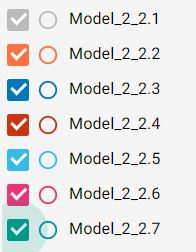

In [162]:
Image('TensorBoard_Graphs/Model_2_2/Models_1-7.jpg')

**Models 1-7 Train Accuracy**

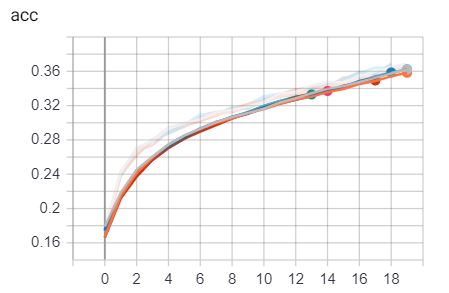

In [163]:
Image('TensorBoard_Graphs/Model_2_2/Models_1-7_Train_Accuracy.jpg')

**Models 1-7 Train Loss**

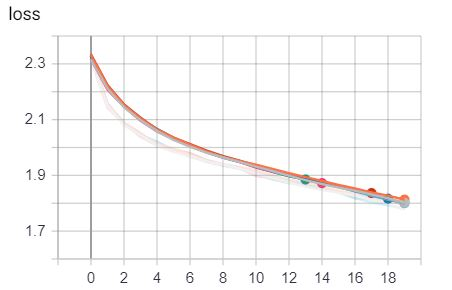

In [164]:
Image('TensorBoard_Graphs/Model_2_2/Models_1-7_Train_Loss.jpg')

**Models 1-7 Validation Accuracy**

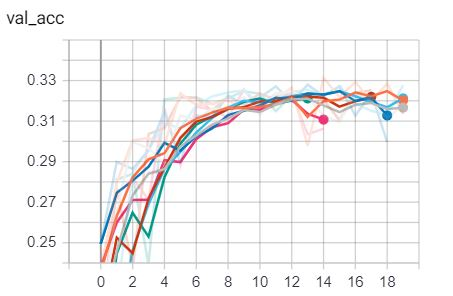

In [166]:
Image('TensorBoard_Graphs/Model_2_2/Models_1-7_Val_Accuracy.jpg')

**Models 1-7 Validation Loss**

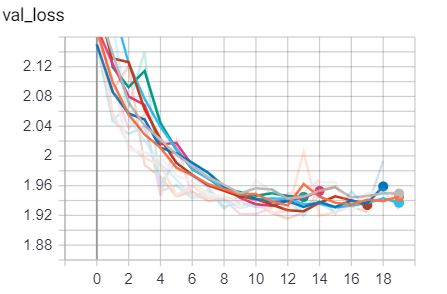

In [167]:
Image('TensorBoard_Graphs/Model_2_2/Models_1-7_Val_Loss.jpg')

**Models 8-14**

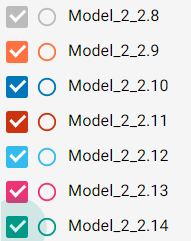

In [169]:
Image('TensorBoard_Graphs/Model_2_2/Models_8-14.jpg')

**Models 8-14 Train Accuracy**

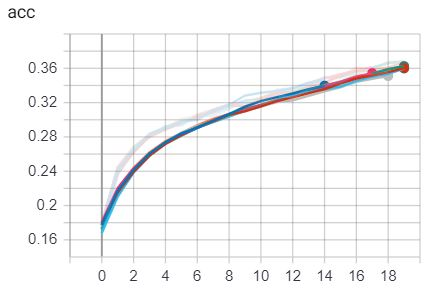

In [170]:
Image('TensorBoard_Graphs/Model_2_2/Models_8-14_Train_Accuracy.jpg')

**Models 8-14 Train Loss**

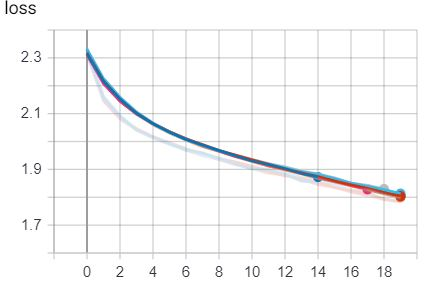

In [171]:
Image('TensorBoard_Graphs/Model_2_2/Models_8-14_Train_Loss.jpg')

**Models 8-14 Validation Accuracy**

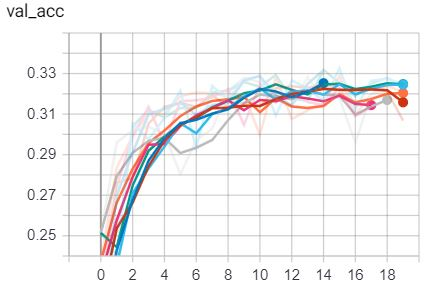

In [172]:
Image('TensorBoard_Graphs/Model_2_2/Models_8-14_Val_Accuracy.jpg')

**Models 8-14 Validation Loss**

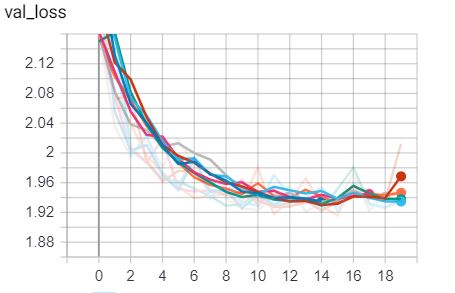

In [173]:
Image('TensorBoard_Graphs/Model_2_2/Models_8-14_Val_Loss.jpg')

**Models 15-20**

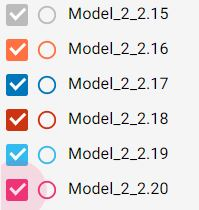

In [174]:
Image('TensorBoard_Graphs/Model_2_2/Models_15-20.jpg')

**Models 15-20 Train Accuracy**

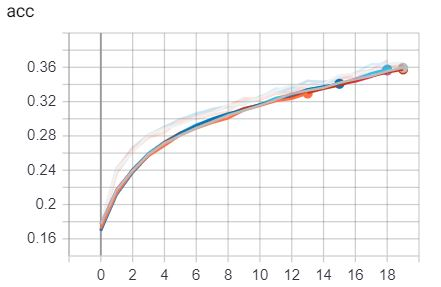

In [175]:
Image('TensorBoard_Graphs/Model_2_2/Models_15-20_Train_Accuracy.jpg')

**Models 15-20 Train Loss**

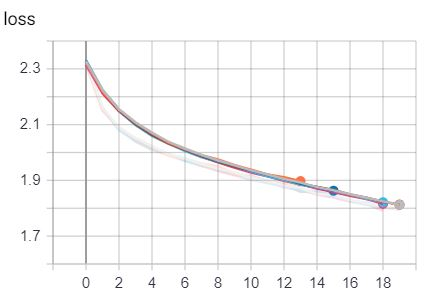

In [176]:
Image('TensorBoard_Graphs/Model_2_2/Models_15-20_Train_Loss.jpg')

**Models 15-20 Validation Accuracy**

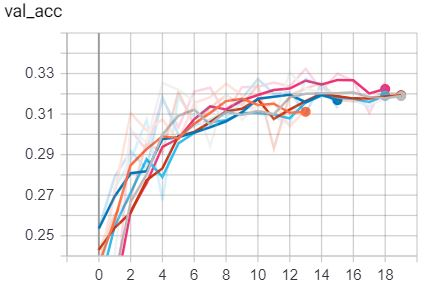

In [177]:
Image('TensorBoard_Graphs/Model_2_2/Models_15-20_Val_Accuracy.jpg')

**Models 15-20 Validation Loss**

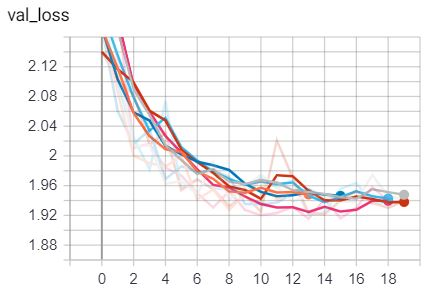

In [178]:
Image('TensorBoard_Graphs/Model_2_2/Models_15-20_Val_Loss.jpg')

**Average Train Prediction**

In [225]:
train_pred_avg_2_2=np.zeros((train_2.shape[0],12))

In [226]:
for i in range(len(model_list_3)):
    train_pred=model_list_3[i].predict_proba(train_2)
    train_pred_avg_2_2+=train_pred
train_pred_avg_2_2/=len(model_list_3)

Train Average Log-Loss:  1.6577248942721219
-------------------- Confusion matrix --------------------


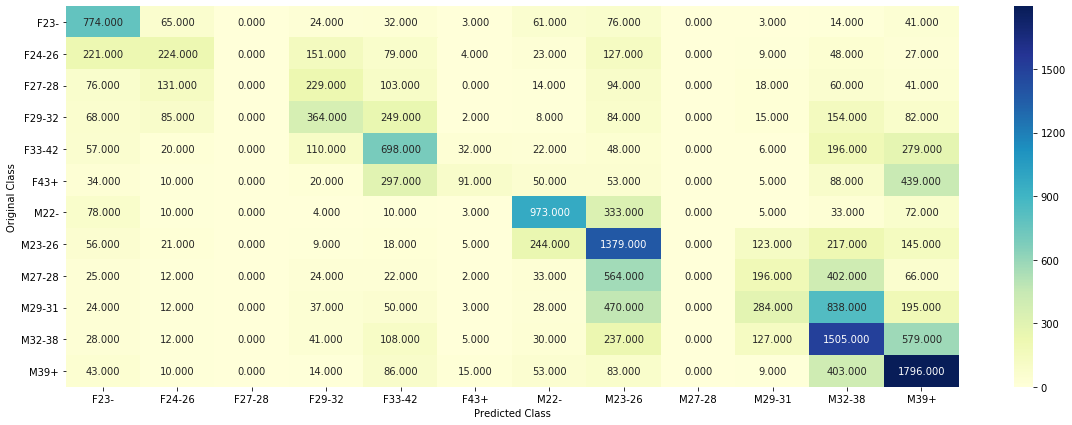

-------------------- Precision matrix (Columm Sum=1) --------------------


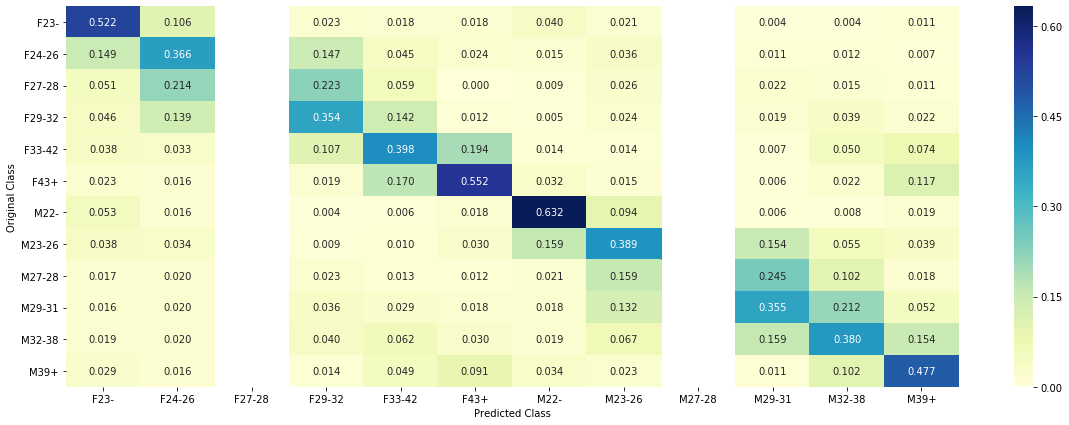

-------------------- Recall matrix (Row sum=1) --------------------


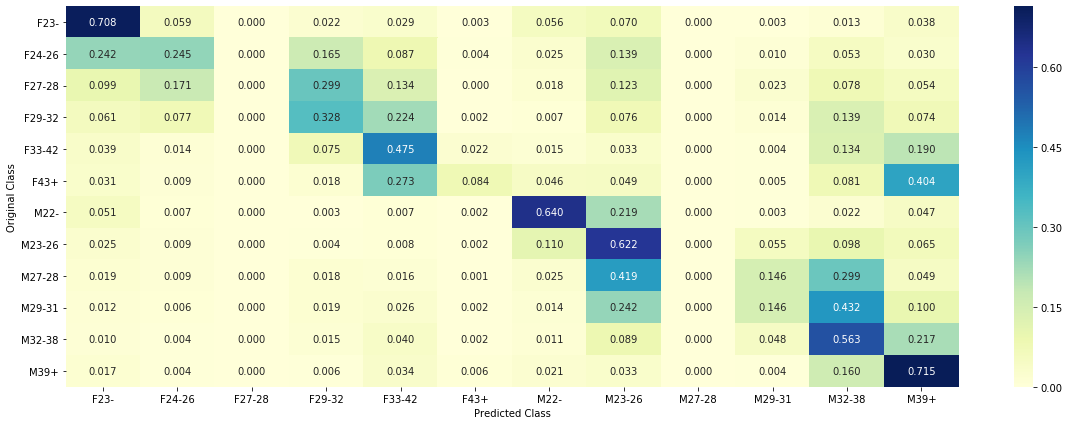

In [227]:
print("Train Average Log-Loss: ",log_loss(y_train_2, train_pred_avg_2_2))
events_nn_2_avg_train_predicted_classes=np.argmax(train_pred_avg_2_2, axis=1)
plot_confusion_matrix(y_train_2,events_nn_2_avg_train_predicted_classes)

**Average CV Prediction**

In [179]:
cv_pred_avg_2_2=np.zeros((cv_2.shape[0],12))

In [180]:
for i in range(len(model_list_3)):
    cv_pred=model_list_3[i].predict_proba(cv_2)
    cv_pred_avg_2_2+=cv_pred
cv_pred_avg_2_2/=len(model_list_3)

CV Average Log-Loss:  1.900681885756447
-------------------- Confusion matrix --------------------


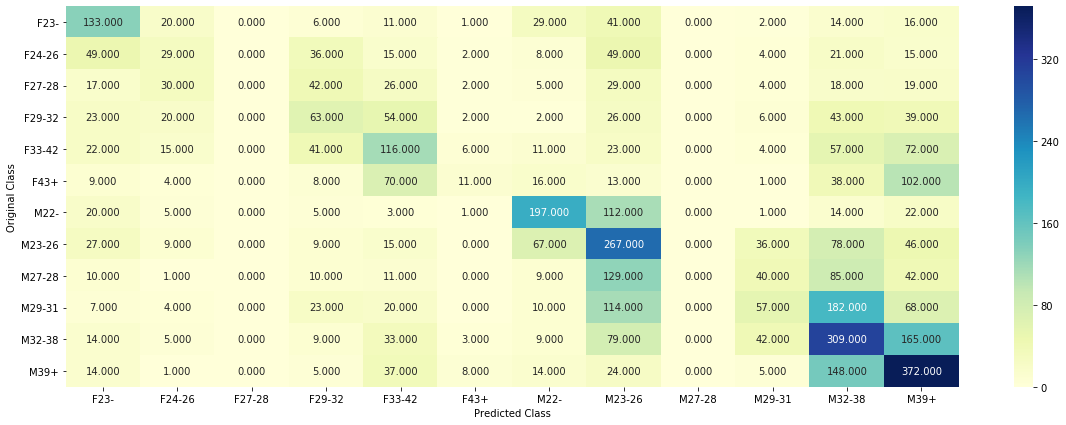

-------------------- Precision matrix (Columm Sum=1) --------------------


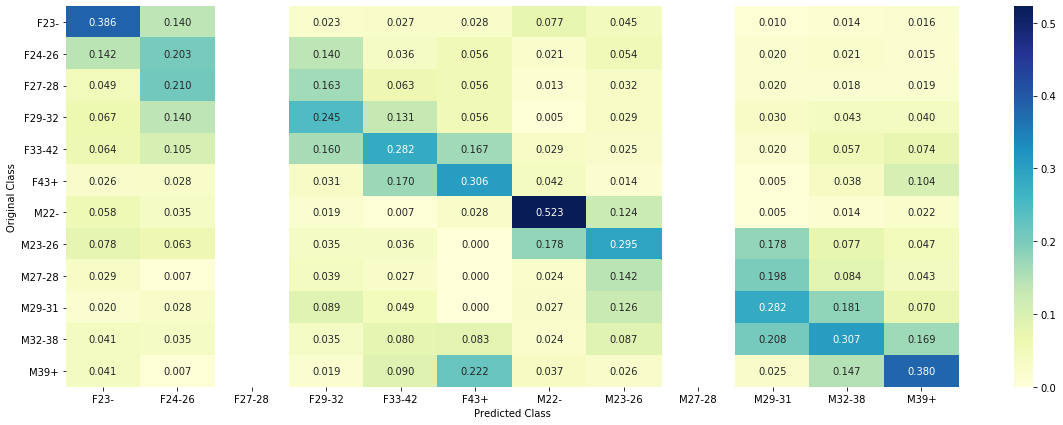

-------------------- Recall matrix (Row sum=1) --------------------


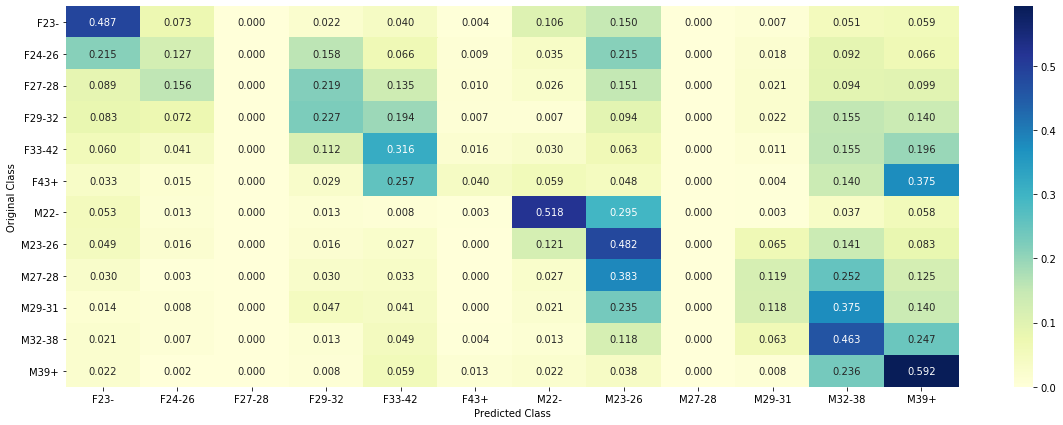

In [181]:
print("CV Average Log-Loss: ",log_loss(y_cv_2, cv_pred_avg_2_2))
events_nn_2_avg_cv_predicted_classes=np.argmax(cv_pred_avg_2_2, axis=1)
plot_confusion_matrix(y_cv_2,events_nn_2_avg_cv_predicted_classes)

**Average Test Predictions**

In [182]:
test_pred_avg_2_2=np.zeros((test_2.shape[0],12))

In [183]:
for i in range(len(model_list_3)):
    test_pred=model_list_3[i].predict_proba(test_2)
    test_pred_avg_2_2+=test_pred
test_pred_avg_2_2/=len(model_list_3)

**Saving Model Weights**

In [184]:
for i in range(len(model_list_3)):
    model_list_3[i].save('Saved_Models/Events/Neural_Network_2/Model_2_2_'+str(i+1)+'.h5')    

**Saving Test Prediction**

In [157]:
np.save('Models_Test_Predictions/nn_2_events_avg_test_prediction',test_pred_avg_2_2)

### 7.3. Model Esembling

**Approach**
1. **Devices with No Events Data:** Take Weighted Average of Predictions of Predictions of 3 Models:
   * Logistic Regression (0.15)
   * No Events Neural Network 1 Avearge Predictions (0.75)
   * No Events Neural Network 2 Predictions (0.1)
2. **Devices with Events Data:** Take Weighted Avearge of Predictions of 2 Models:
   * Events Neural Network 1 Avearge Predictions (0.5)
   * Events Neural Network 2 Avearge Predictions (0.5)

**Ensemble Process Flow Diagram**

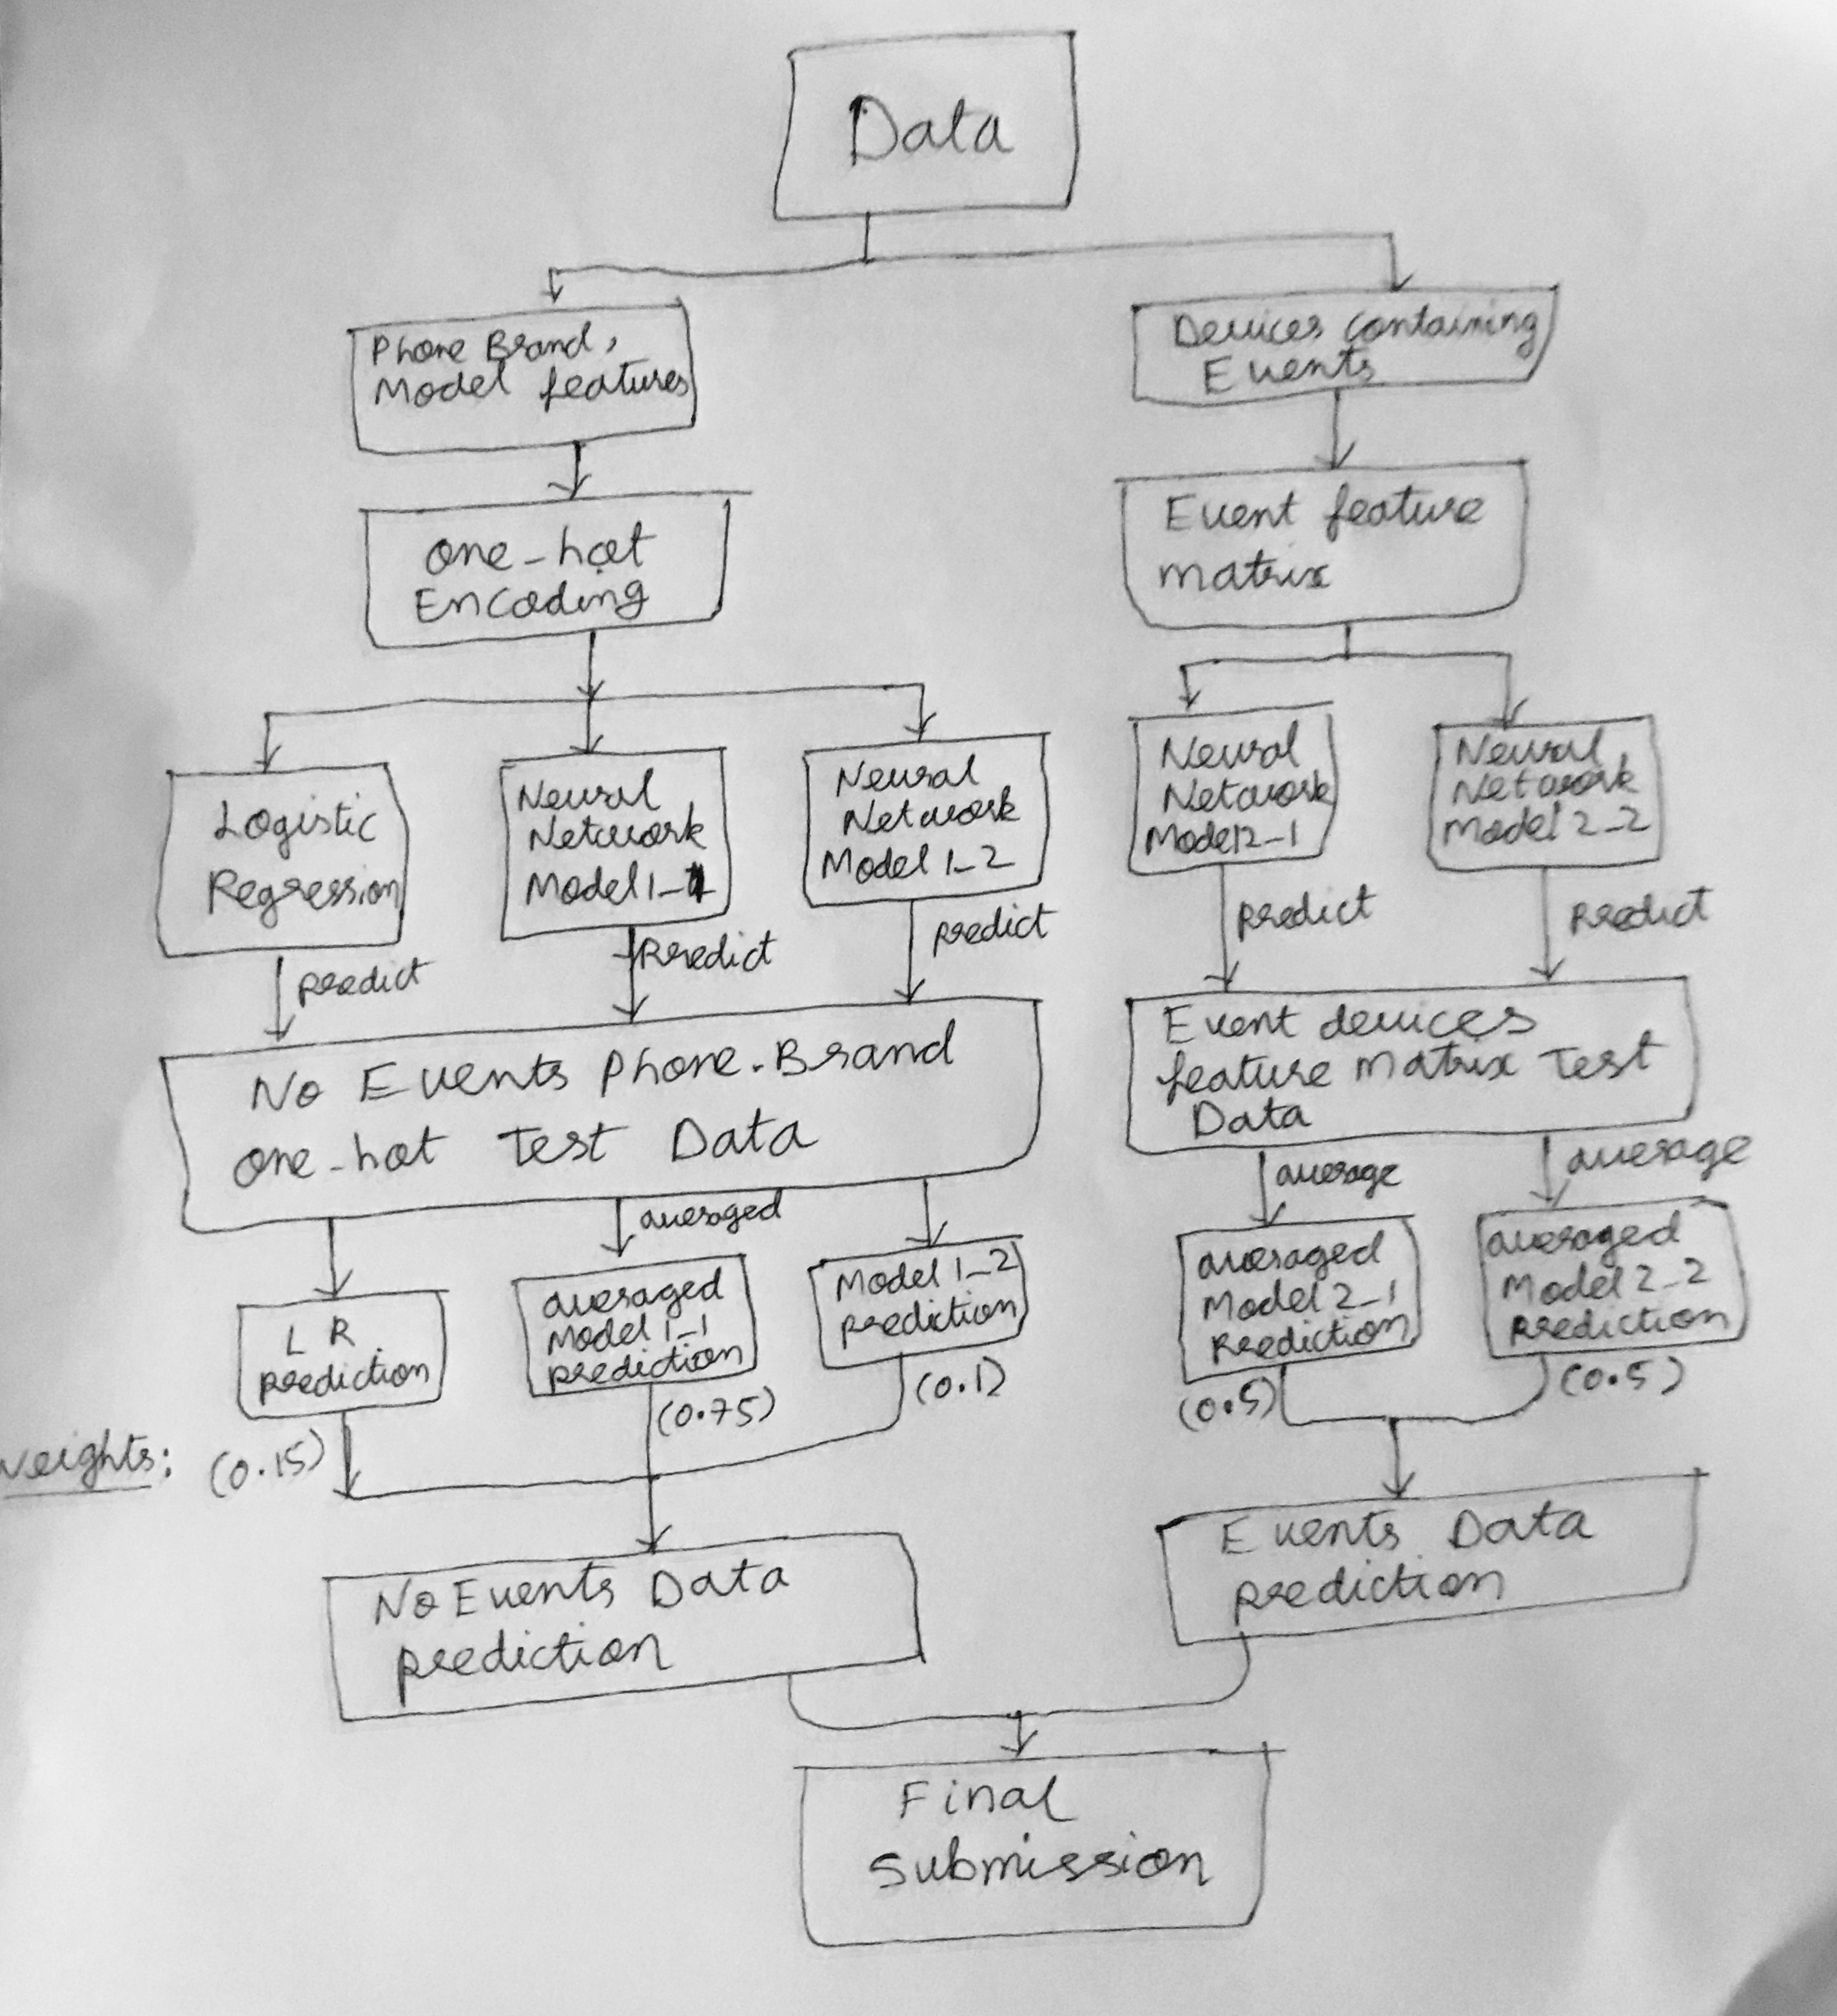

In [235]:
Image('Ensemble_Process_Flow_Diagram.jpg')

In [185]:
w1_1=0.15
w1_2=0.75
w1_3=0.1

In [188]:
w2_1=0.5
w2_2=0.5

#### 7.3.1. Train Data Ensemble Predictions

**No Events Devices Data**

In [228]:
train_prediction_1=(w1_1*lr_no_events_train_prediction)+(w1_2*train_pred_avg_1_1)+(w1_3*train_pred_1_2)

Train Log-Loss:  2.3593547330839515
-------------------- Confusion matrix --------------------


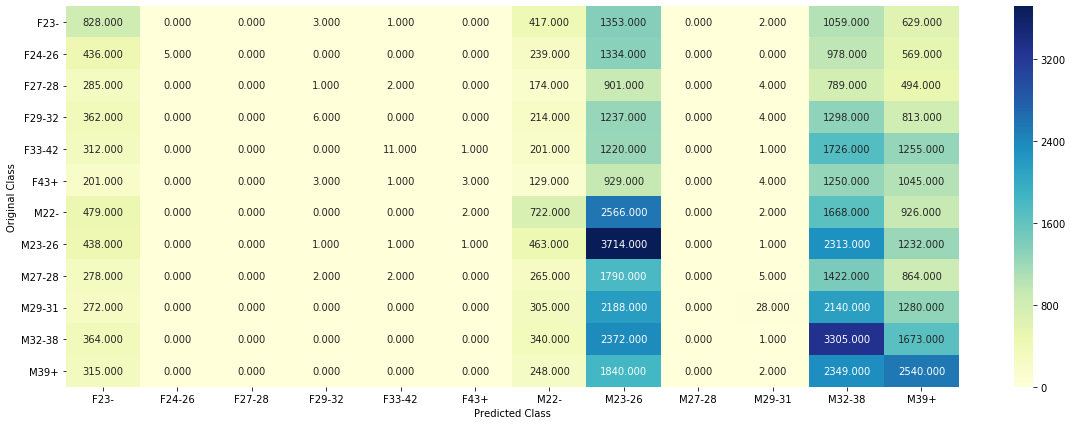

-------------------- Precision matrix (Columm Sum=1) --------------------


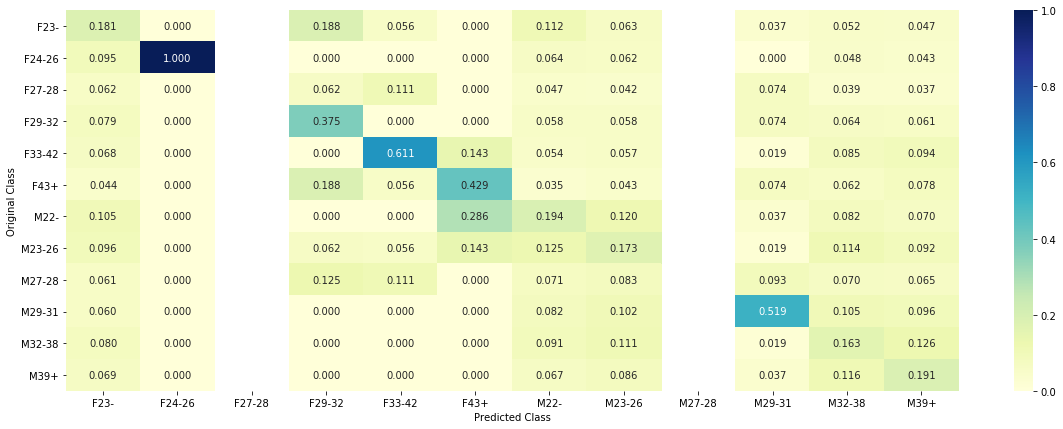

-------------------- Recall matrix (Row sum=1) --------------------


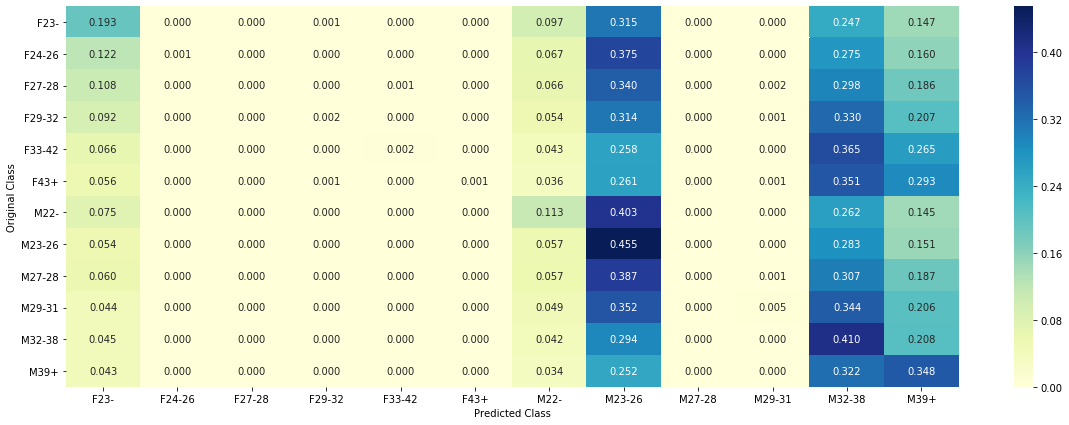

In [231]:
print("Train Log-Loss: ",log_loss(y_train_1, train_prediction_1))
ensembled_noevents_train_predicted_classes=np.argmax(train_prediction_1, axis=1)
plot_confusion_matrix(y_train_1,ensembled_noevents_train_predicted_classes)

**Events Devices Data**

In [232]:
train_prediction_2=(w2_1*train_pred_avg_2_1)+(w2_2*train_pred_avg_2_2)

Train Log-Loss:  1.606074682066437
-------------------- Confusion matrix --------------------


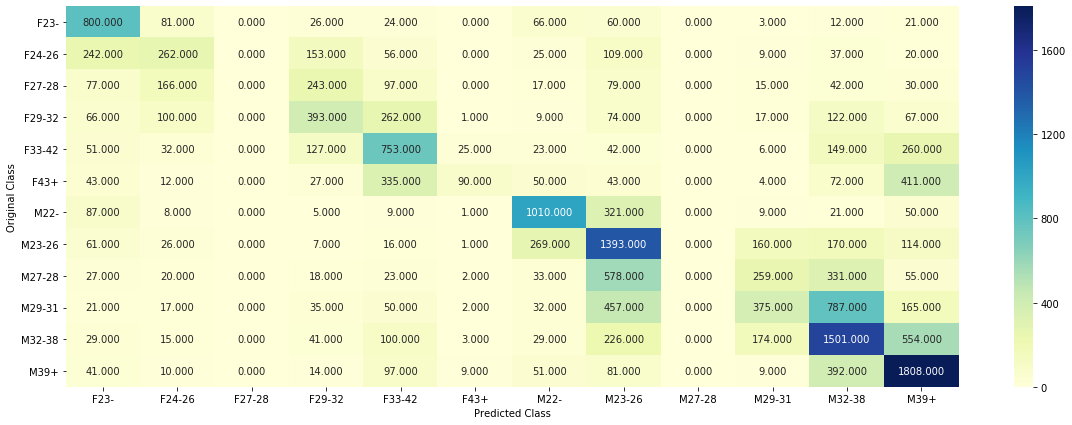

-------------------- Precision matrix (Columm Sum=1) --------------------


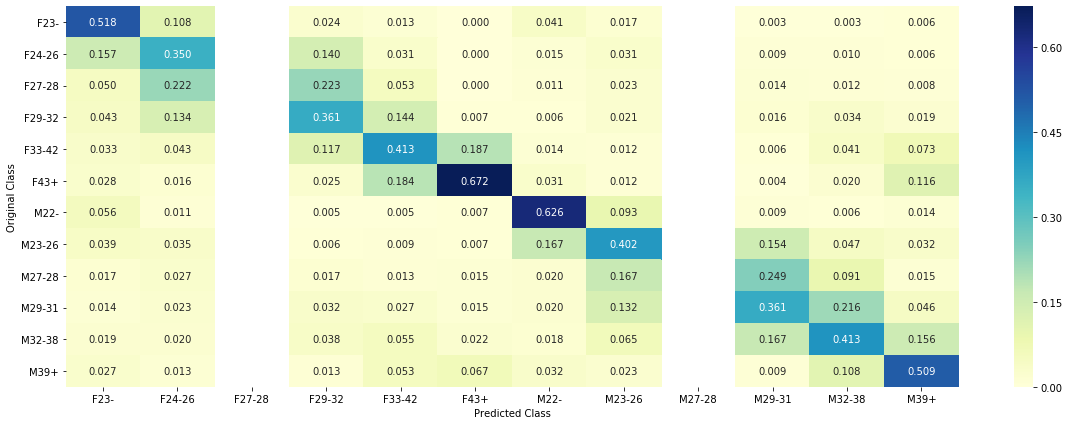

-------------------- Recall matrix (Row sum=1) --------------------


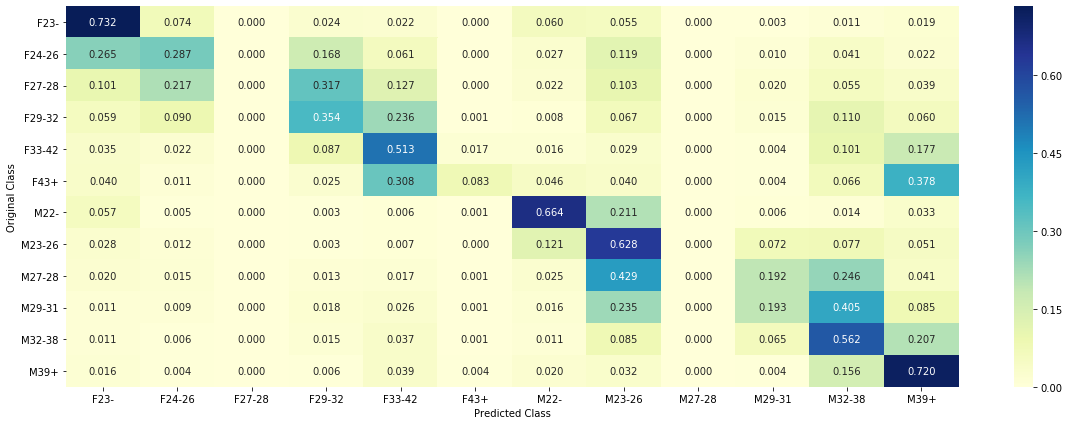

In [233]:
print("Train Log-Loss: ",log_loss(y_train_2, train_prediction_2))
ensembled_events_train_predicted_classes=np.argmax(train_prediction_2, axis=1)
plot_confusion_matrix(y_train_2,ensembled_events_train_predicted_classes)

#### 7.3.2. CV Data Ensemble Predictions

**No Events Devices Data**

In [199]:
cv_prediction_1=(w1_1*lr_no_events_cv_prediction)+(w1_2*cv_pred_avg_1_1)+(w1_3*cv_pred_1_2)

CV Log-Loss:  2.3624803139778296
-------------------- Confusion matrix --------------------


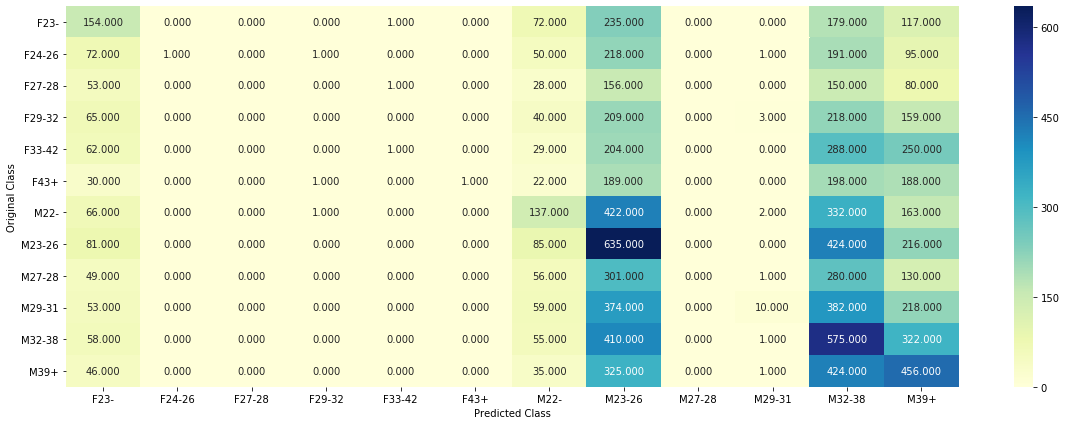

-------------------- Precision matrix (Columm Sum=1) --------------------


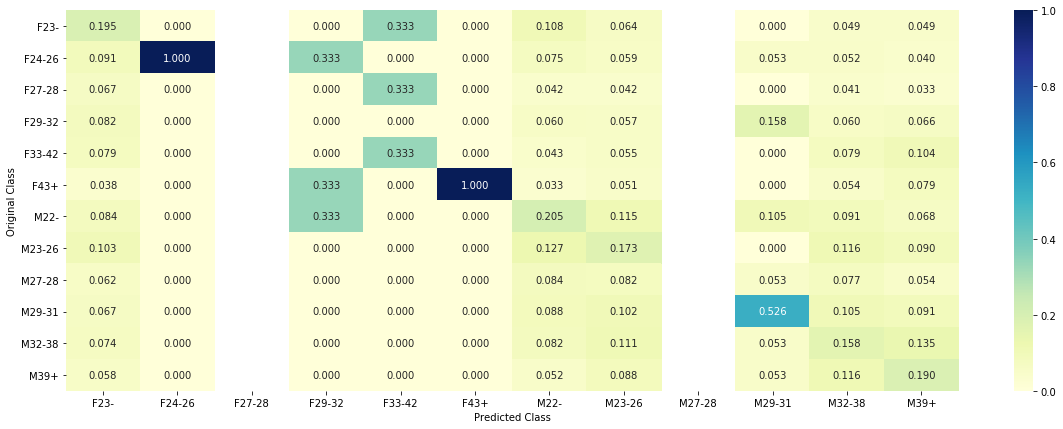

-------------------- Recall matrix (Row sum=1) --------------------


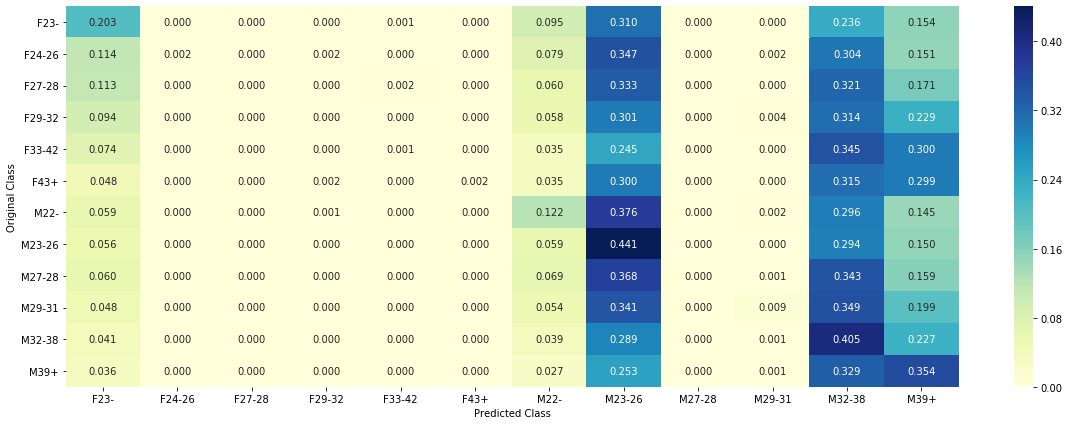

In [201]:
print("CV Log-Loss: ",log_loss(y_cv_1, cv_prediction_1))
ensembled_noevents_cv_predicted_classes=np.argmax(cv_prediction_1, axis=1)
plot_confusion_matrix(y_cv_1,ensembled_noevents_cv_predicted_classes)

**Observation** The Weighted Ensemble method for Devices with No Events Data has improved the Precision for F24-26, F43+ Classes

**Events Devices Data**

In [202]:
cv_prediction_2=(w2_1*cv_pred_avg_2_1)+(w2_2*cv_pred_avg_2_2)

CV Log-Loss:  1.8937726608417007
-------------------- Confusion matrix --------------------


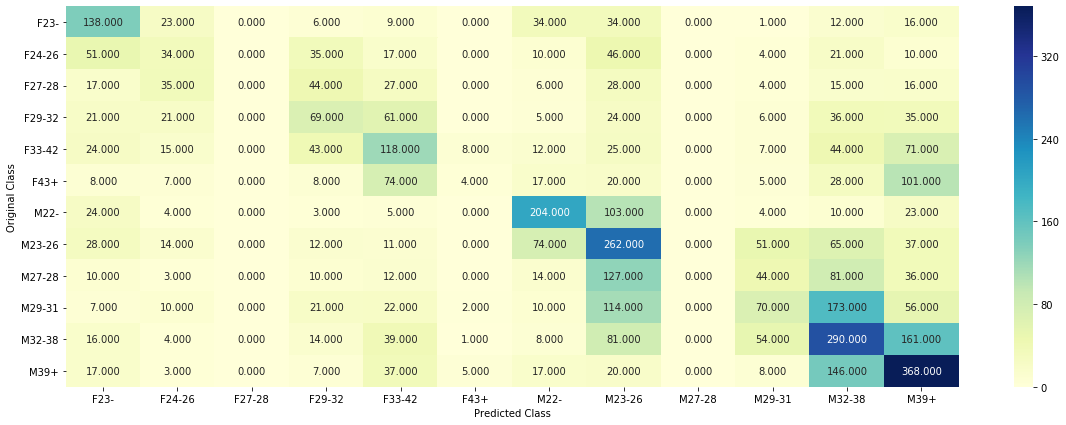

-------------------- Precision matrix (Columm Sum=1) --------------------


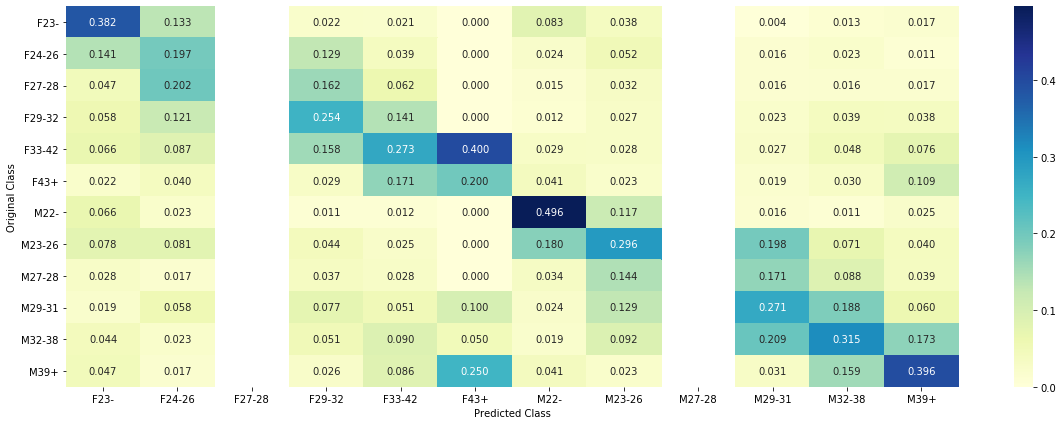

-------------------- Recall matrix (Row sum=1) --------------------


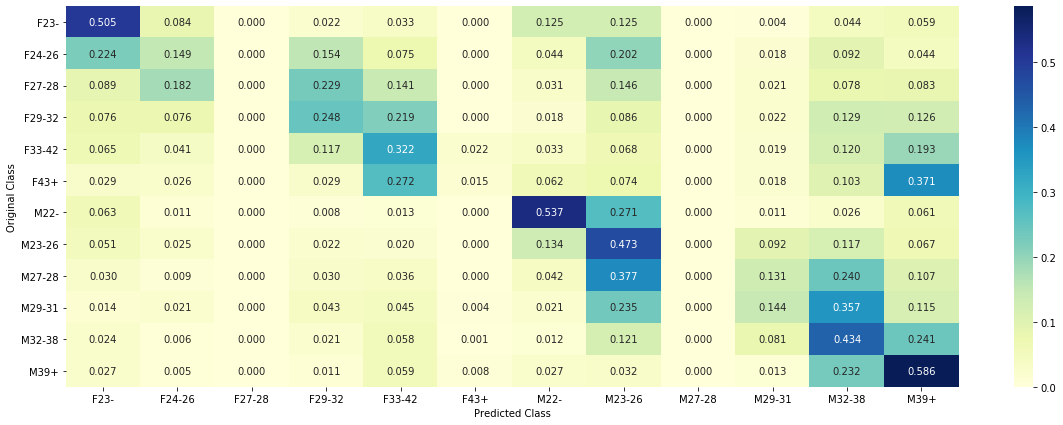

In [203]:
print("CV Log-Loss: ",log_loss(y_cv_2, cv_prediction_2))
ensembled_events_cv_predicted_classes=np.argmax(cv_prediction_2, axis=1)
plot_confusion_matrix(y_cv_2,ensembled_events_cv_predicted_classes)

**Observation**
The Weighted Average Model for Devices with Events has improved the Log-Loss to 1.893 which is less than each Neural Network Model Average CV Log-Loss

#### 7.3.3. Test Data Ensemble Predictions

**No Events Devices Data**

In [204]:
Test_Prediction_1=(w1_1*lr_no_events_test_prediction)+(w1_2*test_pred_avg_1_1)+(w1_3*test_pred_1_2)

**Events Devices Data**

In [205]:
Test_Prediction_2=(w2_1*test_pred_avg_2_1)+(w2_2*test_pred_avg_2_2)

**Combing Events and No Events Devices Data for Submission**

In [206]:
gatrain=pd.read_csv('gender_age_train.csv',index_col = 'device_id')

In [207]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [208]:
pred_1 = pd.DataFrame(Test_Prediction_1, index = noevents_test_data.index, columns=targetencoder.classes_)
pred_1.head()

F23-    F24-26    F27-28    F29-32    F33-42  \
device_id                                                                
-5893464122623104785  0.042313  0.058936  0.041534  0.063478  0.058433   
-7560708697029818408  0.042313  0.058936  0.041534  0.063478  0.058433   
 289797889702373958   0.056109  0.057716  0.045337  0.068780  0.082336   
-402874006399730161   0.056109  0.057716  0.045337  0.068780  0.082336   
 5751283639860028129  0.052194  0.063628  0.044303  0.069046  0.085547   

                          F43+      M22-    M23-26    M27-28    M29-31  \
device_id                                                                
-5893464122623104785  0.046142  0.090037  0.155546  0.095427  0.107495   
-7560708697029818408  0.046142  0.090037  0.155546  0.095427  0.107495   
 289797889702373958   0.067826  0.090034  0.115596  0.072787  0.098840   
-402874006399730161   0.067826  0.090034  0.115596  0.072787  0.098840   
 5751283639860028129  0.067552  0.075132  0.126071  0.077705  0.096896   

                        M32-38      M39+  
device_id                                 
-5893464122623104785  0.140857  0.099804  
-7560708697029818408  0.140857  0.099804  
 289797889702373958   0.128084  0.116557  
-402874006399730161   0.128084  0.116557  
 5751283639860028129  0.138254  0.103672

In [209]:
pred_2 = pd.DataFrame(Test_Prediction_2, index = events_test_data.index, columns=targetencoder.classes_)
pred_2.head()

F23-    F24-26    F27-28    F29-32    F33-42  \
device_id                                                                
 1002079943728939269  0.000371  0.000961  0.001902  0.007342  0.037344   
-1547860181818787117  0.002505  0.006257  0.010836  0.031956  0.092737   
 7374582448058474277  0.016154  0.036507  0.049818  0.106403  0.158317   
-6220210354783429585  0.006913  0.010392  0.010987  0.018613  0.038297   
 6873889408535437611  0.004667  0.013141  0.017836  0.034807  0.048151   

                          F43+      M22-    M23-26    M27-28    M29-31  \
device_id                                                                
 1002079943728939269  0.050647  0.002846  0.020543  0.026839  0.089048   
-1547860181818787117  0.089913  0.006190  0.036415  0.047029  0.113947   
 7374582448058474277  0.081166  0.013845  0.048168  0.058683  0.109900   
-6220210354783429585  0.055801  0.056078  0.138752  0.092145  0.151722   
 6873889408535437611  0.037600  0.017115  0.098437  0.110895  0.196443   

                        M32-38      M39+  
device_id                                 
 1002079943728939269  0.258287  0.503868  
-1547860181818787117  0.259615  0.302600  
 7374582448058474277  0.195638  0.125399  
-6220210354783429585  0.203287  0.217012  
 6873889408535437611  0.257239  0.163669

In [210]:
final_pred=pd.concat([pred_1,pred_2], axis=0)

In [211]:
final_pred.head()

F23-    F24-26    F27-28    F29-32    F33-42  \
device_id                                                                
-5893464122623104785  0.042313  0.058936  0.041534  0.063478  0.058433   
-7560708697029818408  0.042313  0.058936  0.041534  0.063478  0.058433   
 289797889702373958   0.056109  0.057716  0.045337  0.068780  0.082336   
-402874006399730161   0.056109  0.057716  0.045337  0.068780  0.082336   
 5751283639860028129  0.052194  0.063628  0.044303  0.069046  0.085547   

                          F43+      M22-    M23-26    M27-28    M29-31  \
device_id                                                                
-5893464122623104785  0.046142  0.090037  0.155546  0.095427  0.107495   
-7560708697029818408  0.046142  0.090037  0.155546  0.095427  0.107495   
 289797889702373958   0.067826  0.090034  0.115596  0.072787  0.098840   
-402874006399730161   0.067826  0.090034  0.115596  0.072787  0.098840   
 5751283639860028129  0.067552  0.075132  0.126071  0.077705  0.096896   

                        M32-38      M39+  
device_id                                 
-5893464122623104785  0.140857  0.099804  
-7560708697029818408  0.140857  0.099804  
 289797889702373958   0.128084  0.116557  
-402874006399730161   0.128084  0.116557  
 5751283639860028129  0.138254  0.103672

In [212]:
final_pred.shape

(112071, 12)

In [213]:
final_pred.to_csv('Submission_Final_1.csv',index=True)

## 8. Kaggle Submission

Total **1688** Teams Participated in the Competition, So Rank Should be less than 168 to be in top 10%

**Kaggle Submission Score**

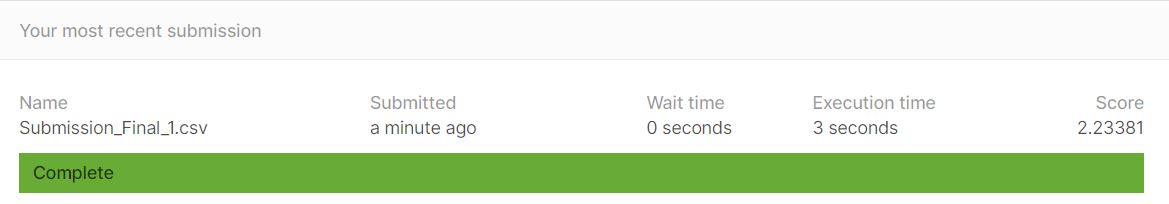

In [214]:
Image('Kaggle_Submission_Score.jpg')

**Submission Results**

1. **Private LeaderBoard Score:** 2.23912
2. **Public LeaderBoard Score:** 2.23381

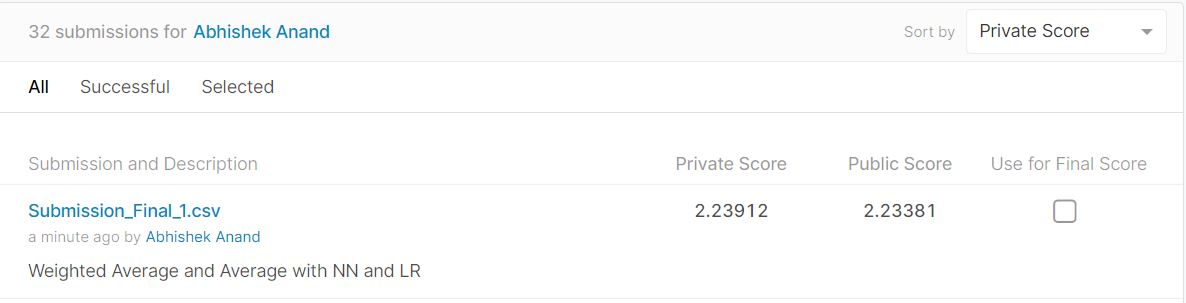

In [215]:
Image('Kaggle_Submission_Results.jpg')

**Top 10% Private LeaderBoard**

Submission Ranks 155th in Private Leader Board

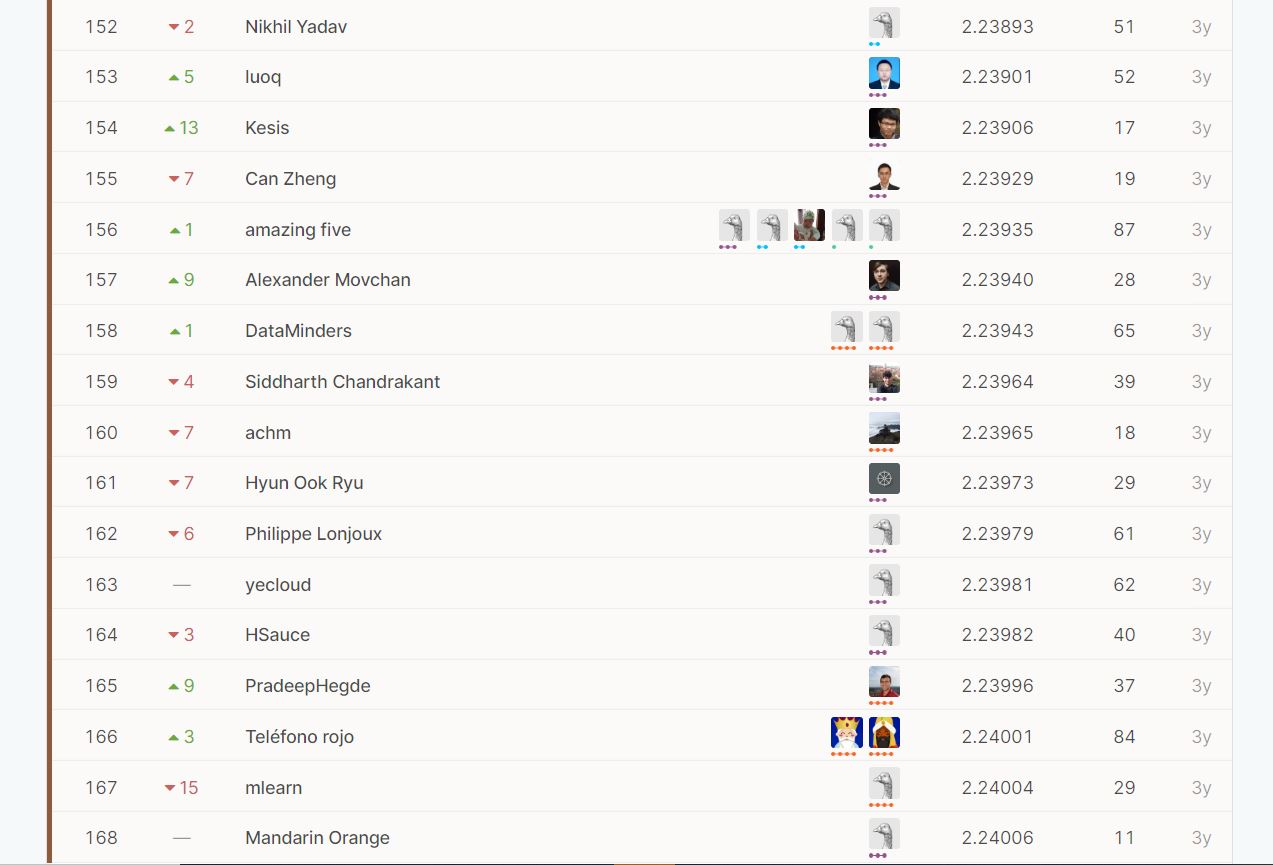

In [216]:
Image('Kaggle_Top_10_Percent_Private_LeaderBoard.jpg')

**Top 10% Public LeaderBoard**

Submission Ranks 146th in Private Leader Board

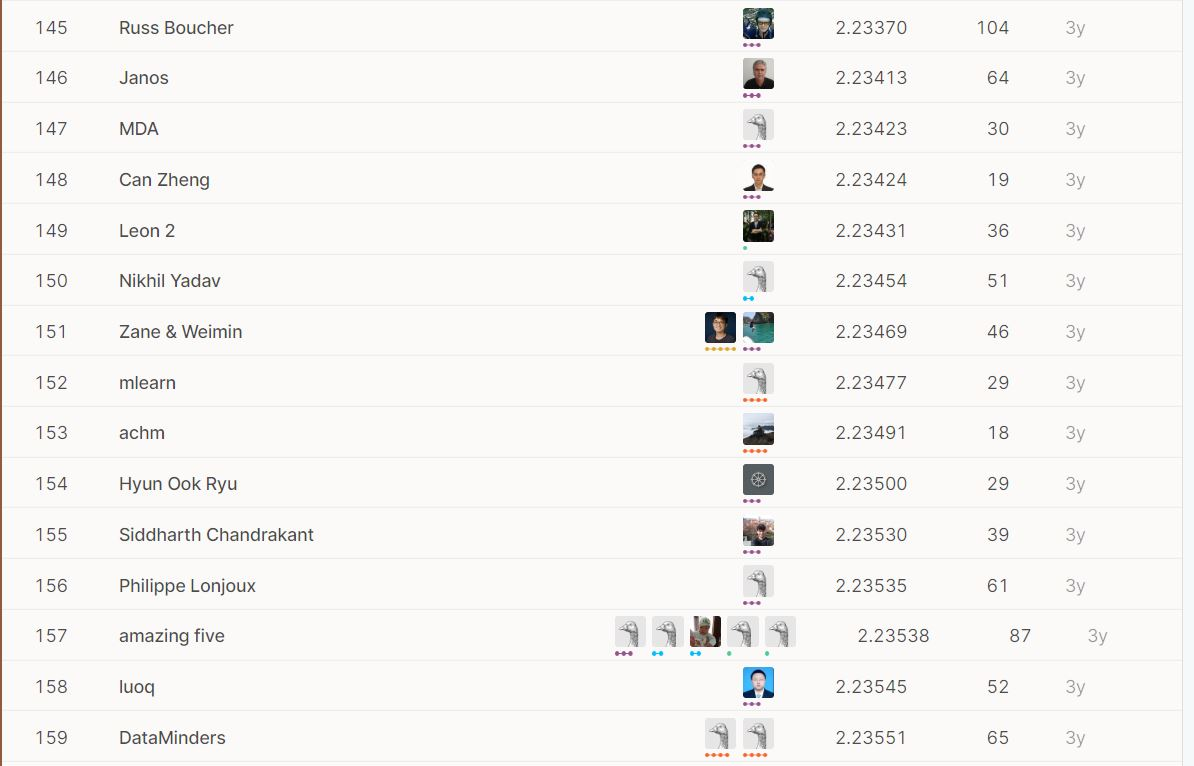

In [217]:
Image('Kaggle_Top_10_Percent_Public_LeaderBoard.jpg')

## 9. Results

1. **No Events Data:** The Model is Trained on One_Hot Encodings of Phone Brand, Model for All the Devices
2. **Events Data:** The Model is Trained on Events Feature Matrix, only for the Devices which contain Event Details
3. Avg in Model indicates the Model has multiple Runs and predictions are averaged

In [234]:
from prettytable import PrettyTable

pt = PrettyTable()

pt.field_names = ["Model", "Data", " CV Log-loss"]
pt.add_row(["Logistic Regression", "No Events",  2.389])
pt.add_row(["XG Boost", "No Events",  2.393])
pt.add_row(["Avg NN Model_1_1", "No Events",  2.355])
pt.add_row(["NN Model_1_2", "No Events",  2.390 ])
pt.add_row(["Avg NN Model_2_1", "Events",  1.904])
pt.add_row(["Avg NN Model_2_2", "Events", 1.9])
pt.add_row(["Ensembled Model No Events", "No Events", 2.362])
pt.add_row(["Ensembled Model Events", "Events", 1.893])

print(pt)            

+---------------------------+-----------+--------------+
|           Model           |    Data   |  CV Log-loss |
+---------------------------+-----------+--------------+
|    Logistic Regression    | No Events |    2.389     |
|          XG Boost         | No Events |    2.393     |
|      Avg NN Model_1_1     | No Events |    2.355     |
|        NN Model_1_2       | No Events |     2.39     |
|      Avg NN Model_2_1     |   Events  |    1.904     |
|      Avg NN Model_2_2     |   Events  |     1.9      |
| Ensembled Model No Events | No Events |    2.362     |
|   Ensembled Model Events  |   Events  |    1.893     |
+---------------------------+-----------+--------------+


## 10. Conclusion

1. There is a Large amount of Missing Data Related to Event Details, almost 70% of Both Train and Test Data do not have Event Details
2. Event Data is essential for Predicting the correct user group without which we are left with only Phone Brand and Model Features, and predicting User Groups for 70% of Data with only these 2 features is Challenging
3. The Ensembled Models for Event Data have the Best Log-loss of 1.893 among all other Event Data Models
4. Logistic Regression Model being relatively not a complex model has a log-loss 2.389 which is better than XG Boost Model for No Events Devices Data, so Logistic Regression Model Predictions were used in Ensembling
5. The Final Submission Scores 2.23381 in Public Leader Board and is in Top 10% without using the Leak